# RBE/CS549 Fall 2022: Computer Vision
## Homework 0: Alohomora

Author(s): 
Prof. Nitin J. Sanket (nsanket@wpi.edu), Lening Li (lli4@wpi.edu), Gejji, Vaishnavi Vivek (vgejji@wpi.edu)

Robotics Engineering Department,

Worcester Polytechnic Institute

Code adapted from CMSC733 at the University of Maryland, College Park.


## Phase 1




### Get the BSDS500 dataset

In [ ]:
!wget https://raw.githubusercontent.com/leelening/rbe549/main/hw0/BSDS500.tar.xz
!tar -xvf BSDS500.tar.xz
!mv BSDS500/ content/data/

In [ ]:
!wget https://raw.githubusercontent.com/leelening/rbe549/main/hw0/TxtFiles.tar.xz
!tar -xvf TxtFiles.tar.xz
!mv TxtFiles/ content/data/

In [1]:
import numpy as np
import cv2
import glob
import cv2
import math
import matplotlib.pyplot as plt
import imutils
import sklearn.cluster
import numpy as np
from scipy.stats import multivariate_normal
import scipy.ndimage as ndi
import scipy
from sklearn.cluster import KMeans

np.set_printoptions(suppress=True, precision=3)

In [2]:
"""
Creates a filter bank of Difference of Gaussian (DOG) filters for a given set of scales and orientations
scales: a list of scales for which the DOG filters are to be created
size: the size of the gaussian kernel
orientation: the number of orientations for which the DOG filters are to be created
returns: a list of DOG filters
"""


def create_DOG_filter_bank(scales, size, orientation):
    filterBank = []

    x = np.asarray([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    y = np.asarray([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    for scale in scales:
        gaussian = create_gaussian_kernel(scale, size)

        X = cv2.filter2D(gaussian, -1, x)
        Y = cv2.filter2D(gaussian, -1, y)

        for eachOrient in range(orientation):
            gaussian_current = (X * np.cos((eachOrient * 2 * np.pi / orientation)) + Y * np.cos(
                (eachOrient * 2 * np.pi / orientation)))
            filterBank.append(gaussian_current)

    return filterBank


""""
Creates a 2D Gaussian kernel with a given sigma and kernel size
sigma: the sigma value for the Gaussian kernel
kernel_size: the size of the kernel
"""


def create_gaussian_kernel(sigma, kernel_size):
    if kernel_size % 2 == 0:
        raise ValueError("Kernel size must be an odd.")

    kernel = np.zeros((kernel_size, kernel_size))

    center = kernel_size // 2

    for x in range(kernel_size):
        for y in range(kernel_size):
            x_val = x - center
            y_val = y - center
            kernel[x, y] = np.exp(-(x_val ** 2 + y_val ** 2) / (2 * sigma ** 2))

    return kernel / np.sum(kernel)


"""
Creates a filter bank of Difference of Gaussian (DOG) filters for a given set of scales and orientations
scales: a list of scales for which the DOG filters are to be created
size: the size of the gaussian kernel
order: the order of the derivative to be taken
"""


def oneD_gauss(sigma, mean, x, order):
    mean_x = np.array(x) - mean
    var = sigma ** 2

    gaussian = (1 / np.sqrt(2 * np.pi * var)) * (np.exp((- 1 * mean_x * mean_x) / (2 * var)))

    if order == 0:
        g_1d = gaussian
        return g_1d
    elif order == 1:
        g_1d = - gaussian * ((mean_x) / (var))
        return g_1d
    else:
        g_1d = gaussian * (((mean_x * mean_x) - var) / (var ** 2))
        return g_1d


"""
Creates a 2D Gaussian function with a given support and scales. 
scales: the standard deviation of the Gaussian function
sup: the support of the Gaussian function
"""


def twoD_gauss(sup, scales):
    var = scales * scales
    shape = (sup, sup)
    n, m = [(i - 1) / 2 for i in shape]
    x, y = np.ogrid[-m:m + 1, -n:n + 1]
    g = (1 / np.sqrt(2 * np.pi * var)) * np.exp(-(x * x + y * y) / (2 * var))
    return g


"""
Creates a 2D Laplacian of Gaussian (LoG) function with a given support and scales.
sup: support of the LoG function
scales: the standard deviation of the Gaussian function
"""


def twoD_lapaccian(sup, scales):
    var = scales * scales
    shape = (sup, sup)
    n, m = [(i - 1) / 2 for i in shape]
    x, y = np.ogrid[-m:m + 1, -n:n + 1]
    g = (1 / np.sqrt(2 * np.pi * var)) * np.exp(-(x * x + y * y) / (2 * var))
    h = g * ((x * x + y * y) - var) / (var ** 2)
    return h


"""
Generates a 2D gaussian filter with the given scale, phasex and phasey values, based on the given points and support.
:param scale: scale value for the gaussian filter.
:param phasex: phase value for the x-axis of the gaussian filter.
:param phasey: phase value for the y-axis of the gaussian filter.
:param pts: array of points used to create the gaussian filter.
:param sup: support value for the gaussian filter.
:return: 2D gaussian filter of shape (sup, sup).
 """


def makefilter(scale, phasex, phasey, pts, sup):
    gx = oneD_gauss(3 * scale, 0, pts[0, ...], phasex)
    gy = oneD_gauss(scale, 0, pts[1, ...], phasey)
    image = gx * gy
    image = np.reshape(image, (sup, sup))
    return image


"""
Generates a set of filters for use in the Laplacian of Gaussian (LoG) filter bank.
:return: 3D array of filters of shape (sup, sup, nf) where nf is the number of filters in the filter bank.
"""


def makeLMfilters():
    sup = 49
    scalex = np.sqrt(2) * np.array([1, 2, 3])
    norient = 6
    nrotinv = 12

    nbar = len(scalex) * norient
    nedge = len(scalex) * norient
    nf = nbar + nedge + nrotinv
    F = np.zeros([sup, sup, nf])
    hsup = (sup - 1) / 2

    x = [np.arange(-hsup, hsup + 1)]
    y = [np.arange(-hsup, hsup + 1)]

    [x, y] = np.meshgrid(x, y)

    orgpts = [x.flatten(), y.flatten()]
    orgpts = np.array(orgpts)

    count = 0
    for scale in range(len(scalex)):
        for orient in range(norient):
            angle = (np.pi * orient) / norient
            c = np.cos(angle)
            s = np.sin(angle)
            rotpts = [[c + 0, -s + 0], [s + 0, c + 0]]
            rotpts = np.array(rotpts)
            rotpts = np.dot(rotpts, orgpts)
            F[:, :, count] = makefilter(scalex[scale], 0, 1, rotpts, sup)
            F[:, :, count + nedge] = makefilter(scalex[scale], 0, 2, rotpts, sup)
            count = count + 1

    count = nbar + nedge
    scales = np.sqrt(2) * np.array([1, 2, 3, 4])

    for i in range(len(scales)):
        F[:, :, count] = twoD_gauss(sup, scales[i])
        count = count + 1

    for i in range(len(scales)):
        F[:, :, count] = twoD_lapaccian(sup, scales[i])
        count = count + 1

    for i in range(len(scales)):
        F[:, :, count] = twoD_lapaccian(sup, 3 * scales[i])
        count = count + 1

    return F


"""
Generates a Gabor kernel with specified parameters.
:param ksize: int, the size of the kernel
:param wvlength: int, wavelength of the sinusoidal function
:param theta: float, the orientation of the normal to the parallel stripes
:param offset: float, the phase offset
:param sigma: int, standard deviation of the Gaussian envelope
:param gamma: float, the spatial aspect ratio
:return: numpy array, the generated Gabor kernel
"""


def gaborKernel(ksize, wvlength=6, theta=0, offset=0, sigma=6, gamma=1):
    if (ksize % 2) != 1:
        return None

    sideWidth = int((ksize - 1) / 2)  # convert to int
    kernel = np.zeros((ksize, ksize), dtype=np.float32)
    a = -0.5 / (math.pow(sigma, 2))
    b = -(0.5 * math.pow(gamma, 2)) / (math.pow(sigma, 2))
    const = (2.0 * math.pi) / wvlength
    ct = np.cos(theta)
    st = np.sin(theta)

    for x in range(-sideWidth, sideWidth):  # use int values here
        for y in range(-sideWidth, sideWidth):  # use int values here
            X = x + sideWidth
            Y = y + sideWidth
            x_d = x * ct + y * st
            y_d = -x * st + y * ct
            kernel[X, Y] = np.exp(math.pow(x_d, 2) * a + math.pow(y_d, 2) * b) * np.cos(const * x_d + offset)

    return kernel


"""
Creates a Gabor filter bank with specified parameters.
:param maxSize: int, the size of the filter bank
:param scales: list of lists, the scales of the Gabor kernels
:param orientation: int, the number of orientations of the Gabor kernels
:return: numpy array, the generated Gabor filter bank
"""


def gaborFilterBank(maxSize=37, scales=[[4, 4], [6, 4], [8, 6], [10, 8], [12, 14]], orientation=8):
    index = 0
    gaborfilterBank = np.zeros((maxSize, int(maxSize), len(scales) * orientation), dtype=np.float32)
    rotateAngle = 3.14159 / orientation
    for scale in scales:
        wv = scale[0]
        sig = scale[1]
        for i in range(orientation):
            gaborfilterBank[:, :, index] = gaborKernel(int(maxSize), wvlength=int(wv), theta=i * rotateAngle,
                                                       sigma=int(sig))
            index += 1
    return gaborfilterBank


"""
Creates a texton map of an input image using specified filters.
:param k: int, the number of clusters in the k-means algorithm
:param image: numpy array, the input image
:param dog: numpy array, the Difference of Gaussian filter bank
:param makeLMfilters: numpy array, the Laplacian of Gaussian filter bank
:param gabor: numpy array, the Gabor filter bank
:return: numpy array, the generated texton map
"""


def textonMap(k, image, dog, makeLMfilters, gabor):
    r, g, b = image.shape
    image_textron = np.array(image)
    filters = [dog, makeLMfilters, gabor]
    for bank in filters:
        for eachFilter in range(len(bank)):
            filtered = cv2.filter2D(image, -1, bank[eachFilter])
            image_textron = np.dstack((image_textron, filtered))

    final_texton = image_textron[:, :, 3:]
    x, y, z = final_texton.shape
    final_texton = final_texton.reshape((r * g), z)

    kmeans = sklearn.cluster.KMeans(n_clusters=k, random_state=2)
    kmeans.fit(final_texton)
    labels = kmeans.predict(final_texton)
    labels = labels.reshape([x, y])
    plt.imshow(labels)

    return labels


"""
Creates a brightness map of an input image using k-means clustering.
:param image: numpy array, the input image
:param clusters: int, the number of clusters in the k-means algorithm
:return: numpy array, the generated brightness map"""


def getBrightnessMap(image, clusters=16):
    reshaped = image.reshape((-1, 3))
    kmeans = KMeans(n_clusters=clusters, random_state=0).fit(reshaped)
    label = kmeans.labels_
    label = label.reshape(image.shape[:2])
    return label


"""
Creates a color map of an input image using k-means clustering.
:param image: numpy array, the input image
:param clusters: int, the number of clusters in the k-means algorithm
:return: numpy array, the generated color map"""


def colorMap(image, clusters=16):
    reshaped = image.reshape((-1, 3))

    # Perform k-means clustering using sklearn
    kmeans = KMeans(n_clusters=clusters, random_state=0).fit(reshaped)
    label = kmeans.labels_
    label = label.reshape(image.shape[0], image.shape[1])

    return label


"""
Generates a half disk mask of given radius and orientation.
:param radius: radius of the half disk mask
:param orient: orientation of the half disk mask in degrees
:return hd: half disk mask of given radius and orientation 
"""


def hdGen(radius, orient):
    size = 2 * radius + 1
    hd = np.zeros([size, size])
    for i in range(radius):
        for j in range(size):
            r = np.square(i - radius) + np.square(j - radius)
            if r <= np.square(radius):
                hd[i, j] = 1
    hd = imutils.rotate(hd, orient)
    hd[hd <= 0.5] = 0
    hd[hd > 0.5] = 1

    return hd


"""
Generates a list of half disk masks of different orientations.
:param radius : list of radii of the half disk masks
:param hdmOrientations: number of orientations of the half disk masks
:return hdMasks: list of half disk masks of different orientations
"""


def halfDiskMasks(radius, hdmOrientations):
    hdMasks = []
    for radii in radius:
        mask = np.zeros((radii * 2 + 1, radii * 2 + 1), dtype=np.float32)

        for i in range(radii):
            x = math.pow((i - radii), 2)
            for j in range(radii * 2 + 1):
                if x + math.pow((j - radii), 2) < math.pow(radii, 2):
                    mask[i, j] = 1

        rotateAngle = 360.0 / hdmOrientations
        for i in range(hdmOrientations):
            rotated = ndi.interpolation.rotate(mask, -i * rotateAngle, reshape=False)
            rotated[rotated > 1] = 1
            rotated[rotated < 0] = 0
            ret, rotated = cv2.threshold(rotated, 0.5, 1, cv2.THRESH_BINARY)

            # Rotated pair
            rotated_p = ndi.interpolation.rotate(mask, -i * rotateAngle - 180, reshape=False)
            rotated_p[rotated_p > 1] = 1
            rotated_p[rotated_p < 0] = 0
            ret, rotated_p = cv2.threshold(rotated_p, 0.5, 1, cv2.THRESH_BINARY)

            hdMasks.append(rotated)
            hdMasks.append(rotated_p)

    return hdMasks


"""
Computes Chi-squared gradient of an image using a given bank of half disk masks.
:param image: input image
:param chi_bins: number of bins to use for Chi-squared gradient computation
:param hdBank: list of half disk masks to use for Chi-squared gradient computation
:returns t_grad: Chi-squared gradient of the input image
        
"""


def chi2Gradient(image, chi_bins, hdBank):
    copy = image
    g = []
    h = []
    bank_length = len(hdBank) / 2
    for bl in range(int(bank_length)):
        chi_sqr_dist = image * 0
        mask_1 = hdBank[2 * bl]
        mask_2 = hdBank[2 * bl + 1]
        for eachBin in range(chi_bins):
            mask_image = np.ma.MaskedArray(image, image == eachBin)
            mask_image = mask_image.mask.astype(np.int64)
            g = cv2.filter2D(mask_image, -1, mask_1)
            h = cv2.filter2D(mask_image, -1, mask_2)
            chi_sqr_dist = chi_sqr_dist + ((g - h) ** 2 / (g + h + np.exp(-7)))

        copy = np.dstack((copy, chi_sqr_dist / 2))
    t_grad = np.mean(copy, axis=2)

    return t_grad


"""
Following 5 functions are used for visualization and saving resultss.
"""


def save_DoG(dog):
    plt.subplots(int(len(dog) / 5), 5, figsize=(15, 15))
    for d in range(len(dog)):
        plt.subplot(len(dog) / 5, 5, d + 1)
        plt.axis('off')
        plt.imshow(dog[d], cmap='gray')
    plt.savefig('./Phase1/Results/DoG.png')
    plt.close()


def save_LM(makeLMfilters):
    x, y, r = makeLMfilters.shape
    plt.subplots(4, 12, figsize=(20, 20))
    for l in range(r):
        plt.subplot(4, 12, l + 1)
        plt.axis('off')
        plt.imshow(makeLMfilters[:, :, l], cmap='binary')
    plt.savefig('./Phase1/Results/LM.png')
    plt.close()


def save_Gabor(gabor):
    fig = plt.figure()
    for i in range(1, 41):
        ax = fig.add_subplot(5, 8, i)
        plt.imshow(gabor[:, :, i - 1], interpolation='none', cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
    fig.suptitle("Gabor Filter Bank", fontsize=20)
    plt.savefig('./Phase1/Results/Gabor.png')
    plt.close()


def save_HalfDisk(halfDisk):
    fig2 = plt.figure()
    for i in range(1, len(halfDisk) + 1):
        ax = fig2.add_subplot(6, 8, i)
        plt.imshow(halfDisk[i - 1], interpolation='none', cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
    fig2.suptitle("Half Disk Filter Bank", fontsize=20)
    plt.savefig('./Phase1/Results/HDisk.png')
    plt.close()


def save_brighnessMap(bMap):
    fig4 = plt.figure()
    fig4.suptitle('Brightness Map', fontsize=20)
    plt.imshow(bMap)
    plt.savefig('./Phase1/Results/brightness_map_1.png')
    plt.close()


def getImages():
    image_list = []
    for i in range(10):
        for file in glob.glob('./BSDS500/Images/' + str(i + 1) + '.jpg'):
            im = cv2.imread(file)
            if im is not None:
                image_list.append(im)
            else:
                print("Couldn't load the image :( ", file)
    return image_list
all_images = getImages()

img1 = cv2.imread('./BSDS500/Images/1.jpg')


In [3]:
from IPython import display




1. Generate Difference of Gaussian Filter Bank: (DoG)
2. Display all the filters in this filter bank and save image as DoG.png,
3. use command "cv2.imwrite(...)"


Generating DOG Bank...



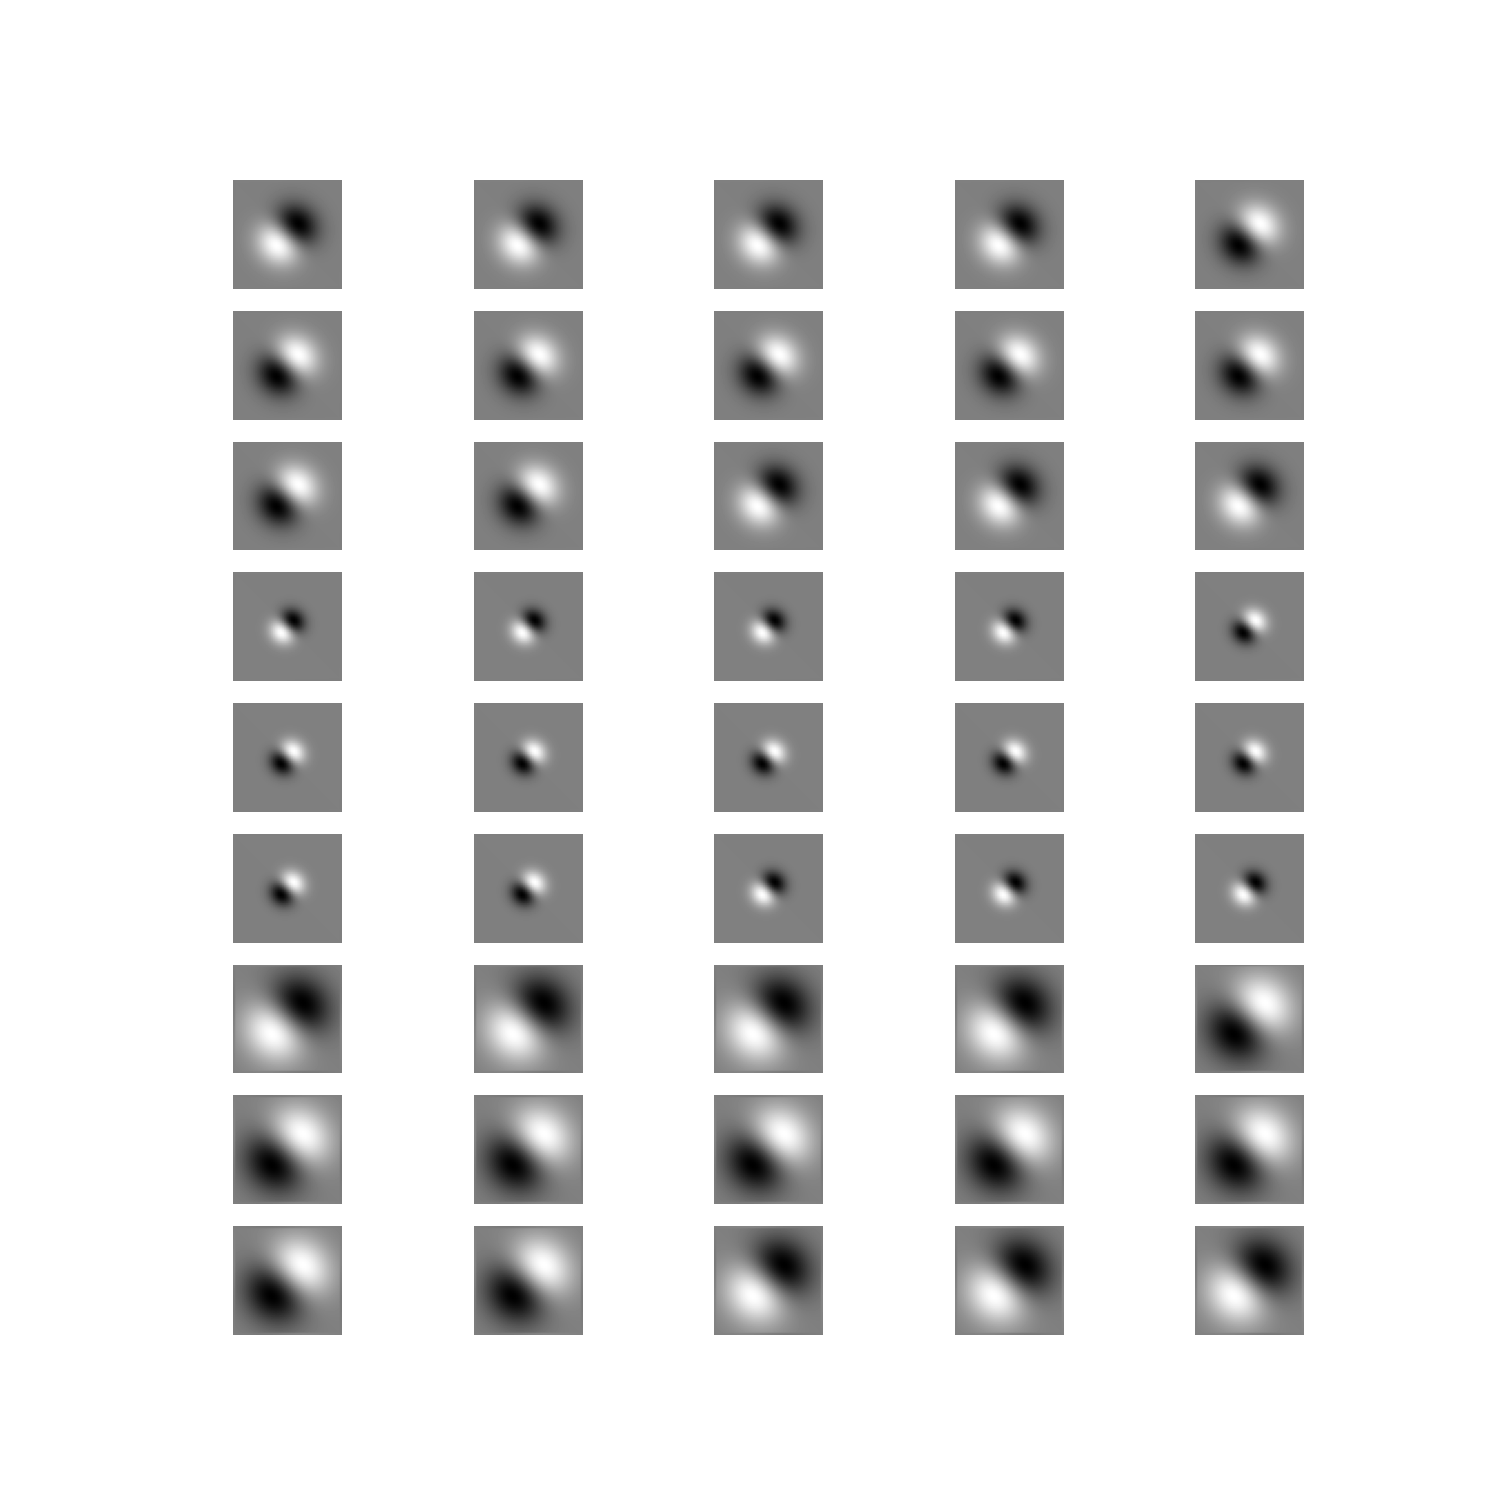

In [4]:
""" 
    Generate Difference of Gaussian Filter Bank: (DoG)
    Display all the filters in this filter bank and save image as DoG.png,
    use command "cv2.imwrite(...)"
    """
dog_filter_bank = create_DOG_filter_bank([7, 4, 10], 49, 15)
print("\nGenerating DOG Bank...\n")
save_DoG(dog_filter_bank)

display.Image("/Users/irakligrigolia/Desktop/WPI 22-23/CV/alohamora/YourDirectoryID_hw0 2/Phase1/Results/DoG.png")


# plt.imshow(dog_filter_bank)
# plt.show()



1. Generate Leung-Malik Filter Bank: (LM)
2. Display all the filters in this filter bank and save image as LM.png,
3. use command "cv2.imwrite(...)"



Generating makeLMfilters Bank...



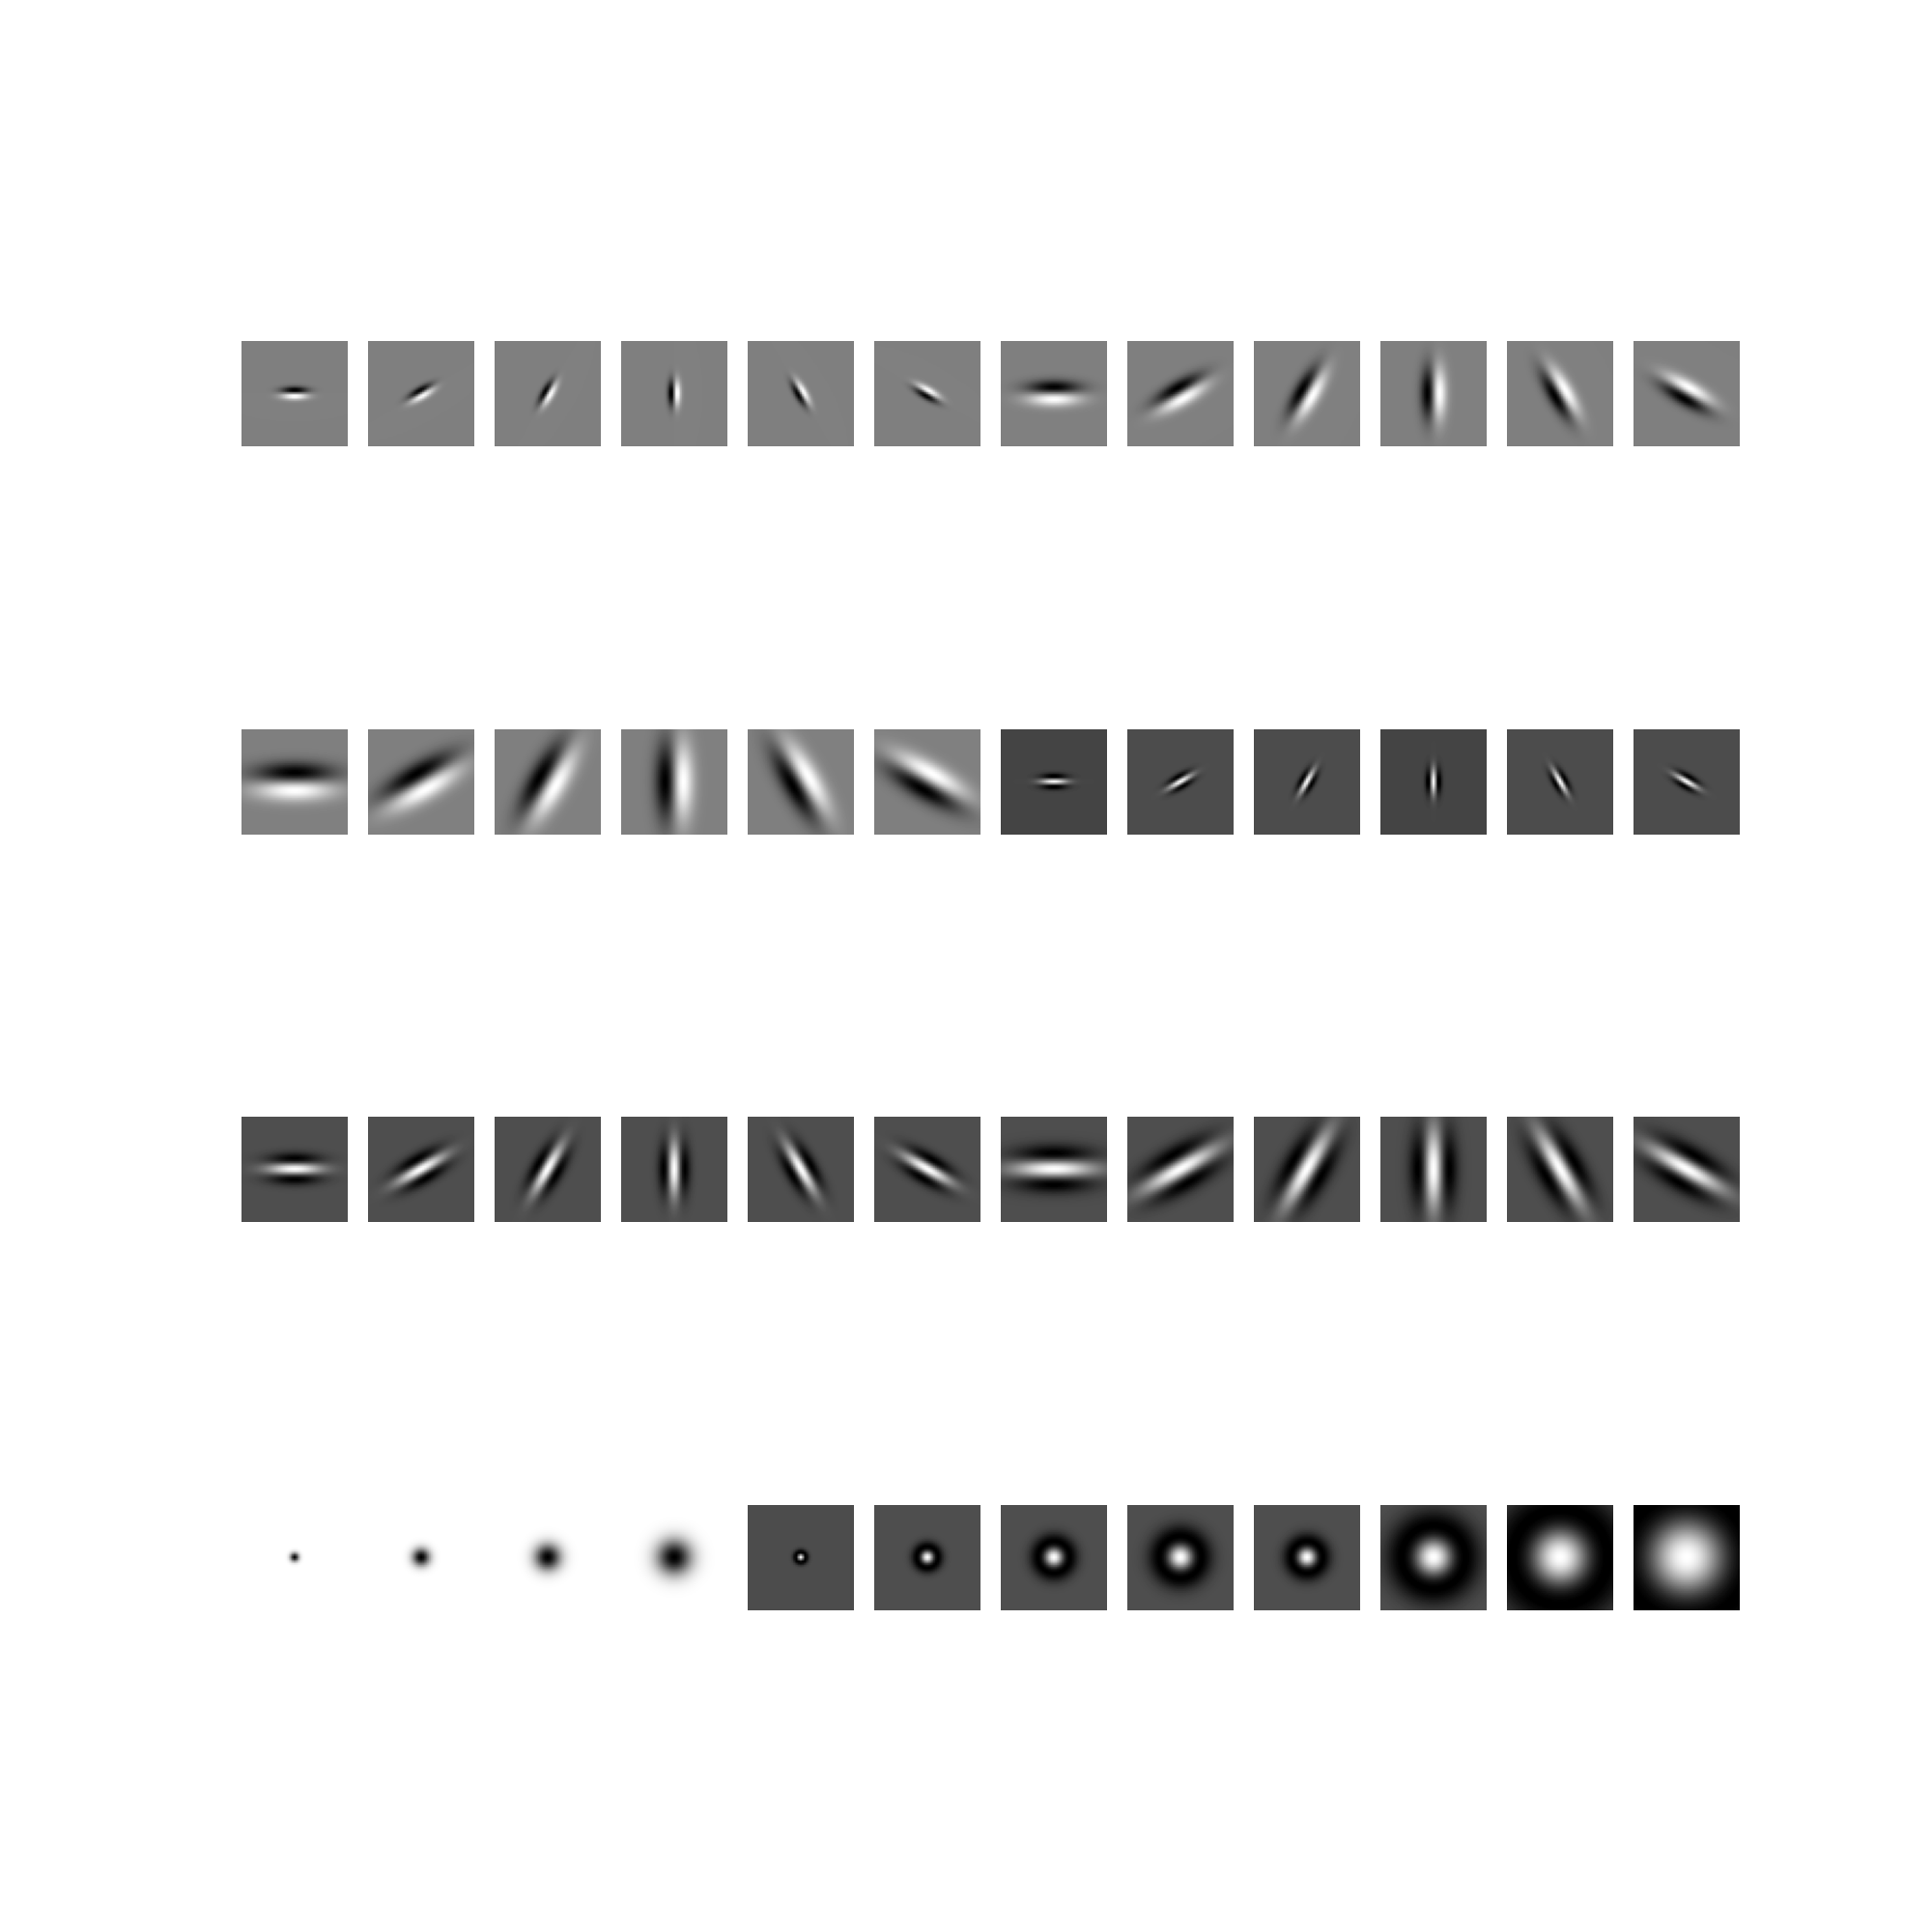

In [5]:
lm_filter_bank = makeLMfilters()
print("\nGenerating makeLMfilters Bank...\n")
save_LM(lm_filter_bank)
display.Image("/Users/irakligrigolia/Desktop/WPI 22-23/CV/alohamora/YourDirectoryID_hw0 2/Phase1/Results/LM.png")



1. Generate Gabor Filter Bank: (Gabor)
2. Display all the filters in this filter bank and save image as Gabor.png,
3. use command "cv2.imwrite(...)"



Generating GABOR Bank...



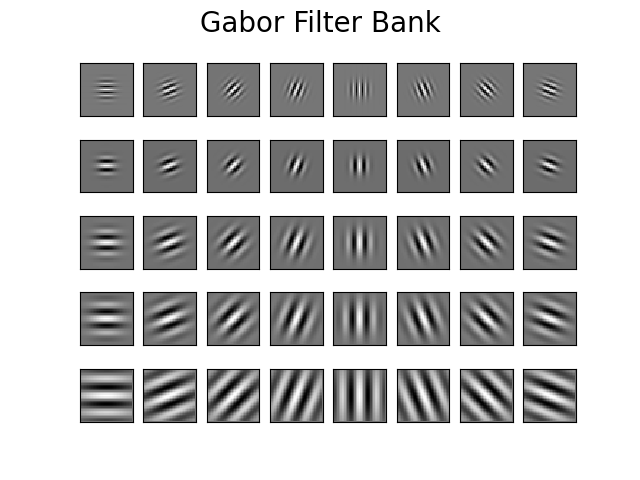

In [6]:
gabor_filter_bank = gaborFilterBank()
print("\nGenerating GABOR Bank...\n")
save_Gabor(gabor_filter_bank)
display.Image("/Users/irakligrigolia/Desktop/WPI 22-23/CV/alohamora/YourDirectoryID_hw0 2/Phase1/Results/Gabor.png")


1. Generate Half-disk masks
2. Display all the Half-disk masks and save image as HDMasks.png,
3. use command "cv2.imwrite(...)"

/var/folders/l7/bxsv4tqj5tj9dd9svxyl2v_h0000gn/T/ipykernel_9613/971397131.py:356: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  rotated = ndi.interpolation.rotate(mask, -i * rotateAngle, reshape=False)
/var/folders/l7/bxsv4tqj5tj9dd9svxyl2v_h0000gn/T/ipykernel_9613/971397131.py:362: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  rotated_p = ndi.interpolation.rotate(mask, -i * rotateAngle - 180, reshape=False)



Generating Half Disk Masks...



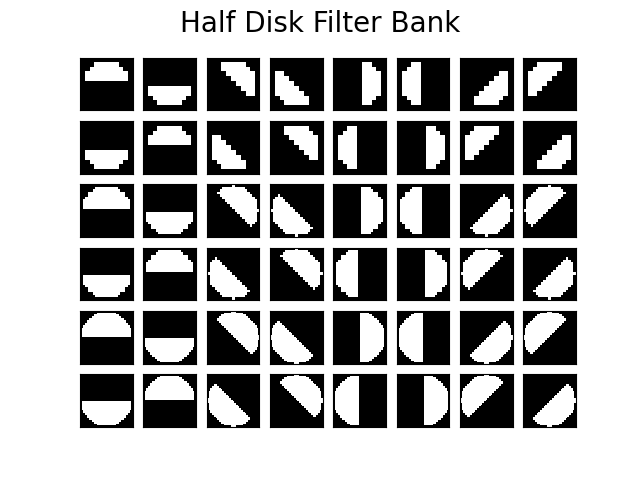

In [7]:
hd_filter_bank = halfDiskMasks([5, 10, 15], 8)
print("\nGenerating Half Disk Masks...\n")
save_HalfDisk(hd_filter_bank)
display.Image("/Users/irakligrigolia/Desktop/WPI 22-23/CV/alohamora/YourDirectoryID_hw0 2/Phase1/Results/HDisk.png")


In [8]:
for i, image in enumerate(all_images):
        print("\nGenerating Texton Maps...\n")
        texton_map = textonMap(64, all_images[i], dog_filter_bank, lm_filter_bank, gabor_filter_bank)
        plt.imsave('./Phase1/Results/Maps/TextonMap_' + str(i + 1) + '.png', texton_map)

        """
		Generate Texton Gradient (Tg)
		Perform Chi-square calculation on Texton Map
		Display Tg and save image as Tg_ImageName.png,
		use command "cv2.imwrite(...)
		"""
        print("\nGenerating Texton Gradients...\n")
        texton_gradient = chi2Gradient(texton_map, 64, hd_filter_bank)
        fig6 = plt.figure()
        # plt.imshow(texton_gradient, cmap='gray')
        # fig6.suptitle("Texton Gradient", fontsize=20)
        plt.imsave('./Phase1/Results/Gradients/Tg_e_' + str(i + 1) + '.png', texton_gradient)
        """
		Generate Brightness Map
		Perform brightness binning 
		"""
        brightness_map = getBrightnessMap(all_images[i])
        plt.imsave('./Phase1/Results/Maps/brightness_map_' + str(i + 1) + '.png', brightness_map, cmap='binary')

        """
		Generate Brightness Gradient (Bg)
		Perform Chi-square calculation on Brightness Map
		Display Bg and save image as Bg_ImageName.png,
		use command "cv2.imwrite(...)"
		"""
        brightness_gradient = chi2Gradient(brightness_map, 16, hd_filter_bank)
        plt.imsave('./Phase1/Results/Gradients/Bg_' + str(i + 1) + '.png', brightness_gradient, cmap='binary')

        """
		Generate Color Map
		Perform color binning or clustering
		"""
        color_map = colorMap(all_images[i])
        plt.imsave('./Phase1/Results/Maps/color_map_' + str(i + 1) +'.png', color_map)

        """
		Generate Color Gradient (Cg)
		Perform Chi-square calculation on Color Map
		Display Cg and save image as Cg_ImageName.png,
		use command "cv2.imwrite(...)"
		"""
        color_gradient = chi2Gradient(color_map, 16, hd_filter_bank)
        plt.imsave('./Phase1/Results/Gradients/Cg_' + str(i + 1) +'.png', color_gradient)

        """
		Read Sobel Baseline
		use command "cv2.imread(...)"
		"""
        sobel_baseLine = cv2.imread('./Phase1/BSDS500/SobelBaseline/' + str(i + 1) +'.png', 0)
        """
		Read Canny Baseline
		use command "cv2.imread(...)"
		"""
        canny_baseLine = cv2.imread('./Phase1/BSDS500/CannyBaseline/' + str(i + 1) +'.png', 0)
        """
		Combine responses to get pb_lite-lite output
		Display pb_liteLite and save image as pb_liteLite_ImageName.png
		use command "cv2.imwrite(...)"
		"""
        pb_lite = (texton_gradient + brightness_gradient + color_gradient) / 3

        pb_lite_out = np.multiply(pb_lite, (0.5 * sobel_baseLine + 0.5  canny_baseLine))
        print("\nSaving pb_lite-Lite Output ...\n")
        plt.imshow(pb_lite_out, cmap='gray')
        plt.imsave('./Phase1/Results/PB-Lite/pb_liteLite_' + str(i + 1) +'.png', pb_lite_out)

SyntaxError: invalid syntax (1937125652.py, line 67)

1. Generate Texton Map
2. Filter image using oriented gaussian filter bank
3. Generate texture ID's using K-means clustering
4. Display texton map and save image as TextonMap_ImageName.png,
5. use command "cv2.imwrite('...)"



Generating Texton Maps...



/Users/irakligrigolia/Desktop/WPI 22-23/CV/alohamora/alohamora/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


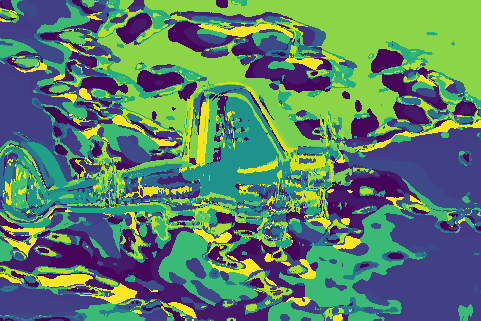

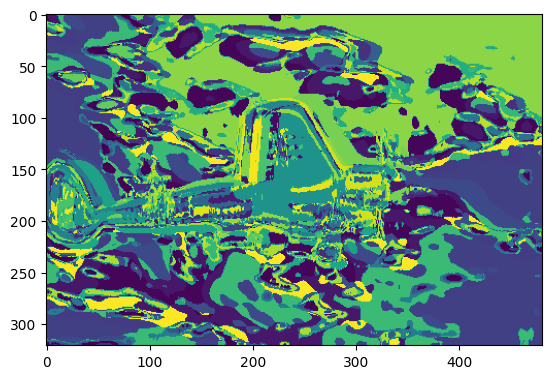

In [10]:
print("\nGenerating Texton Maps...\n")
texton_map = textonMap(64, img1, dog_filter_bank, lm_filter_bank, gabor_filter_bank)
display.Image("/Users/irakligrigolia/Desktop/WPI 22-23/CV/alohamora/YourDirectoryID_hw0 2/Phase1/Results/Maps/texton_map_1.png")

1. Generate Texton Gradient (Tg)
2. Perform Chi-square calculation on Texton Map
3. Display Tg and save image as Tg_ImageName.png,
4. use command "cv2.imwrite(...)"



Generating Texton Gradients...



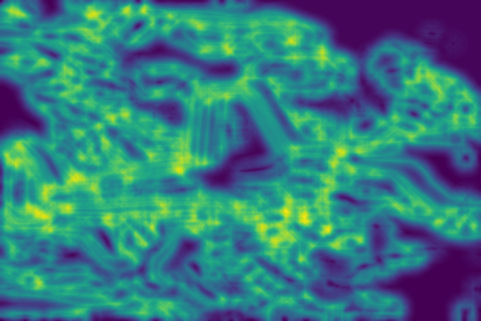

In [11]:
print("\nGenerating Texton Gradients...\n")
texton_gradient = chi2Gradient(texton_map, 64, hd_filter_bank)
display.Image("/Users/irakligrigolia/Desktop/WPI 22-23/CV/alohamora/YourDirectoryID_hw0 2/Phase1/Results/Gradients/T_g_1.png")


1. Generate Brightness Map
2. Perform brightness binning


/Users/irakligrigolia/Desktop/WPI 22-23/CV/alohamora/alohamora/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


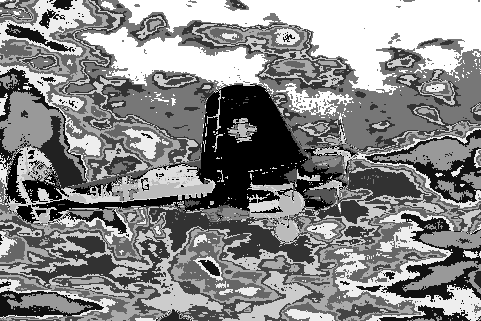

In [12]:
brightness_map = getBrightnessMap(img1)
display.Image("/Users/irakligrigolia/Desktop/WPI 22-23/CV/alohamora/YourDirectoryID_hw0 2/Phase1/Results/Maps/brightness_map_1.png")
   

1. Generate Brightness Gradient (Bg)
2. Perform Chi-square calculation on Brightness Map
3. Display Bg and save image as Bg_ImageName.png,
4. use command "cv2.imwrite(...)"



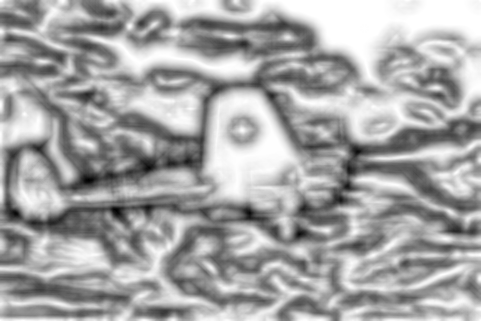

In [13]:
brightness_gradient = chi2Gradient(brightness_map, 16, hd_filter_bank)
display.Image("/Users/irakligrigolia/Desktop/WPI 22-23/CV/alohamora/YourDirectoryID_hw0 2/Phase1/Results/Gradients/B_g_1.png")


1. Generate Color Map
2. Perform color binning or clustering


/Users/irakligrigolia/Desktop/WPI 22-23/CV/alohamora/alohamora/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


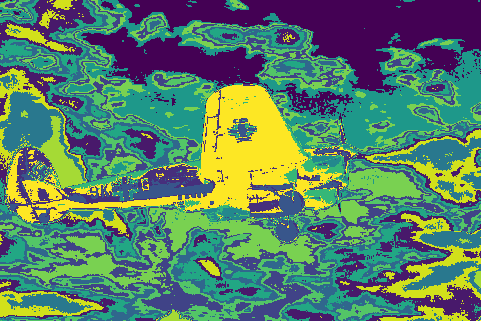

In [14]:
color_map = colorMap(img1)
display.Image("/Users/irakligrigolia/Desktop/WPI 22-23/CV/alohamora/YourDirectoryID_hw0 2/Phase1/Results/Maps/color_map_1.png")





1. Generate Color Gradient (Cg)
2. Perform Chi-square calculation on Color Map
3. Display Cg and save image as Cg_ImageName.png,
4. use command "cv2.imwrite(...)"



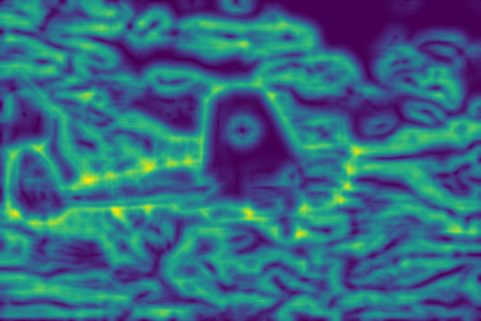

In [15]:
color_gradient = chi2Gradient(color_map, 16, hd_filter_bank)
display.Image("/Users/irakligrigolia/Desktop/WPI 22-23/CV/alohamora/YourDirectoryID_hw0 2/Phase1/Results/Gradients/C_g_1.png")



1. Read Sobel Baseline
2. use command "cv2.imread(...)"


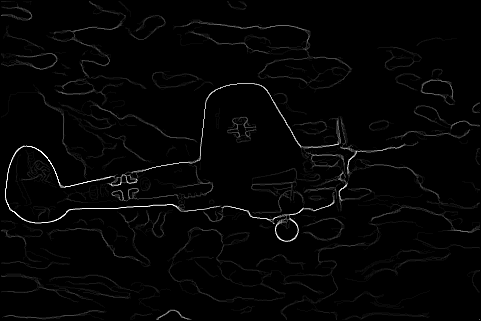

In [16]:
display.Image("/Users/irakligrigolia/Desktop/WPI 22-23/CV/alohamora/YourDirectoryID_hw0 2/Phase1/BSDS500/CannyBaseline/1.png")





1. Read Canny Baseline
2. use command "cv2.imread(...)"



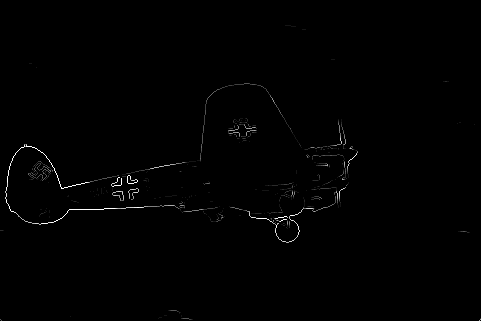

In [20]:
display.Image("/Users/irakligrigolia/Desktop/WPI 22-23/CV/alohamora/YourDirectoryID_hw0 2/Phase1/BSDS500/SobelBaseline/1.png")




1. Combine responses to get pb-lite output
2. Display PbLite and save image as PbLite_ImageName.png
3. use command "cv2.imwrite(...)"



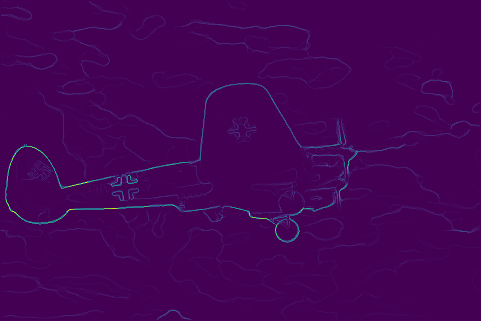

In [18]:
display.Image("/Users/irakligrigolia/Desktop/WPI 22-23/CV/alohamora/YourDirectoryID_hw0 2/Phase1/Results/PB-Lite/outputPB_1.png")

## Phase 2

### Neural Network Construction

In [27]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def loss_fn(out, labels):
    ###############################################
    # Fill your loss function of choice here!
    ###############################################
    wrapper = nn.CrossEntropyLoss()
    loss = wrapper(out,labels)
    return loss

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = loss_fn(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = loss_fn(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'loss': loss.detach(), 'acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'loss': epoch_loss.item(), 'acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], loss: {:.4f}, acc: {:.4f}".format(epoch, result['loss'], result['acc']))



class CIFAR10Model(ImageClassificationBase):
    def __init__(self, InputSize, OutputSize):
        super().__init__()
        """
        Inputs: 
        InputSize - Size of the Input
        OutputSize - Size of the Output
        """
        #############################
        # Fill your network initialization of choice here!
        #############################
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 16, 3, padding=1),  
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2,2), # Output (16 x 16 x 32)
            nn.Conv2d(32, 64, 3, padding=1), 
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2,2), 
            nn.Flatten(),
            nn.Linear(8*8*128,100),
            nn.ReLU(),
            nn.Linear(100,10)
        )
            
            #updated Base model
          
#             nn.Conv2d(3, 32, 3, padding=1),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Conv2d(32, 64, 3, padding=1),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.MaxPool2d(2,2),
#             nn.Conv2d(64, 128, 3, padding=1),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Conv2d(128, 256, 3, padding=1),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.MaxPool2d(2,2),
#             nn.Flatten(),
#             nn.Linear(8*8*256,100),
#             nn.ReLU(),
#             nn.Linear(100,10)
#             )

            
            
          
      
    def forward(self, xb):
        """
        Input:
        xb is a MiniBatch of the current image
        Outputs:
        out - output of the network
        """
        #############################
        # Fill your network structure of choice here!
        #############################
        out = self.network(xb)
        return out

In [28]:
import time
import glob
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

def tic():
    """
    Function to start timer
    Tries to mimic tic() toc() in MATLAB
    """
    StartTime = time.time()
    return StartTime

def toc(StartTime):
    """
    Function to stop timer
    Tries to mimic tic() toc() in MATLAB
    """
    return time.time() - StartTime

def FindLatestModel(CheckPointPath):
    """
    Finds Latest Model in CheckPointPath
    Inputs:
    CheckPointPath - Path where you have stored checkpoints
    Outputs:
    LatestFile - File Name of the latest checkpoint
    """
    FileList = glob.glob(CheckPointPath + '*.ckpt.index') # * means all if need specific format then *.csv
    LatestFile = max(FileList, key=os.path.getctime)
    # Strip everything else except needed information
    LatestFile = LatestFile.replace(CheckPointPath, '')
    LatestFile = LatestFile.replace('.ckpt.index', '')
    return LatestFile


def convertToOneHot(vector, NumClasses):
    """
    Inputs:
    vector - vector of argmax indexes
    NumClasses - Number of classes
    """
    return np.equal.outer(vector, np.arange(NumClasses)).astype(np.float)

### Train your neural network

In [30]:


import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torch.optim import AdamW, SGD
from torchvision.datasets import CIFAR10
import cv2
import sys
import os
import numpy as np
import random
import skimage
import PIL
import os
import glob
import random
from skimage import data, exposure, img_as_float
import matplotlib.pyplot as plt
import numpy as np
import time
from torchvision.transforms import ToTensor
import argparse
import shutil
import string
#from termcolor import colored, cprint
import math as m
from tqdm.notebook import tqdm

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Running on device: {device}")

def SetupAll(CheckPointPath):
    """
    Inputs: 
    CheckPointPath - Path to save checkpoints/model
    Outputs:
    SaveCheckPoint - Save checkpoint every SaveCheckPoint iteration in every epoch, checkpoint saved automatically after every epoch
    ImageSize - Size of the image
    NumTrainSamples - length(Train)
    TrainLabels - Labels corresponding to Train
    NumClasses - Number of classes
    """
    # Read and Setup Labels
    LabelsPathTrain = 'content/data/TxtFiles/LabelsTrain.txt'
    TrainLabels = ReadLabels(LabelsPathTrain)

    # If CheckPointPath doesn't exist make the path
    if(not (os.path.isdir(CheckPointPath))):
       os.makedirs(CheckPointPath)
        
    # Save checkpoint every SaveCheckPoint iteration in every epoch, checkpoint saved automatically after every epoch
    SaveCheckPoint = 100 
    
    # Image Input Shape
    ImageSize = [32, 32, 3]
    NumTrainSamples = len(TrainSet)

    # Number of classes
    NumClasses = 10

    return SaveCheckPoint, ImageSize, NumTrainSamples, TrainLabels, NumClasses


def ReadLabels(LabelsPathTrain):
    if(not (os.path.isfile(LabelsPathTrain))):
        print('ERROR: Train Labels do not exist in '+LabelsPathTrain)
        sys.exit()
    else:
        TrainLabels = open(LabelsPathTrain, 'r')
        TrainLabels = TrainLabels.read()
        TrainLabels = map(float, TrainLabels.split())

    return TrainLabels
    

def ReadDirNames(ReadPath):
    """
    Inputs: 
    ReadPath is the path of the file you want to read
    Outputs:
    DirNames is the data loaded from /content/data/TxtFiles/DirNames.txt which has full path to all image files without extension
    """
    # Read text files
    DirNames = open(ReadPath, 'r')
    DirNames = DirNames.read()
    DirNames = DirNames.split()
    return DirNames

    
def GenerateBatch(TrainSet, TrainLabels, ImageSize, MiniBatchSize):
    """
    Inputs: 
    TrainSet - Variable with Subfolder paths to train files
    NOTE that Train can be replaced by Val/Test for generating batch corresponding to validation (held-out testing in this case)/testing
    TrainLabels - Labels corresponding to Train
    NOTE that TrainLabels can be replaced by Val/TestLabels for generating batch corresponding to validation (held-out testing in this case)/testing
    ImageSize is the Size of the Image
    MiniBatchSize is the size of the MiniBatch
   
    Outputs:
    I1Batch - Batch of images
    LabelBatch - Batch of one-hot encoded labels 
    """
    I1Batch = []
    LabelBatch = []
    
    ImageNum = 0
    while ImageNum < MiniBatchSize:
        # Generate random image
        RandIdx = random.randint(0, len(TrainSet)-1)
        
        ImageNum += 1
    	
    	  ##########################################################
    	  # Add any standardization or data augmentation here!
    	  ##########################################################

        I1, Label = TrainSet[RandIdx]

        # Append All Images and Mask
        I1Batch.append(I1)
        LabelBatch.append(torch.tensor(Label))
        
    return torch.stack(I1Batch).to(device), torch.stack(LabelBatch).to(device)


def PrettyPrint(NumEpochs, DivTrain, MiniBatchSize, NumTrainSamples, LatestFile):
    """
    Prints all stats with all arguments
    """
    print('Number of Epochs Training will run for ' + str(NumEpochs))
    print('Factor of reduction in training data is ' + str(DivTrain))
    print('Mini Batch Size ' + str(MiniBatchSize))
    print('Number of Training Images ' + str(NumTrainSamples))
    if LatestFile is not None:
        print('Loading latest checkpoint with the name ' + LatestFile)              

def TrainOperation(TrainLabels, NumTrainSamples, ImageSize,
                   NumEpochs, MiniBatchSize, SaveCheckPoint, CheckPointPath,
                   DivTrain, LatestFile, TrainSet, LogsPath):
    """
    Inputs: 
    TrainLabels - Labels corresponding to Train/Test
    NumTrainSamples - length(Train)
    ImageSize - Size of the image
    NumEpochs - Number of passes through the Train data
    MiniBatchSize is the size of the MiniBatch
    SaveCheckPoint - Save checkpoint every SaveCheckPoint iteration in every epoch, checkpoint saved automatically after every epoch
    CheckPointPath - Path to save checkpoints/model
    DivTrain - Divide the data by this number for Epoch calculation, use if you have a lot of dataor for debugging code
    LatestFile - Latest checkpointfile to continue training
    TrainSet - The training dataset
    LogsPath - Path to save Tensorboard Logs
    Outputs:
    Saves Trained network in CheckPointPath and Logs to LogsPath
    """
#     CIFAR10Model(InputSize=3*32*32,OutputSize=10)
    # Initialize the model
    model = CIFAR10Model(InputSize=3*32*32,OutputSize=10)
#     model = model.to(device)
    ###############################################
    # Fill your optimizer of choice here!
    ###############################################
    Optimizer = SGD(model.parameters(), lr=1e-3)
    # Tensorboard
    # Create a summary to monitor loss tensor
    Writer = SummaryWriter(LogsPath)

    if LatestFile is not None:
        CheckPoint = torch.load(CheckPointPath + LatestFile + '.ckpt')
        # Extract only numbers from the name
        StartEpoch = int(''.join(c for c in LatestFile.split('a')[0] if c.isdigit()))
        model.load_state_dict(CheckPoint['model_state_dict'])
        print('Loaded latest checkpoint with the name ' + LatestFile + '....')
    else:
        StartEpoch = 0
        print('New model initialized....')
    
    model.train()
    for Epochs in tqdm(range(StartEpoch, NumEpochs)):
        NumIterationsPerEpoch = int(NumTrainSamples/MiniBatchSize/DivTrain)
        for PerEpochCounter in tqdm(range(NumIterationsPerEpoch)):
            Batch = GenerateBatch(TrainSet, TrainLabels, ImageSize, MiniBatchSize)
            
            # Predict output with forward pass
            LossThisBatch = model.training_step(Batch)

            Optimizer.zero_grad()
            LossThisBatch.backward()
            Optimizer.step()
            
            # Save checkpoint every some SaveCheckPoint's iterations
            if PerEpochCounter % SaveCheckPoint == 0:
                # Save the Model learnt in this epoch
                SaveName =  CheckPointPath + str(Epochs) + 'a' + str(PerEpochCounter) + 'model.ckpt'
                
                torch.save({'epoch': Epochs,'model_state_dict': model.state_dict(),'optimizer_state_dict': Optimizer.state_dict(),'loss': LossThisBatch}, SaveName)
                print('\n' + SaveName + ' Model Saved...')

            result = model.validation_step(Batch)
            model.epoch_end(Epochs*NumIterationsPerEpoch + PerEpochCounter, result)
            # Tensorboard
            Writer.add_scalar('Loss', result["loss"], Epochs*NumIterationsPerEpoch + PerEpochCounter)
            Writer.add_scalar('Accuracy', result["acc"], Epochs*NumIterationsPerEpoch + PerEpochCounter)
            # If you don't flush the tensorboard doesn't update until a lot of iterations!
            Writer.flush()

        # Save model every epoch
        SaveName = CheckPointPath + str(Epochs) + 'model.ckpt'
        torch.save({'epoch': Epochs,'model_state_dict': model.state_dict(),'optimizer_state_dict': Optimizer.state_dict(),'loss': LossThisBatch}, SaveName)
        print('\n' + SaveName + ' Model Saved...')
        


# Default Hyperparameters
NumEpochs = 10
TrainSet = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=ToTensor())
DivTrain = 1.0
MiniBatchSize = 16
LoadCheckPoint = 0
CheckPointPath = "content/data/Checkpoints/"
LogsPath = "content/data/Logs"

# Setup all needed parameters including file reading
SaveCheckPoint, ImageSize, NumTrainSamples, TrainLabels, NumClasses = SetupAll(CheckPointPath)

# Find Latest Checkpoint File
if LoadCheckPoint==1:
    LatestFile = FindLatestModel(CheckPointPath)
else:
    LatestFile = None

# Pretty print stats
PrettyPrint(NumEpochs, DivTrain, MiniBatchSize, NumTrainSamples, LatestFile)

TrainOperation(TrainLabels, NumTrainSamples, ImageSize,
                NumEpochs, MiniBatchSize, SaveCheckPoint, CheckPointPath,
                DivTrain, LatestFile, TrainSet, LogsPath)



Running on device: cpu
Files already downloaded and verified
Number of Epochs Training will run for 10
Factor of reduction in training data is 1.0
Mini Batch Size 16
Number of Training Images 50000
New model initialized....


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]


content/data/Checkpoints/0a0model.ckpt Model Saved...
Epoch [0], loss: 2.3065, acc: 0.1250
Epoch [1], loss: 2.2786, acc: 0.2500
Epoch [2], loss: 2.3134, acc: 0.0625
Epoch [3], loss: 2.3263, acc: 0.0000
Epoch [4], loss: 2.2993, acc: 0.0625
Epoch [5], loss: 2.3283, acc: 0.0625
Epoch [6], loss: 2.2981, acc: 0.1875
Epoch [7], loss: 2.2884, acc: 0.1875
Epoch [8], loss: 2.3164, acc: 0.0000
Epoch [9], loss: 2.3131, acc: 0.0000
Epoch [10], loss: 2.2940, acc: 0.1250
Epoch [11], loss: 2.2991, acc: 0.0625
Epoch [12], loss: 2.3089, acc: 0.1250
Epoch [13], loss: 2.3184, acc: 0.0000
Epoch [14], loss: 2.2973, acc: 0.1875
Epoch [15], loss: 2.3036, acc: 0.0625
Epoch [16], loss: 2.2741, acc: 0.2500
Epoch [17], loss: 2.3265, acc: 0.0000
Epoch [18], loss: 2.2912, acc: 0.1250
Epoch [19], loss: 2.3005, acc: 0.0625
Epoch [20], loss: 2.3038, acc: 0.1250
Epoch [21], loss: 2.3051, acc: 0.1250
Epoch [22], loss: 2.3007, acc: 0.1250
Epoch [23], loss: 2.3294, acc: 0.0000
Epoch [24], loss: 2.3070, acc: 0.0625
Epoch

Epoch [213], loss: 2.2947, acc: 0.1250
Epoch [214], loss: 2.3209, acc: 0.0625
Epoch [215], loss: 2.3113, acc: 0.0625
Epoch [216], loss: 2.2897, acc: 0.1250
Epoch [217], loss: 2.3032, acc: 0.0625
Epoch [218], loss: 2.2681, acc: 0.3750
Epoch [219], loss: 2.2791, acc: 0.1250
Epoch [220], loss: 2.3280, acc: 0.0000
Epoch [221], loss: 2.2836, acc: 0.1250
Epoch [222], loss: 2.2846, acc: 0.2500
Epoch [223], loss: 2.2893, acc: 0.1250
Epoch [224], loss: 2.3099, acc: 0.0625
Epoch [225], loss: 2.3079, acc: 0.1250
Epoch [226], loss: 2.2970, acc: 0.0625
Epoch [227], loss: 2.2916, acc: 0.1250
Epoch [228], loss: 2.3076, acc: 0.0625
Epoch [229], loss: 2.3041, acc: 0.0625
Epoch [230], loss: 2.3095, acc: 0.0625
Epoch [231], loss: 2.3118, acc: 0.0625
Epoch [232], loss: 2.3046, acc: 0.0625
Epoch [233], loss: 2.2893, acc: 0.2500
Epoch [234], loss: 2.3192, acc: 0.0000
Epoch [235], loss: 2.3200, acc: 0.0625
Epoch [236], loss: 2.3167, acc: 0.0625
Epoch [237], loss: 2.2823, acc: 0.1250
Epoch [238], loss: 2.3204

Epoch [424], loss: 2.3159, acc: 0.1250
Epoch [425], loss: 2.3079, acc: 0.0000
Epoch [426], loss: 2.2969, acc: 0.1250
Epoch [427], loss: 2.3014, acc: 0.1250
Epoch [428], loss: 2.3002, acc: 0.0000
Epoch [429], loss: 2.2929, acc: 0.2500
Epoch [430], loss: 2.3005, acc: 0.0625
Epoch [431], loss: 2.3039, acc: 0.1250
Epoch [432], loss: 2.3050, acc: 0.1875
Epoch [433], loss: 2.2864, acc: 0.1875
Epoch [434], loss: 2.3162, acc: 0.1250
Epoch [435], loss: 2.3045, acc: 0.1250
Epoch [436], loss: 2.3103, acc: 0.1875
Epoch [437], loss: 2.3007, acc: 0.1250
Epoch [438], loss: 2.3055, acc: 0.0625
Epoch [439], loss: 2.2701, acc: 0.3750
Epoch [440], loss: 2.2808, acc: 0.2500
Epoch [441], loss: 2.3009, acc: 0.0625
Epoch [442], loss: 2.3101, acc: 0.1250
Epoch [443], loss: 2.3065, acc: 0.0000
Epoch [444], loss: 2.3037, acc: 0.0625
Epoch [445], loss: 2.3112, acc: 0.0625
Epoch [446], loss: 2.2994, acc: 0.0625
Epoch [447], loss: 2.2950, acc: 0.0625
Epoch [448], loss: 2.3314, acc: 0.0000
Epoch [449], loss: 2.2929

Epoch [632], loss: 2.3107, acc: 0.1875
Epoch [633], loss: 2.3133, acc: 0.0625
Epoch [634], loss: 2.2794, acc: 0.2500
Epoch [635], loss: 2.2972, acc: 0.1875
Epoch [636], loss: 2.3072, acc: 0.0625
Epoch [637], loss: 2.2962, acc: 0.0625
Epoch [638], loss: 2.3016, acc: 0.1250
Epoch [639], loss: 2.2879, acc: 0.1250
Epoch [640], loss: 2.3110, acc: 0.1250
Epoch [641], loss: 2.2964, acc: 0.1875
Epoch [642], loss: 2.3016, acc: 0.0000
Epoch [643], loss: 2.2982, acc: 0.1250
Epoch [644], loss: 2.3268, acc: 0.0000
Epoch [645], loss: 2.3086, acc: 0.1250
Epoch [646], loss: 2.3102, acc: 0.0625
Epoch [647], loss: 2.3015, acc: 0.1250
Epoch [648], loss: 2.2901, acc: 0.2500
Epoch [649], loss: 2.3182, acc: 0.0625
Epoch [650], loss: 2.3070, acc: 0.0625
Epoch [651], loss: 2.3119, acc: 0.1250
Epoch [652], loss: 2.3126, acc: 0.0000
Epoch [653], loss: 2.3048, acc: 0.1875
Epoch [654], loss: 2.2926, acc: 0.1875
Epoch [655], loss: 2.3089, acc: 0.1250
Epoch [656], loss: 2.3029, acc: 0.1250
Epoch [657], loss: 2.3269

Epoch [841], loss: 2.3081, acc: 0.1875
Epoch [842], loss: 2.3214, acc: 0.0000
Epoch [843], loss: 2.3089, acc: 0.1250
Epoch [844], loss: 2.3148, acc: 0.0625
Epoch [845], loss: 2.3021, acc: 0.0625
Epoch [846], loss: 2.2965, acc: 0.0625
Epoch [847], loss: 2.2943, acc: 0.1250
Epoch [848], loss: 2.2932, acc: 0.1250
Epoch [849], loss: 2.2751, acc: 0.3750
Epoch [850], loss: 2.3141, acc: 0.0625
Epoch [851], loss: 2.3163, acc: 0.1250
Epoch [852], loss: 2.2824, acc: 0.3125
Epoch [853], loss: 2.3229, acc: 0.0000
Epoch [854], loss: 2.3066, acc: 0.0625
Epoch [855], loss: 2.2982, acc: 0.1875
Epoch [856], loss: 2.2898, acc: 0.1250
Epoch [857], loss: 2.3021, acc: 0.1250
Epoch [858], loss: 2.2895, acc: 0.0625
Epoch [859], loss: 2.2919, acc: 0.1250
Epoch [860], loss: 2.3096, acc: 0.1250
Epoch [861], loss: 2.2769, acc: 0.2500
Epoch [862], loss: 2.2877, acc: 0.1875
Epoch [863], loss: 2.2979, acc: 0.0625
Epoch [864], loss: 2.3089, acc: 0.0625
Epoch [865], loss: 2.3113, acc: 0.0000
Epoch [866], loss: 2.3033

Epoch [1051], loss: 2.3156, acc: 0.0000
Epoch [1052], loss: 2.3137, acc: 0.0625
Epoch [1053], loss: 2.3102, acc: 0.0000
Epoch [1054], loss: 2.3212, acc: 0.0000
Epoch [1055], loss: 2.3108, acc: 0.0000
Epoch [1056], loss: 2.2830, acc: 0.2500
Epoch [1057], loss: 2.3100, acc: 0.0000
Epoch [1058], loss: 2.3062, acc: 0.1250
Epoch [1059], loss: 2.3193, acc: 0.0000
Epoch [1060], loss: 2.3106, acc: 0.0625
Epoch [1061], loss: 2.2761, acc: 0.2500
Epoch [1062], loss: 2.3013, acc: 0.1250
Epoch [1063], loss: 2.2969, acc: 0.1250
Epoch [1064], loss: 2.2982, acc: 0.1875
Epoch [1065], loss: 2.3189, acc: 0.0625
Epoch [1066], loss: 2.3049, acc: 0.0000
Epoch [1067], loss: 2.2997, acc: 0.1250
Epoch [1068], loss: 2.3145, acc: 0.0625
Epoch [1069], loss: 2.3197, acc: 0.0625
Epoch [1070], loss: 2.3070, acc: 0.0625
Epoch [1071], loss: 2.3009, acc: 0.1875
Epoch [1072], loss: 2.3053, acc: 0.0000
Epoch [1073], loss: 2.2900, acc: 0.1875
Epoch [1074], loss: 2.3010, acc: 0.1250
Epoch [1075], loss: 2.2838, acc: 0.2500


Epoch [1256], loss: 2.2855, acc: 0.1875
Epoch [1257], loss: 2.2932, acc: 0.1250
Epoch [1258], loss: 2.3199, acc: 0.0625
Epoch [1259], loss: 2.3003, acc: 0.0625
Epoch [1260], loss: 2.3221, acc: 0.0000
Epoch [1261], loss: 2.3017, acc: 0.1250
Epoch [1262], loss: 2.3090, acc: 0.0000
Epoch [1263], loss: 2.2900, acc: 0.1250
Epoch [1264], loss: 2.3146, acc: 0.0625
Epoch [1265], loss: 2.2989, acc: 0.1250
Epoch [1266], loss: 2.3101, acc: 0.0625
Epoch [1267], loss: 2.3022, acc: 0.0625
Epoch [1268], loss: 2.2999, acc: 0.1250
Epoch [1269], loss: 2.3017, acc: 0.0625
Epoch [1270], loss: 2.2923, acc: 0.1250
Epoch [1271], loss: 2.2884, acc: 0.1875
Epoch [1272], loss: 2.3073, acc: 0.0625
Epoch [1273], loss: 2.2968, acc: 0.0625
Epoch [1274], loss: 2.3085, acc: 0.0000
Epoch [1275], loss: 2.3032, acc: 0.1875
Epoch [1276], loss: 2.2962, acc: 0.1875
Epoch [1277], loss: 2.2960, acc: 0.2500
Epoch [1278], loss: 2.3061, acc: 0.0625
Epoch [1279], loss: 2.2902, acc: 0.1250
Epoch [1280], loss: 2.3051, acc: 0.1250


Epoch [1461], loss: 2.3067, acc: 0.0625
Epoch [1462], loss: 2.3018, acc: 0.1250
Epoch [1463], loss: 2.3009, acc: 0.0625
Epoch [1464], loss: 2.2864, acc: 0.1875
Epoch [1465], loss: 2.2907, acc: 0.1250
Epoch [1466], loss: 2.3080, acc: 0.1250
Epoch [1467], loss: 2.3102, acc: 0.1250
Epoch [1468], loss: 2.2901, acc: 0.1250
Epoch [1469], loss: 2.3050, acc: 0.0625
Epoch [1470], loss: 2.3051, acc: 0.1250
Epoch [1471], loss: 2.2936, acc: 0.1875
Epoch [1472], loss: 2.3029, acc: 0.0625
Epoch [1473], loss: 2.2819, acc: 0.1875
Epoch [1474], loss: 2.3054, acc: 0.1250
Epoch [1475], loss: 2.3104, acc: 0.1875
Epoch [1476], loss: 2.3016, acc: 0.1250
Epoch [1477], loss: 2.2993, acc: 0.0625
Epoch [1478], loss: 2.3003, acc: 0.1250
Epoch [1479], loss: 2.3117, acc: 0.0000
Epoch [1480], loss: 2.3015, acc: 0.0625
Epoch [1481], loss: 2.3080, acc: 0.0000
Epoch [1482], loss: 2.3083, acc: 0.0625
Epoch [1483], loss: 2.2865, acc: 0.0625
Epoch [1484], loss: 2.2980, acc: 0.1250
Epoch [1485], loss: 2.2995, acc: 0.1250


Epoch [1666], loss: 2.3007, acc: 0.1250
Epoch [1667], loss: 2.2974, acc: 0.0625
Epoch [1668], loss: 2.3149, acc: 0.0625
Epoch [1669], loss: 2.2975, acc: 0.0625
Epoch [1670], loss: 2.2872, acc: 0.0625
Epoch [1671], loss: 2.3083, acc: 0.0625
Epoch [1672], loss: 2.3104, acc: 0.0000
Epoch [1673], loss: 2.3064, acc: 0.1250
Epoch [1674], loss: 2.3077, acc: 0.0625
Epoch [1675], loss: 2.3068, acc: 0.1250
Epoch [1676], loss: 2.3056, acc: 0.0625
Epoch [1677], loss: 2.2937, acc: 0.2500
Epoch [1678], loss: 2.3045, acc: 0.0625
Epoch [1679], loss: 2.3142, acc: 0.0000
Epoch [1680], loss: 2.3069, acc: 0.0000
Epoch [1681], loss: 2.3192, acc: 0.0000
Epoch [1682], loss: 2.2974, acc: 0.1875
Epoch [1683], loss: 2.2963, acc: 0.1875
Epoch [1684], loss: 2.3123, acc: 0.1250
Epoch [1685], loss: 2.3168, acc: 0.0625
Epoch [1686], loss: 2.2892, acc: 0.2500
Epoch [1687], loss: 2.2936, acc: 0.1250
Epoch [1688], loss: 2.3077, acc: 0.1250
Epoch [1689], loss: 2.3033, acc: 0.0000
Epoch [1690], loss: 2.3089, acc: 0.0625


Epoch [1871], loss: 2.3092, acc: 0.0625
Epoch [1872], loss: 2.3014, acc: 0.0625
Epoch [1873], loss: 2.3112, acc: 0.0625
Epoch [1874], loss: 2.2914, acc: 0.1250
Epoch [1875], loss: 2.2998, acc: 0.0625
Epoch [1876], loss: 2.3015, acc: 0.1875
Epoch [1877], loss: 2.3160, acc: 0.0000
Epoch [1878], loss: 2.3270, acc: 0.0000
Epoch [1879], loss: 2.3001, acc: 0.1250
Epoch [1880], loss: 2.3139, acc: 0.1250
Epoch [1881], loss: 2.2961, acc: 0.1250
Epoch [1882], loss: 2.3136, acc: 0.0000
Epoch [1883], loss: 2.3175, acc: 0.0625
Epoch [1884], loss: 2.3145, acc: 0.0625
Epoch [1885], loss: 2.2826, acc: 0.1250
Epoch [1886], loss: 2.2939, acc: 0.1250
Epoch [1887], loss: 2.2827, acc: 0.1875
Epoch [1888], loss: 2.2927, acc: 0.0625
Epoch [1889], loss: 2.2796, acc: 0.3750
Epoch [1890], loss: 2.3139, acc: 0.0625
Epoch [1891], loss: 2.3041, acc: 0.1875
Epoch [1892], loss: 2.3147, acc: 0.0625
Epoch [1893], loss: 2.3100, acc: 0.1875
Epoch [1894], loss: 2.3118, acc: 0.1250
Epoch [1895], loss: 2.2951, acc: 0.0625


Epoch [2076], loss: 2.3031, acc: 0.0625
Epoch [2077], loss: 2.3010, acc: 0.1875
Epoch [2078], loss: 2.3173, acc: 0.0625
Epoch [2079], loss: 2.3036, acc: 0.1250
Epoch [2080], loss: 2.2896, acc: 0.2500
Epoch [2081], loss: 2.3047, acc: 0.0625
Epoch [2082], loss: 2.2938, acc: 0.1250
Epoch [2083], loss: 2.3094, acc: 0.0000
Epoch [2084], loss: 2.3160, acc: 0.0000
Epoch [2085], loss: 2.3080, acc: 0.0000
Epoch [2086], loss: 2.3026, acc: 0.1250
Epoch [2087], loss: 2.2969, acc: 0.1250
Epoch [2088], loss: 2.2984, acc: 0.0625
Epoch [2089], loss: 2.3010, acc: 0.1250
Epoch [2090], loss: 2.2991, acc: 0.0625
Epoch [2091], loss: 2.3018, acc: 0.0000
Epoch [2092], loss: 2.2794, acc: 0.1875
Epoch [2093], loss: 2.2988, acc: 0.1250
Epoch [2094], loss: 2.2897, acc: 0.1250
Epoch [2095], loss: 2.3007, acc: 0.0625
Epoch [2096], loss: 2.2877, acc: 0.1250
Epoch [2097], loss: 2.3102, acc: 0.1250
Epoch [2098], loss: 2.2960, acc: 0.1250
Epoch [2099], loss: 2.2888, acc: 0.1250

content/data/Checkpoints/0a2100model.ck

Epoch [2281], loss: 2.2969, acc: 0.1250
Epoch [2282], loss: 2.2998, acc: 0.0625
Epoch [2283], loss: 2.3123, acc: 0.0000
Epoch [2284], loss: 2.2965, acc: 0.1250
Epoch [2285], loss: 2.3146, acc: 0.0625
Epoch [2286], loss: 2.2982, acc: 0.1250
Epoch [2287], loss: 2.2821, acc: 0.1875
Epoch [2288], loss: 2.3002, acc: 0.0625
Epoch [2289], loss: 2.2988, acc: 0.1250
Epoch [2290], loss: 2.3193, acc: 0.0000
Epoch [2291], loss: 2.2996, acc: 0.1250
Epoch [2292], loss: 2.3080, acc: 0.0625
Epoch [2293], loss: 2.3020, acc: 0.0000
Epoch [2294], loss: 2.2938, acc: 0.1875
Epoch [2295], loss: 2.2889, acc: 0.1875
Epoch [2296], loss: 2.3250, acc: 0.0000
Epoch [2297], loss: 2.3153, acc: 0.0625
Epoch [2298], loss: 2.3124, acc: 0.0625
Epoch [2299], loss: 2.3119, acc: 0.0000

content/data/Checkpoints/0a2300model.ckpt Model Saved...
Epoch [2300], loss: 2.3059, acc: 0.0000
Epoch [2301], loss: 2.2981, acc: 0.1250
Epoch [2302], loss: 2.2887, acc: 0.1250
Epoch [2303], loss: 2.2997, acc: 0.1250
Epoch [2304], loss: 2.

Epoch [2486], loss: 2.2994, acc: 0.0625
Epoch [2487], loss: 2.3094, acc: 0.0625
Epoch [2488], loss: 2.2936, acc: 0.1875
Epoch [2489], loss: 2.3022, acc: 0.1875
Epoch [2490], loss: 2.3090, acc: 0.0000
Epoch [2491], loss: 2.2936, acc: 0.0625
Epoch [2492], loss: 2.2926, acc: 0.1250
Epoch [2493], loss: 2.2878, acc: 0.1250
Epoch [2494], loss: 2.2905, acc: 0.2500
Epoch [2495], loss: 2.3144, acc: 0.0625
Epoch [2496], loss: 2.3048, acc: 0.0000
Epoch [2497], loss: 2.2956, acc: 0.1250
Epoch [2498], loss: 2.2975, acc: 0.1875
Epoch [2499], loss: 2.3019, acc: 0.1250

content/data/Checkpoints/0a2500model.ckpt Model Saved...
Epoch [2500], loss: 2.3099, acc: 0.0625
Epoch [2501], loss: 2.3120, acc: 0.0000
Epoch [2502], loss: 2.2844, acc: 0.1250
Epoch [2503], loss: 2.2944, acc: 0.1250
Epoch [2504], loss: 2.3135, acc: 0.0625
Epoch [2505], loss: 2.3025, acc: 0.0625
Epoch [2506], loss: 2.2957, acc: 0.0625
Epoch [2507], loss: 2.3104, acc: 0.0625
Epoch [2508], loss: 2.2960, acc: 0.1875
Epoch [2509], loss: 2.

Epoch [2691], loss: 2.3138, acc: 0.0625
Epoch [2692], loss: 2.3111, acc: 0.1250
Epoch [2693], loss: 2.3128, acc: 0.0000
Epoch [2694], loss: 2.2974, acc: 0.0625
Epoch [2695], loss: 2.3054, acc: 0.0625
Epoch [2696], loss: 2.2891, acc: 0.1875
Epoch [2697], loss: 2.3034, acc: 0.1250
Epoch [2698], loss: 2.3016, acc: 0.0625
Epoch [2699], loss: 2.3197, acc: 0.0000

content/data/Checkpoints/0a2700model.ckpt Model Saved...
Epoch [2700], loss: 2.2870, acc: 0.1875
Epoch [2701], loss: 2.3094, acc: 0.0000
Epoch [2702], loss: 2.2967, acc: 0.1875
Epoch [2703], loss: 2.3042, acc: 0.0625
Epoch [2704], loss: 2.3005, acc: 0.0625
Epoch [2705], loss: 2.2913, acc: 0.2500
Epoch [2706], loss: 2.3119, acc: 0.0000
Epoch [2707], loss: 2.2984, acc: 0.1250
Epoch [2708], loss: 2.2998, acc: 0.0000
Epoch [2709], loss: 2.2810, acc: 0.1250
Epoch [2710], loss: 2.3085, acc: 0.0625
Epoch [2711], loss: 2.3227, acc: 0.0000
Epoch [2712], loss: 2.3128, acc: 0.0625
Epoch [2713], loss: 2.2896, acc: 0.1875
Epoch [2714], loss: 2.

Epoch [2896], loss: 2.2994, acc: 0.1875
Epoch [2897], loss: 2.3027, acc: 0.0000
Epoch [2898], loss: 2.3076, acc: 0.0625
Epoch [2899], loss: 2.2894, acc: 0.1875

content/data/Checkpoints/0a2900model.ckpt Model Saved...
Epoch [2900], loss: 2.2986, acc: 0.1250
Epoch [2901], loss: 2.3053, acc: 0.0625
Epoch [2902], loss: 2.3024, acc: 0.0625
Epoch [2903], loss: 2.3076, acc: 0.0625
Epoch [2904], loss: 2.3067, acc: 0.0000
Epoch [2905], loss: 2.2972, acc: 0.1250
Epoch [2906], loss: 2.3018, acc: 0.0625
Epoch [2907], loss: 2.2994, acc: 0.1250
Epoch [2908], loss: 2.2940, acc: 0.1875
Epoch [2909], loss: 2.3034, acc: 0.1875
Epoch [2910], loss: 2.3126, acc: 0.0000
Epoch [2911], loss: 2.2946, acc: 0.1250
Epoch [2912], loss: 2.3098, acc: 0.0625
Epoch [2913], loss: 2.2987, acc: 0.0625
Epoch [2914], loss: 2.3051, acc: 0.1250
Epoch [2915], loss: 2.2930, acc: 0.1250
Epoch [2916], loss: 2.2990, acc: 0.1250
Epoch [2917], loss: 2.3091, acc: 0.0000
Epoch [2918], loss: 2.2918, acc: 0.0625
Epoch [2919], loss: 2.

Epoch [3101], loss: 2.2893, acc: 0.1250
Epoch [3102], loss: 2.3066, acc: 0.1250
Epoch [3103], loss: 2.3108, acc: 0.0000
Epoch [3104], loss: 2.3056, acc: 0.1250
Epoch [3105], loss: 2.2820, acc: 0.1875
Epoch [3106], loss: 2.3119, acc: 0.1250
Epoch [3107], loss: 2.2913, acc: 0.0625
Epoch [3108], loss: 2.3109, acc: 0.0000
Epoch [3109], loss: 2.3044, acc: 0.1250
Epoch [3110], loss: 2.2989, acc: 0.1875
Epoch [3111], loss: 2.3173, acc: 0.0000
Epoch [3112], loss: 2.2861, acc: 0.1875
Epoch [3113], loss: 2.2871, acc: 0.0625
Epoch [3114], loss: 2.2941, acc: 0.0625
Epoch [3115], loss: 2.2848, acc: 0.2500
Epoch [3116], loss: 2.2863, acc: 0.1250
Epoch [3117], loss: 2.3099, acc: 0.0000
Epoch [3118], loss: 2.3043, acc: 0.0000
Epoch [3119], loss: 2.3018, acc: 0.0625
Epoch [3120], loss: 2.2983, acc: 0.1875
Epoch [3121], loss: 2.3044, acc: 0.1250
Epoch [3122], loss: 2.3086, acc: 0.0625
Epoch [3123], loss: 2.2903, acc: 0.2500
Epoch [3124], loss: 2.3123, acc: 0.0625

content/data/Checkpoints/0model.ckpt Mo

  0%|          | 0/3125 [00:00<?, ?it/s]


content/data/Checkpoints/1a0model.ckpt Model Saved...
Epoch [3125], loss: 2.3005, acc: 0.0625
Epoch [3126], loss: 2.3129, acc: 0.0625
Epoch [3127], loss: 2.2987, acc: 0.1250
Epoch [3128], loss: 2.2932, acc: 0.1250
Epoch [3129], loss: 2.3069, acc: 0.0625
Epoch [3130], loss: 2.3034, acc: 0.0000
Epoch [3131], loss: 2.3053, acc: 0.1875
Epoch [3132], loss: 2.3201, acc: 0.0000
Epoch [3133], loss: 2.2925, acc: 0.1250
Epoch [3134], loss: 2.3009, acc: 0.0625
Epoch [3135], loss: 2.3058, acc: 0.0625
Epoch [3136], loss: 2.2932, acc: 0.1250
Epoch [3137], loss: 2.3038, acc: 0.1875
Epoch [3138], loss: 2.3019, acc: 0.0625
Epoch [3139], loss: 2.3033, acc: 0.1875
Epoch [3140], loss: 2.3048, acc: 0.1250
Epoch [3141], loss: 2.3013, acc: 0.1250
Epoch [3142], loss: 2.3026, acc: 0.0625
Epoch [3143], loss: 2.2966, acc: 0.1250
Epoch [3144], loss: 2.3115, acc: 0.0000
Epoch [3145], loss: 2.2967, acc: 0.2500
Epoch [3146], loss: 2.3052, acc: 0.1250
Epoch [3147], loss: 2.3125, acc: 0.0000
Epoch [3148], loss: 2.309

Epoch [3326], loss: 2.3092, acc: 0.1250
Epoch [3327], loss: 2.2950, acc: 0.0625
Epoch [3328], loss: 2.3026, acc: 0.0625
Epoch [3329], loss: 2.3097, acc: 0.0625
Epoch [3330], loss: 2.2930, acc: 0.1250
Epoch [3331], loss: 2.3124, acc: 0.0625
Epoch [3332], loss: 2.3110, acc: 0.0000
Epoch [3333], loss: 2.3125, acc: 0.0625
Epoch [3334], loss: 2.3117, acc: 0.0000
Epoch [3335], loss: 2.3072, acc: 0.0625
Epoch [3336], loss: 2.2982, acc: 0.0625
Epoch [3337], loss: 2.2966, acc: 0.1250
Epoch [3338], loss: 2.3108, acc: 0.0000
Epoch [3339], loss: 2.3004, acc: 0.1250
Epoch [3340], loss: 2.3048, acc: 0.1250
Epoch [3341], loss: 2.3050, acc: 0.0000
Epoch [3342], loss: 2.2964, acc: 0.1250
Epoch [3343], loss: 2.3058, acc: 0.0625
Epoch [3344], loss: 2.2896, acc: 0.2500
Epoch [3345], loss: 2.2942, acc: 0.1875
Epoch [3346], loss: 2.3012, acc: 0.0000
Epoch [3347], loss: 2.2904, acc: 0.1875
Epoch [3348], loss: 2.2995, acc: 0.1250
Epoch [3349], loss: 2.3019, acc: 0.0000
Epoch [3350], loss: 2.3080, acc: 0.0625


Epoch [3530], loss: 2.3112, acc: 0.0625
Epoch [3531], loss: 2.2973, acc: 0.1250
Epoch [3532], loss: 2.2999, acc: 0.1875
Epoch [3533], loss: 2.3051, acc: 0.0000
Epoch [3534], loss: 2.3085, acc: 0.1250
Epoch [3535], loss: 2.3029, acc: 0.1250
Epoch [3536], loss: 2.3065, acc: 0.1250
Epoch [3537], loss: 2.3044, acc: 0.0625
Epoch [3538], loss: 2.2956, acc: 0.0625
Epoch [3539], loss: 2.3061, acc: 0.0625
Epoch [3540], loss: 2.2896, acc: 0.2500
Epoch [3541], loss: 2.2965, acc: 0.1250
Epoch [3542], loss: 2.3002, acc: 0.1250
Epoch [3543], loss: 2.2973, acc: 0.0625
Epoch [3544], loss: 2.2975, acc: 0.1250
Epoch [3545], loss: 2.2986, acc: 0.1875
Epoch [3546], loss: 2.3030, acc: 0.1250
Epoch [3547], loss: 2.2905, acc: 0.1875
Epoch [3548], loss: 2.2961, acc: 0.1250
Epoch [3549], loss: 2.2867, acc: 0.1875
Epoch [3550], loss: 2.2914, acc: 0.1875
Epoch [3551], loss: 2.2870, acc: 0.2500
Epoch [3552], loss: 2.2993, acc: 0.2500
Epoch [3553], loss: 2.2998, acc: 0.0625
Epoch [3554], loss: 2.3011, acc: 0.0625


Epoch [3735], loss: 2.2933, acc: 0.1875
Epoch [3736], loss: 2.3058, acc: 0.0625
Epoch [3737], loss: 2.3052, acc: 0.0625
Epoch [3738], loss: 2.3052, acc: 0.0625
Epoch [3739], loss: 2.3067, acc: 0.0625
Epoch [3740], loss: 2.2988, acc: 0.1875
Epoch [3741], loss: 2.3102, acc: 0.0000
Epoch [3742], loss: 2.2974, acc: 0.1250
Epoch [3743], loss: 2.3174, acc: 0.0000
Epoch [3744], loss: 2.3106, acc: 0.0000
Epoch [3745], loss: 2.3113, acc: 0.0000
Epoch [3746], loss: 2.3038, acc: 0.0000
Epoch [3747], loss: 2.3003, acc: 0.0625
Epoch [3748], loss: 2.2970, acc: 0.1250
Epoch [3749], loss: 2.3013, acc: 0.1250
Epoch [3750], loss: 2.3071, acc: 0.0000
Epoch [3751], loss: 2.2943, acc: 0.1875
Epoch [3752], loss: 2.2973, acc: 0.1250
Epoch [3753], loss: 2.3118, acc: 0.0000
Epoch [3754], loss: 2.2983, acc: 0.1250
Epoch [3755], loss: 2.2934, acc: 0.1875
Epoch [3756], loss: 2.3114, acc: 0.0625
Epoch [3757], loss: 2.3068, acc: 0.0625
Epoch [3758], loss: 2.3079, acc: 0.0625
Epoch [3759], loss: 2.2865, acc: 0.1875


Epoch [3940], loss: 2.3172, acc: 0.0625
Epoch [3941], loss: 2.3078, acc: 0.0000
Epoch [3942], loss: 2.2922, acc: 0.0625
Epoch [3943], loss: 2.2922, acc: 0.1875
Epoch [3944], loss: 2.3071, acc: 0.0625
Epoch [3945], loss: 2.2990, acc: 0.1875
Epoch [3946], loss: 2.3057, acc: 0.1250
Epoch [3947], loss: 2.2943, acc: 0.0625
Epoch [3948], loss: 2.2820, acc: 0.3125
Epoch [3949], loss: 2.3045, acc: 0.0625
Epoch [3950], loss: 2.3057, acc: 0.0000
Epoch [3951], loss: 2.2949, acc: 0.1875
Epoch [3952], loss: 2.3102, acc: 0.0000
Epoch [3953], loss: 2.3145, acc: 0.0000
Epoch [3954], loss: 2.3043, acc: 0.1250
Epoch [3955], loss: 2.2971, acc: 0.1250
Epoch [3956], loss: 2.2924, acc: 0.3125
Epoch [3957], loss: 2.3000, acc: 0.0000
Epoch [3958], loss: 2.3052, acc: 0.0000
Epoch [3959], loss: 2.3014, acc: 0.1250
Epoch [3960], loss: 2.2987, acc: 0.1875
Epoch [3961], loss: 2.3009, acc: 0.0625
Epoch [3962], loss: 2.3019, acc: 0.1250
Epoch [3963], loss: 2.3107, acc: 0.0000
Epoch [3964], loss: 2.3045, acc: 0.0000


Epoch [4145], loss: 2.2985, acc: 0.1250
Epoch [4146], loss: 2.3013, acc: 0.0625
Epoch [4147], loss: 2.3025, acc: 0.1250
Epoch [4148], loss: 2.3068, acc: 0.0625
Epoch [4149], loss: 2.2915, acc: 0.1875
Epoch [4150], loss: 2.3019, acc: 0.1250
Epoch [4151], loss: 2.3038, acc: 0.0625
Epoch [4152], loss: 2.2991, acc: 0.1250
Epoch [4153], loss: 2.2870, acc: 0.3125
Epoch [4154], loss: 2.3093, acc: 0.1250
Epoch [4155], loss: 2.2909, acc: 0.1250
Epoch [4156], loss: 2.2975, acc: 0.1875
Epoch [4157], loss: 2.2922, acc: 0.2500
Epoch [4158], loss: 2.2949, acc: 0.0625
Epoch [4159], loss: 2.3148, acc: 0.0000
Epoch [4160], loss: 2.3065, acc: 0.0625
Epoch [4161], loss: 2.2913, acc: 0.1875
Epoch [4162], loss: 2.2955, acc: 0.1875
Epoch [4163], loss: 2.3124, acc: 0.0000
Epoch [4164], loss: 2.3051, acc: 0.1250
Epoch [4165], loss: 2.3025, acc: 0.1250
Epoch [4166], loss: 2.3012, acc: 0.1250
Epoch [4167], loss: 2.3068, acc: 0.0000
Epoch [4168], loss: 2.3032, acc: 0.0000
Epoch [4169], loss: 2.3038, acc: 0.0625


Epoch [4350], loss: 2.3058, acc: 0.0000
Epoch [4351], loss: 2.3062, acc: 0.0625
Epoch [4352], loss: 2.3039, acc: 0.0625
Epoch [4353], loss: 2.3055, acc: 0.0625
Epoch [4354], loss: 2.3078, acc: 0.0000
Epoch [4355], loss: 2.3037, acc: 0.1250
Epoch [4356], loss: 2.2942, acc: 0.0625
Epoch [4357], loss: 2.3034, acc: 0.0625
Epoch [4358], loss: 2.3160, acc: 0.0000
Epoch [4359], loss: 2.3012, acc: 0.0625
Epoch [4360], loss: 2.2981, acc: 0.1250
Epoch [4361], loss: 2.2973, acc: 0.1875
Epoch [4362], loss: 2.2954, acc: 0.0625
Epoch [4363], loss: 2.2948, acc: 0.0000
Epoch [4364], loss: 2.3017, acc: 0.1250
Epoch [4365], loss: 2.2942, acc: 0.1250
Epoch [4366], loss: 2.3056, acc: 0.0000
Epoch [4367], loss: 2.2887, acc: 0.2500
Epoch [4368], loss: 2.3075, acc: 0.0625
Epoch [4369], loss: 2.2991, acc: 0.1875
Epoch [4370], loss: 2.3054, acc: 0.1250
Epoch [4371], loss: 2.3060, acc: 0.0625
Epoch [4372], loss: 2.3089, acc: 0.0000
Epoch [4373], loss: 2.3077, acc: 0.0000
Epoch [4374], loss: 2.2957, acc: 0.1875


Epoch [4555], loss: 2.3044, acc: 0.1250
Epoch [4556], loss: 2.2996, acc: 0.0625
Epoch [4557], loss: 2.3134, acc: 0.0000
Epoch [4558], loss: 2.3130, acc: 0.0000
Epoch [4559], loss: 2.3016, acc: 0.0625
Epoch [4560], loss: 2.2960, acc: 0.0625
Epoch [4561], loss: 2.3007, acc: 0.1250
Epoch [4562], loss: 2.3021, acc: 0.0625
Epoch [4563], loss: 2.3058, acc: 0.0000
Epoch [4564], loss: 2.3055, acc: 0.1250
Epoch [4565], loss: 2.2904, acc: 0.1875
Epoch [4566], loss: 2.3081, acc: 0.0000
Epoch [4567], loss: 2.3088, acc: 0.0000
Epoch [4568], loss: 2.3088, acc: 0.0625
Epoch [4569], loss: 2.2927, acc: 0.1875
Epoch [4570], loss: 2.3083, acc: 0.0000
Epoch [4571], loss: 2.3023, acc: 0.1250
Epoch [4572], loss: 2.3026, acc: 0.1250
Epoch [4573], loss: 2.2996, acc: 0.0625
Epoch [4574], loss: 2.3027, acc: 0.0625
Epoch [4575], loss: 2.3024, acc: 0.1250
Epoch [4576], loss: 2.3128, acc: 0.0000
Epoch [4577], loss: 2.3061, acc: 0.0000
Epoch [4578], loss: 2.3027, acc: 0.1250
Epoch [4579], loss: 2.3011, acc: 0.0625


Epoch [4760], loss: 2.2938, acc: 0.2500
Epoch [4761], loss: 2.2993, acc: 0.1875
Epoch [4762], loss: 2.2994, acc: 0.1875
Epoch [4763], loss: 2.2972, acc: 0.1250
Epoch [4764], loss: 2.3013, acc: 0.0625
Epoch [4765], loss: 2.3024, acc: 0.1250
Epoch [4766], loss: 2.3045, acc: 0.0000
Epoch [4767], loss: 2.2922, acc: 0.1250
Epoch [4768], loss: 2.3053, acc: 0.1250
Epoch [4769], loss: 2.2986, acc: 0.1250
Epoch [4770], loss: 2.3023, acc: 0.1250
Epoch [4771], loss: 2.3086, acc: 0.0625
Epoch [4772], loss: 2.2963, acc: 0.1875
Epoch [4773], loss: 2.2997, acc: 0.1250
Epoch [4774], loss: 2.3095, acc: 0.0000
Epoch [4775], loss: 2.3081, acc: 0.1250
Epoch [4776], loss: 2.3064, acc: 0.0625
Epoch [4777], loss: 2.3073, acc: 0.0000
Epoch [4778], loss: 2.3027, acc: 0.0000
Epoch [4779], loss: 2.3002, acc: 0.1250
Epoch [4780], loss: 2.3033, acc: 0.1250
Epoch [4781], loss: 2.3022, acc: 0.1250
Epoch [4782], loss: 2.3055, acc: 0.0000
Epoch [4783], loss: 2.2957, acc: 0.1250
Epoch [4784], loss: 2.3012, acc: 0.1250


Epoch [4965], loss: 2.2977, acc: 0.0625
Epoch [4966], loss: 2.2965, acc: 0.1875
Epoch [4967], loss: 2.3036, acc: 0.0625
Epoch [4968], loss: 2.3052, acc: 0.0625
Epoch [4969], loss: 2.3022, acc: 0.0625
Epoch [4970], loss: 2.2973, acc: 0.0625
Epoch [4971], loss: 2.2932, acc: 0.1875
Epoch [4972], loss: 2.3022, acc: 0.0625
Epoch [4973], loss: 2.3126, acc: 0.0000
Epoch [4974], loss: 2.2996, acc: 0.0625
Epoch [4975], loss: 2.3007, acc: 0.0625
Epoch [4976], loss: 2.2900, acc: 0.1250
Epoch [4977], loss: 2.3027, acc: 0.1250
Epoch [4978], loss: 2.2917, acc: 0.1875
Epoch [4979], loss: 2.2946, acc: 0.2500
Epoch [4980], loss: 2.2960, acc: 0.1250
Epoch [4981], loss: 2.3059, acc: 0.0625
Epoch [4982], loss: 2.2977, acc: 0.1875
Epoch [4983], loss: 2.2930, acc: 0.1875
Epoch [4984], loss: 2.3024, acc: 0.0625
Epoch [4985], loss: 2.3053, acc: 0.0625
Epoch [4986], loss: 2.2997, acc: 0.0625
Epoch [4987], loss: 2.3074, acc: 0.0625
Epoch [4988], loss: 2.2960, acc: 0.1250
Epoch [4989], loss: 2.3012, acc: 0.0000


Epoch [5170], loss: 2.2999, acc: 0.1250
Epoch [5171], loss: 2.2899, acc: 0.2500
Epoch [5172], loss: 2.3009, acc: 0.1875
Epoch [5173], loss: 2.3028, acc: 0.0625
Epoch [5174], loss: 2.2951, acc: 0.1250
Epoch [5175], loss: 2.3007, acc: 0.1250
Epoch [5176], loss: 2.2975, acc: 0.0625
Epoch [5177], loss: 2.2987, acc: 0.0625
Epoch [5178], loss: 2.2911, acc: 0.0625
Epoch [5179], loss: 2.3072, acc: 0.0625
Epoch [5180], loss: 2.3056, acc: 0.0625
Epoch [5181], loss: 2.3055, acc: 0.0000
Epoch [5182], loss: 2.2997, acc: 0.1875
Epoch [5183], loss: 2.3044, acc: 0.0000
Epoch [5184], loss: 2.2988, acc: 0.1250
Epoch [5185], loss: 2.2956, acc: 0.0625
Epoch [5186], loss: 2.2994, acc: 0.1250
Epoch [5187], loss: 2.3039, acc: 0.0000
Epoch [5188], loss: 2.3068, acc: 0.0000
Epoch [5189], loss: 2.2910, acc: 0.1250
Epoch [5190], loss: 2.3064, acc: 0.0625
Epoch [5191], loss: 2.2997, acc: 0.1250
Epoch [5192], loss: 2.2999, acc: 0.0625
Epoch [5193], loss: 2.3035, acc: 0.0625
Epoch [5194], loss: 2.3003, acc: 0.0625


Epoch [5375], loss: 2.3007, acc: 0.0625
Epoch [5376], loss: 2.2957, acc: 0.0000
Epoch [5377], loss: 2.2946, acc: 0.1875
Epoch [5378], loss: 2.2974, acc: 0.1250
Epoch [5379], loss: 2.2969, acc: 0.1250
Epoch [5380], loss: 2.3003, acc: 0.0625
Epoch [5381], loss: 2.2973, acc: 0.2500
Epoch [5382], loss: 2.2938, acc: 0.1875
Epoch [5383], loss: 2.2998, acc: 0.0625
Epoch [5384], loss: 2.2963, acc: 0.0625
Epoch [5385], loss: 2.3056, acc: 0.0625
Epoch [5386], loss: 2.3002, acc: 0.1250
Epoch [5387], loss: 2.3082, acc: 0.0000
Epoch [5388], loss: 2.2965, acc: 0.0625
Epoch [5389], loss: 2.2996, acc: 0.0625
Epoch [5390], loss: 2.3028, acc: 0.0625
Epoch [5391], loss: 2.2942, acc: 0.1875
Epoch [5392], loss: 2.2988, acc: 0.1250
Epoch [5393], loss: 2.2949, acc: 0.1250
Epoch [5394], loss: 2.3102, acc: 0.0000
Epoch [5395], loss: 2.2918, acc: 0.1250
Epoch [5396], loss: 2.2964, acc: 0.1875
Epoch [5397], loss: 2.3096, acc: 0.0000
Epoch [5398], loss: 2.3078, acc: 0.0625
Epoch [5399], loss: 2.2999, acc: 0.0625


Epoch [5580], loss: 2.3025, acc: 0.1250
Epoch [5581], loss: 2.3028, acc: 0.1875
Epoch [5582], loss: 2.2828, acc: 0.2500
Epoch [5583], loss: 2.3070, acc: 0.1250
Epoch [5584], loss: 2.3039, acc: 0.0625
Epoch [5585], loss: 2.2979, acc: 0.1875
Epoch [5586], loss: 2.2957, acc: 0.0625
Epoch [5587], loss: 2.2980, acc: 0.1875
Epoch [5588], loss: 2.2995, acc: 0.0625
Epoch [5589], loss: 2.2934, acc: 0.1250
Epoch [5590], loss: 2.2931, acc: 0.0625
Epoch [5591], loss: 2.2951, acc: 0.0625
Epoch [5592], loss: 2.3052, acc: 0.0000
Epoch [5593], loss: 2.3076, acc: 0.0625
Epoch [5594], loss: 2.2950, acc: 0.1875
Epoch [5595], loss: 2.3106, acc: 0.0000
Epoch [5596], loss: 2.2924, acc: 0.2500
Epoch [5597], loss: 2.2929, acc: 0.1250
Epoch [5598], loss: 2.3008, acc: 0.1875
Epoch [5599], loss: 2.3001, acc: 0.0000
Epoch [5600], loss: 2.3028, acc: 0.0625
Epoch [5601], loss: 2.2946, acc: 0.1875
Epoch [5602], loss: 2.3082, acc: 0.0625
Epoch [5603], loss: 2.2976, acc: 0.1875
Epoch [5604], loss: 2.3024, acc: 0.0625


Epoch [5785], loss: 2.2963, acc: 0.0625
Epoch [5786], loss: 2.3049, acc: 0.0625
Epoch [5787], loss: 2.2795, acc: 0.3125
Epoch [5788], loss: 2.2880, acc: 0.1250
Epoch [5789], loss: 2.2939, acc: 0.0625
Epoch [5790], loss: 2.2977, acc: 0.1250
Epoch [5791], loss: 2.2901, acc: 0.1875
Epoch [5792], loss: 2.2997, acc: 0.1875
Epoch [5793], loss: 2.3035, acc: 0.0000
Epoch [5794], loss: 2.3006, acc: 0.1250
Epoch [5795], loss: 2.2919, acc: 0.1875
Epoch [5796], loss: 2.3029, acc: 0.0625
Epoch [5797], loss: 2.3068, acc: 0.0625
Epoch [5798], loss: 2.3012, acc: 0.1250
Epoch [5799], loss: 2.2728, acc: 0.4375
Epoch [5800], loss: 2.3015, acc: 0.0000
Epoch [5801], loss: 2.3092, acc: 0.0625
Epoch [5802], loss: 2.3041, acc: 0.0625
Epoch [5803], loss: 2.2992, acc: 0.0625
Epoch [5804], loss: 2.3004, acc: 0.1250
Epoch [5805], loss: 2.3023, acc: 0.1250
Epoch [5806], loss: 2.2923, acc: 0.2500
Epoch [5807], loss: 2.2957, acc: 0.1875
Epoch [5808], loss: 2.3095, acc: 0.0000
Epoch [5809], loss: 2.2929, acc: 0.1875


Epoch [5990], loss: 2.3123, acc: 0.0000
Epoch [5991], loss: 2.2905, acc: 0.3750
Epoch [5992], loss: 2.2995, acc: 0.1250
Epoch [5993], loss: 2.3076, acc: 0.0625
Epoch [5994], loss: 2.2911, acc: 0.1250
Epoch [5995], loss: 2.3022, acc: 0.0625
Epoch [5996], loss: 2.2990, acc: 0.1250
Epoch [5997], loss: 2.2954, acc: 0.1875
Epoch [5998], loss: 2.2930, acc: 0.1875
Epoch [5999], loss: 2.2951, acc: 0.1250
Epoch [6000], loss: 2.2934, acc: 0.1250
Epoch [6001], loss: 2.2978, acc: 0.0625
Epoch [6002], loss: 2.2833, acc: 0.2500
Epoch [6003], loss: 2.2912, acc: 0.1875
Epoch [6004], loss: 2.3007, acc: 0.1250
Epoch [6005], loss: 2.3055, acc: 0.0000
Epoch [6006], loss: 2.3008, acc: 0.0625
Epoch [6007], loss: 2.3017, acc: 0.0625
Epoch [6008], loss: 2.3061, acc: 0.0625
Epoch [6009], loss: 2.3024, acc: 0.1250
Epoch [6010], loss: 2.3101, acc: 0.0000
Epoch [6011], loss: 2.3008, acc: 0.0000
Epoch [6012], loss: 2.2952, acc: 0.1875
Epoch [6013], loss: 2.3027, acc: 0.0625
Epoch [6014], loss: 2.2882, acc: 0.2500


Epoch [6195], loss: 2.3077, acc: 0.0000
Epoch [6196], loss: 2.2926, acc: 0.1875
Epoch [6197], loss: 2.2919, acc: 0.2500
Epoch [6198], loss: 2.2818, acc: 0.3125
Epoch [6199], loss: 2.3037, acc: 0.1250
Epoch [6200], loss: 2.3045, acc: 0.0000
Epoch [6201], loss: 2.2951, acc: 0.1250
Epoch [6202], loss: 2.2993, acc: 0.1250
Epoch [6203], loss: 2.2949, acc: 0.0625
Epoch [6204], loss: 2.3024, acc: 0.0625
Epoch [6205], loss: 2.2951, acc: 0.1250
Epoch [6206], loss: 2.2938, acc: 0.1875
Epoch [6207], loss: 2.3039, acc: 0.0625
Epoch [6208], loss: 2.3024, acc: 0.0625
Epoch [6209], loss: 2.2941, acc: 0.0000
Epoch [6210], loss: 2.3056, acc: 0.0000
Epoch [6211], loss: 2.2957, acc: 0.0625
Epoch [6212], loss: 2.2885, acc: 0.1875
Epoch [6213], loss: 2.2961, acc: 0.1875
Epoch [6214], loss: 2.2856, acc: 0.3125
Epoch [6215], loss: 2.3022, acc: 0.0000
Epoch [6216], loss: 2.3079, acc: 0.0000
Epoch [6217], loss: 2.2980, acc: 0.1250
Epoch [6218], loss: 2.2969, acc: 0.1250
Epoch [6219], loss: 2.2963, acc: 0.1250


  0%|          | 0/3125 [00:00<?, ?it/s]


content/data/Checkpoints/2a0model.ckpt Model Saved...
Epoch [6250], loss: 2.3076, acc: 0.0000
Epoch [6251], loss: 2.2987, acc: 0.0625
Epoch [6252], loss: 2.2982, acc: 0.0625
Epoch [6253], loss: 2.3038, acc: 0.0000
Epoch [6254], loss: 2.3012, acc: 0.1250
Epoch [6255], loss: 2.2929, acc: 0.1875
Epoch [6256], loss: 2.2950, acc: 0.1250
Epoch [6257], loss: 2.2913, acc: 0.3125
Epoch [6258], loss: 2.2992, acc: 0.0625
Epoch [6259], loss: 2.2956, acc: 0.1250
Epoch [6260], loss: 2.2979, acc: 0.1875
Epoch [6261], loss: 2.3051, acc: 0.0625
Epoch [6262], loss: 2.2910, acc: 0.1875
Epoch [6263], loss: 2.3028, acc: 0.0000
Epoch [6264], loss: 2.2981, acc: 0.1250
Epoch [6265], loss: 2.3010, acc: 0.0000
Epoch [6266], loss: 2.2927, acc: 0.1875
Epoch [6267], loss: 2.3010, acc: 0.0625
Epoch [6268], loss: 2.2985, acc: 0.0000
Epoch [6269], loss: 2.2933, acc: 0.2500
Epoch [6270], loss: 2.2928, acc: 0.1875
Epoch [6271], loss: 2.3031, acc: 0.0000
Epoch [6272], loss: 2.2993, acc: 0.0625
Epoch [6273], loss: 2.305

Epoch [6455], loss: 2.2919, acc: 0.2500
Epoch [6456], loss: 2.2869, acc: 0.1875
Epoch [6457], loss: 2.2970, acc: 0.2500
Epoch [6458], loss: 2.2968, acc: 0.0625
Epoch [6459], loss: 2.2996, acc: 0.1250
Epoch [6460], loss: 2.2874, acc: 0.3125
Epoch [6461], loss: 2.3024, acc: 0.0625
Epoch [6462], loss: 2.2915, acc: 0.0625
Epoch [6463], loss: 2.2989, acc: 0.1250
Epoch [6464], loss: 2.2755, acc: 0.3750
Epoch [6465], loss: 2.3071, acc: 0.0625
Epoch [6466], loss: 2.2872, acc: 0.2500
Epoch [6467], loss: 2.2987, acc: 0.1250
Epoch [6468], loss: 2.2961, acc: 0.1875
Epoch [6469], loss: 2.2888, acc: 0.2500
Epoch [6470], loss: 2.2951, acc: 0.1875
Epoch [6471], loss: 2.3041, acc: 0.0625
Epoch [6472], loss: 2.2946, acc: 0.0625
Epoch [6473], loss: 2.3050, acc: 0.0625
Epoch [6474], loss: 2.2996, acc: 0.1875
Epoch [6475], loss: 2.3036, acc: 0.0625
Epoch [6476], loss: 2.2960, acc: 0.1875
Epoch [6477], loss: 2.3058, acc: 0.0625
Epoch [6478], loss: 2.2947, acc: 0.1875
Epoch [6479], loss: 2.2920, acc: 0.2500


Epoch [6660], loss: 2.2842, acc: 0.2500
Epoch [6661], loss: 2.3043, acc: 0.0000
Epoch [6662], loss: 2.3022, acc: 0.0000
Epoch [6663], loss: 2.3017, acc: 0.1250
Epoch [6664], loss: 2.3047, acc: 0.0625
Epoch [6665], loss: 2.2825, acc: 0.2500
Epoch [6666], loss: 2.3015, acc: 0.1250
Epoch [6667], loss: 2.3017, acc: 0.0625
Epoch [6668], loss: 2.3044, acc: 0.0625
Epoch [6669], loss: 2.2990, acc: 0.1250
Epoch [6670], loss: 2.2956, acc: 0.0625
Epoch [6671], loss: 2.3023, acc: 0.1250
Epoch [6672], loss: 2.2822, acc: 0.3750
Epoch [6673], loss: 2.3023, acc: 0.0000
Epoch [6674], loss: 2.2856, acc: 0.2500
Epoch [6675], loss: 2.2972, acc: 0.1250
Epoch [6676], loss: 2.2835, acc: 0.3125
Epoch [6677], loss: 2.2976, acc: 0.0625
Epoch [6678], loss: 2.2920, acc: 0.1875
Epoch [6679], loss: 2.2999, acc: 0.1875
Epoch [6680], loss: 2.2997, acc: 0.1250
Epoch [6681], loss: 2.2932, acc: 0.1250
Epoch [6682], loss: 2.2983, acc: 0.0000
Epoch [6683], loss: 2.2960, acc: 0.0625
Epoch [6684], loss: 2.2940, acc: 0.0625


Epoch [6865], loss: 2.3118, acc: 0.0625
Epoch [6866], loss: 2.3078, acc: 0.0000
Epoch [6867], loss: 2.3023, acc: 0.0625
Epoch [6868], loss: 2.2980, acc: 0.1250
Epoch [6869], loss: 2.2894, acc: 0.1875
Epoch [6870], loss: 2.2934, acc: 0.2500
Epoch [6871], loss: 2.2962, acc: 0.0625
Epoch [6872], loss: 2.3023, acc: 0.0625
Epoch [6873], loss: 2.2817, acc: 0.2500
Epoch [6874], loss: 2.2872, acc: 0.1875
Epoch [6875], loss: 2.3011, acc: 0.0625
Epoch [6876], loss: 2.2935, acc: 0.1250
Epoch [6877], loss: 2.2965, acc: 0.2500
Epoch [6878], loss: 2.2970, acc: 0.2500
Epoch [6879], loss: 2.2956, acc: 0.1250
Epoch [6880], loss: 2.2870, acc: 0.1875
Epoch [6881], loss: 2.2995, acc: 0.0625
Epoch [6882], loss: 2.3034, acc: 0.0000
Epoch [6883], loss: 2.3037, acc: 0.0625
Epoch [6884], loss: 2.2923, acc: 0.1875
Epoch [6885], loss: 2.2873, acc: 0.1250
Epoch [6886], loss: 2.2837, acc: 0.2500
Epoch [6887], loss: 2.3030, acc: 0.0625
Epoch [6888], loss: 2.2874, acc: 0.1875
Epoch [6889], loss: 2.3006, acc: 0.1250


Epoch [7070], loss: 2.2987, acc: 0.0625
Epoch [7071], loss: 2.2939, acc: 0.1875
Epoch [7072], loss: 2.2800, acc: 0.1875
Epoch [7073], loss: 2.2833, acc: 0.2500
Epoch [7074], loss: 2.3029, acc: 0.0625
Epoch [7075], loss: 2.2907, acc: 0.0625
Epoch [7076], loss: 2.2970, acc: 0.0000
Epoch [7077], loss: 2.2938, acc: 0.1875
Epoch [7078], loss: 2.2982, acc: 0.1250
Epoch [7079], loss: 2.2984, acc: 0.1250
Epoch [7080], loss: 2.3024, acc: 0.0625
Epoch [7081], loss: 2.2803, acc: 0.2500
Epoch [7082], loss: 2.2983, acc: 0.1250
Epoch [7083], loss: 2.2875, acc: 0.2500
Epoch [7084], loss: 2.2903, acc: 0.1875
Epoch [7085], loss: 2.3016, acc: 0.0625
Epoch [7086], loss: 2.2900, acc: 0.2500
Epoch [7087], loss: 2.2962, acc: 0.1875
Epoch [7088], loss: 2.2951, acc: 0.1250
Epoch [7089], loss: 2.2972, acc: 0.0625
Epoch [7090], loss: 2.3034, acc: 0.0625
Epoch [7091], loss: 2.2889, acc: 0.1250
Epoch [7092], loss: 2.2949, acc: 0.0625
Epoch [7093], loss: 2.2895, acc: 0.3125
Epoch [7094], loss: 2.2857, acc: 0.3125


Epoch [7275], loss: 2.2822, acc: 0.1875
Epoch [7276], loss: 2.2889, acc: 0.1250
Epoch [7277], loss: 2.2974, acc: 0.3125
Epoch [7278], loss: 2.2888, acc: 0.1250
Epoch [7279], loss: 2.2987, acc: 0.0625
Epoch [7280], loss: 2.2951, acc: 0.1875
Epoch [7281], loss: 2.2846, acc: 0.1250
Epoch [7282], loss: 2.3005, acc: 0.2500
Epoch [7283], loss: 2.2882, acc: 0.1875
Epoch [7284], loss: 2.2994, acc: 0.0625
Epoch [7285], loss: 2.3077, acc: 0.0000
Epoch [7286], loss: 2.2808, acc: 0.3125
Epoch [7287], loss: 2.2891, acc: 0.1250
Epoch [7288], loss: 2.2978, acc: 0.0000
Epoch [7289], loss: 2.2919, acc: 0.1875
Epoch [7290], loss: 2.2856, acc: 0.2500
Epoch [7291], loss: 2.2971, acc: 0.0625
Epoch [7292], loss: 2.3008, acc: 0.0625
Epoch [7293], loss: 2.2889, acc: 0.1250
Epoch [7294], loss: 2.2934, acc: 0.3125
Epoch [7295], loss: 2.2974, acc: 0.0625
Epoch [7296], loss: 2.2916, acc: 0.3125
Epoch [7297], loss: 2.3043, acc: 0.0000
Epoch [7298], loss: 2.2948, acc: 0.1250
Epoch [7299], loss: 2.2886, acc: 0.2500


Epoch [7480], loss: 2.2839, acc: 0.2500
Epoch [7481], loss: 2.2952, acc: 0.1250
Epoch [7482], loss: 2.2860, acc: 0.1250
Epoch [7483], loss: 2.2946, acc: 0.1250
Epoch [7484], loss: 2.2818, acc: 0.2500
Epoch [7485], loss: 2.3059, acc: 0.0000
Epoch [7486], loss: 2.2837, acc: 0.2500
Epoch [7487], loss: 2.3021, acc: 0.0000
Epoch [7488], loss: 2.2922, acc: 0.1875
Epoch [7489], loss: 2.2959, acc: 0.1250
Epoch [7490], loss: 2.2948, acc: 0.2500
Epoch [7491], loss: 2.2909, acc: 0.1875
Epoch [7492], loss: 2.2930, acc: 0.0625
Epoch [7493], loss: 2.2928, acc: 0.0625
Epoch [7494], loss: 2.2928, acc: 0.2500
Epoch [7495], loss: 2.3022, acc: 0.0625
Epoch [7496], loss: 2.2967, acc: 0.1875
Epoch [7497], loss: 2.2846, acc: 0.1250
Epoch [7498], loss: 2.2752, acc: 0.2500
Epoch [7499], loss: 2.3002, acc: 0.1250
Epoch [7500], loss: 2.2861, acc: 0.1250
Epoch [7501], loss: 2.2996, acc: 0.1250
Epoch [7502], loss: 2.2789, acc: 0.2500
Epoch [7503], loss: 2.2904, acc: 0.0625
Epoch [7504], loss: 2.2790, acc: 0.2500


Epoch [7685], loss: 2.2966, acc: 0.0000
Epoch [7686], loss: 2.2888, acc: 0.0625
Epoch [7687], loss: 2.2950, acc: 0.0625
Epoch [7688], loss: 2.2906, acc: 0.1250
Epoch [7689], loss: 2.2887, acc: 0.1250
Epoch [7690], loss: 2.3079, acc: 0.0000
Epoch [7691], loss: 2.2745, acc: 0.3125
Epoch [7692], loss: 2.2956, acc: 0.1875
Epoch [7693], loss: 2.2969, acc: 0.1250
Epoch [7694], loss: 2.2599, acc: 0.3125
Epoch [7695], loss: 2.3026, acc: 0.0625
Epoch [7696], loss: 2.2934, acc: 0.1250
Epoch [7697], loss: 2.2975, acc: 0.0625
Epoch [7698], loss: 2.2820, acc: 0.2500
Epoch [7699], loss: 2.2911, acc: 0.1250
Epoch [7700], loss: 2.2804, acc: 0.1875
Epoch [7701], loss: 2.2944, acc: 0.1250
Epoch [7702], loss: 2.2943, acc: 0.0625
Epoch [7703], loss: 2.2934, acc: 0.1875
Epoch [7704], loss: 2.2857, acc: 0.1250
Epoch [7705], loss: 2.2991, acc: 0.0625
Epoch [7706], loss: 2.2836, acc: 0.1250
Epoch [7707], loss: 2.2917, acc: 0.1875
Epoch [7708], loss: 2.3019, acc: 0.1250
Epoch [7709], loss: 2.2895, acc: 0.1250


Epoch [7890], loss: 2.3097, acc: 0.0625
Epoch [7891], loss: 2.2917, acc: 0.1875
Epoch [7892], loss: 2.2890, acc: 0.0625
Epoch [7893], loss: 2.2824, acc: 0.1250
Epoch [7894], loss: 2.2992, acc: 0.1250
Epoch [7895], loss: 2.2942, acc: 0.0625
Epoch [7896], loss: 2.2781, acc: 0.1875
Epoch [7897], loss: 2.2628, acc: 0.3125
Epoch [7898], loss: 2.2656, acc: 0.3750
Epoch [7899], loss: 2.3001, acc: 0.0000
Epoch [7900], loss: 2.2843, acc: 0.1250
Epoch [7901], loss: 2.3052, acc: 0.0625
Epoch [7902], loss: 2.2988, acc: 0.0625
Epoch [7903], loss: 2.3062, acc: 0.0625
Epoch [7904], loss: 2.3025, acc: 0.0625
Epoch [7905], loss: 2.2815, acc: 0.1875
Epoch [7906], loss: 2.2891, acc: 0.1875
Epoch [7907], loss: 2.2896, acc: 0.1250
Epoch [7908], loss: 2.2848, acc: 0.1875
Epoch [7909], loss: 2.2798, acc: 0.1875
Epoch [7910], loss: 2.2887, acc: 0.1875
Epoch [7911], loss: 2.2974, acc: 0.0000
Epoch [7912], loss: 2.2962, acc: 0.1250
Epoch [7913], loss: 2.2957, acc: 0.1250
Epoch [7914], loss: 2.2808, acc: 0.3125


Epoch [8094], loss: 2.2682, acc: 0.3750
Epoch [8095], loss: 2.2830, acc: 0.1875
Epoch [8096], loss: 2.2867, acc: 0.1875
Epoch [8097], loss: 2.2947, acc: 0.0625
Epoch [8098], loss: 2.2869, acc: 0.1875
Epoch [8099], loss: 2.2994, acc: 0.1250
Epoch [8100], loss: 2.3036, acc: 0.0625
Epoch [8101], loss: 2.2974, acc: 0.1250
Epoch [8102], loss: 2.2938, acc: 0.1250
Epoch [8103], loss: 2.2979, acc: 0.0625
Epoch [8104], loss: 2.2829, acc: 0.2500
Epoch [8105], loss: 2.2792, acc: 0.0625
Epoch [8106], loss: 2.2930, acc: 0.0625
Epoch [8107], loss: 2.2879, acc: 0.1875
Epoch [8108], loss: 2.2713, acc: 0.1875
Epoch [8109], loss: 2.2884, acc: 0.1250
Epoch [8110], loss: 2.2823, acc: 0.1875
Epoch [8111], loss: 2.2740, acc: 0.1875
Epoch [8112], loss: 2.2955, acc: 0.1250
Epoch [8113], loss: 2.2951, acc: 0.1250
Epoch [8114], loss: 2.3022, acc: 0.0625
Epoch [8115], loss: 2.2910, acc: 0.1250
Epoch [8116], loss: 2.2812, acc: 0.1875
Epoch [8117], loss: 2.2857, acc: 0.1250
Epoch [8118], loss: 2.2877, acc: 0.1250


Epoch [8299], loss: 2.2935, acc: 0.2500
Epoch [8300], loss: 2.3054, acc: 0.0625
Epoch [8301], loss: 2.2970, acc: 0.1250
Epoch [8302], loss: 2.2844, acc: 0.1250
Epoch [8303], loss: 2.2979, acc: 0.0000
Epoch [8304], loss: 2.2639, acc: 0.1875
Epoch [8305], loss: 2.2695, acc: 0.2500
Epoch [8306], loss: 2.2837, acc: 0.2500
Epoch [8307], loss: 2.2917, acc: 0.1250
Epoch [8308], loss: 2.2727, acc: 0.3125
Epoch [8309], loss: 2.2755, acc: 0.3125
Epoch [8310], loss: 2.2935, acc: 0.1875
Epoch [8311], loss: 2.2718, acc: 0.2500
Epoch [8312], loss: 2.2911, acc: 0.0625
Epoch [8313], loss: 2.2849, acc: 0.0625
Epoch [8314], loss: 2.2964, acc: 0.1250
Epoch [8315], loss: 2.2735, acc: 0.3125
Epoch [8316], loss: 2.2942, acc: 0.1250
Epoch [8317], loss: 2.2884, acc: 0.1250
Epoch [8318], loss: 2.2757, acc: 0.1875
Epoch [8319], loss: 2.2983, acc: 0.0625
Epoch [8320], loss: 2.2877, acc: 0.1250
Epoch [8321], loss: 2.2675, acc: 0.2500
Epoch [8322], loss: 2.2778, acc: 0.2500
Epoch [8323], loss: 2.2828, acc: 0.0625


Epoch [8504], loss: 2.2982, acc: 0.0000
Epoch [8505], loss: 2.2800, acc: 0.0625
Epoch [8506], loss: 2.2909, acc: 0.0000
Epoch [8507], loss: 2.2972, acc: 0.0625
Epoch [8508], loss: 2.3038, acc: 0.0000
Epoch [8509], loss: 2.2902, acc: 0.0000
Epoch [8510], loss: 2.2831, acc: 0.1875
Epoch [8511], loss: 2.2804, acc: 0.1875
Epoch [8512], loss: 2.2802, acc: 0.2500
Epoch [8513], loss: 2.2807, acc: 0.1250
Epoch [8514], loss: 2.2905, acc: 0.1250
Epoch [8515], loss: 2.2838, acc: 0.1875
Epoch [8516], loss: 2.2733, acc: 0.1875
Epoch [8517], loss: 2.2645, acc: 0.2500
Epoch [8518], loss: 2.2776, acc: 0.1875
Epoch [8519], loss: 2.2910, acc: 0.1250
Epoch [8520], loss: 2.2805, acc: 0.1875
Epoch [8521], loss: 2.2918, acc: 0.1250
Epoch [8522], loss: 2.2801, acc: 0.2500
Epoch [8523], loss: 2.2835, acc: 0.2500
Epoch [8524], loss: 2.2868, acc: 0.1875
Epoch [8525], loss: 2.2913, acc: 0.0625
Epoch [8526], loss: 2.2890, acc: 0.0000
Epoch [8527], loss: 2.2919, acc: 0.1250
Epoch [8528], loss: 2.2821, acc: 0.1250


Epoch [8709], loss: 2.2868, acc: 0.1875
Epoch [8710], loss: 2.2607, acc: 0.1875
Epoch [8711], loss: 2.2588, acc: 0.1250
Epoch [8712], loss: 2.2711, acc: 0.2500
Epoch [8713], loss: 2.2808, acc: 0.0625
Epoch [8714], loss: 2.3024, acc: 0.1875
Epoch [8715], loss: 2.2595, acc: 0.1250
Epoch [8716], loss: 2.2979, acc: 0.1250
Epoch [8717], loss: 2.2843, acc: 0.1250
Epoch [8718], loss: 2.2736, acc: 0.2500
Epoch [8719], loss: 2.2557, acc: 0.1875
Epoch [8720], loss: 2.2528, acc: 0.1250
Epoch [8721], loss: 2.2675, acc: 0.2500
Epoch [8722], loss: 2.2864, acc: 0.1250
Epoch [8723], loss: 2.2469, acc: 0.2500
Epoch [8724], loss: 2.2919, acc: 0.1250
Epoch [8725], loss: 2.2741, acc: 0.1250
Epoch [8726], loss: 2.2616, acc: 0.0625
Epoch [8727], loss: 2.2757, acc: 0.1250
Epoch [8728], loss: 2.2760, acc: 0.1875
Epoch [8729], loss: 2.2383, acc: 0.2500
Epoch [8730], loss: 2.2855, acc: 0.1875
Epoch [8731], loss: 2.2565, acc: 0.3125
Epoch [8732], loss: 2.2701, acc: 0.1875
Epoch [8733], loss: 2.3070, acc: 0.0000


Epoch [8914], loss: 2.2767, acc: 0.2500
Epoch [8915], loss: 2.2996, acc: 0.1875
Epoch [8916], loss: 2.2869, acc: 0.0625
Epoch [8917], loss: 2.2783, acc: 0.1875
Epoch [8918], loss: 2.2608, acc: 0.3125
Epoch [8919], loss: 2.2944, acc: 0.0625
Epoch [8920], loss: 2.2649, acc: 0.1875
Epoch [8921], loss: 2.2924, acc: 0.0625
Epoch [8922], loss: 2.2776, acc: 0.1875
Epoch [8923], loss: 2.2843, acc: 0.1875
Epoch [8924], loss: 2.2921, acc: 0.3125
Epoch [8925], loss: 2.2803, acc: 0.1250
Epoch [8926], loss: 2.2737, acc: 0.3750
Epoch [8927], loss: 2.2450, acc: 0.1875
Epoch [8928], loss: 2.2707, acc: 0.3125
Epoch [8929], loss: 2.2822, acc: 0.2500
Epoch [8930], loss: 2.2589, acc: 0.1875
Epoch [8931], loss: 2.2914, acc: 0.0625
Epoch [8932], loss: 2.2862, acc: 0.0625
Epoch [8933], loss: 2.2717, acc: 0.1875
Epoch [8934], loss: 2.2414, acc: 0.3125
Epoch [8935], loss: 2.2676, acc: 0.2500
Epoch [8936], loss: 2.2741, acc: 0.3125
Epoch [8937], loss: 2.2553, acc: 0.2500
Epoch [8938], loss: 2.2720, acc: 0.1875


Epoch [9119], loss: 2.2679, acc: 0.1875
Epoch [9120], loss: 2.2811, acc: 0.0625
Epoch [9121], loss: 2.2996, acc: 0.1250
Epoch [9122], loss: 2.2733, acc: 0.0000
Epoch [9123], loss: 2.3358, acc: 0.0625
Epoch [9124], loss: 2.2572, acc: 0.1875
Epoch [9125], loss: 2.2624, acc: 0.1250
Epoch [9126], loss: 2.2787, acc: 0.0000
Epoch [9127], loss: 2.2573, acc: 0.3750
Epoch [9128], loss: 2.2794, acc: 0.1250
Epoch [9129], loss: 2.2607, acc: 0.1875
Epoch [9130], loss: 2.2813, acc: 0.1875
Epoch [9131], loss: 2.2798, acc: 0.1250
Epoch [9132], loss: 2.2270, acc: 0.3125
Epoch [9133], loss: 2.2782, acc: 0.0625
Epoch [9134], loss: 2.2372, acc: 0.2500
Epoch [9135], loss: 2.2165, acc: 0.4375
Epoch [9136], loss: 2.2535, acc: 0.1250
Epoch [9137], loss: 2.2914, acc: 0.0625
Epoch [9138], loss: 2.2735, acc: 0.1875
Epoch [9139], loss: 2.2331, acc: 0.3750
Epoch [9140], loss: 2.2533, acc: 0.0625
Epoch [9141], loss: 2.2636, acc: 0.3750
Epoch [9142], loss: 2.2719, acc: 0.1250
Epoch [9143], loss: 2.2720, acc: 0.2500


Epoch [9324], loss: 2.2733, acc: 0.0000
Epoch [9325], loss: 2.2736, acc: 0.1875
Epoch [9326], loss: 2.2792, acc: 0.1875
Epoch [9327], loss: 2.2489, acc: 0.2500
Epoch [9328], loss: 2.2458, acc: 0.1875
Epoch [9329], loss: 2.2762, acc: 0.1250
Epoch [9330], loss: 2.2575, acc: 0.1250
Epoch [9331], loss: 2.2415, acc: 0.1250
Epoch [9332], loss: 2.2880, acc: 0.0000
Epoch [9333], loss: 2.2148, acc: 0.4375
Epoch [9334], loss: 2.2808, acc: 0.1250
Epoch [9335], loss: 2.2430, acc: 0.2500
Epoch [9336], loss: 2.2328, acc: 0.2500
Epoch [9337], loss: 2.2725, acc: 0.1250
Epoch [9338], loss: 2.2512, acc: 0.0625
Epoch [9339], loss: 2.2586, acc: 0.2500
Epoch [9340], loss: 2.2825, acc: 0.2500
Epoch [9341], loss: 2.2787, acc: 0.0000
Epoch [9342], loss: 2.2961, acc: 0.1250
Epoch [9343], loss: 2.2799, acc: 0.1875
Epoch [9344], loss: 2.2723, acc: 0.1875
Epoch [9345], loss: 2.2724, acc: 0.0625
Epoch [9346], loss: 2.2504, acc: 0.1250
Epoch [9347], loss: 2.2488, acc: 0.1875
Epoch [9348], loss: 2.2113, acc: 0.1875


  0%|          | 0/3125 [00:00<?, ?it/s]


content/data/Checkpoints/3a0model.ckpt Model Saved...
Epoch [9375], loss: 2.2390, acc: 0.1875
Epoch [9376], loss: 2.2867, acc: 0.0000
Epoch [9377], loss: 2.2780, acc: 0.1250
Epoch [9378], loss: 2.2496, acc: 0.2500
Epoch [9379], loss: 2.2372, acc: 0.1875
Epoch [9380], loss: 2.2594, acc: 0.1250
Epoch [9381], loss: 2.2390, acc: 0.3125
Epoch [9382], loss: 2.2512, acc: 0.1250
Epoch [9383], loss: 2.2602, acc: 0.1875
Epoch [9384], loss: 2.2447, acc: 0.1875
Epoch [9385], loss: 2.2377, acc: 0.1250
Epoch [9386], loss: 2.3074, acc: 0.0625
Epoch [9387], loss: 2.2217, acc: 0.2500
Epoch [9388], loss: 2.2327, acc: 0.2500
Epoch [9389], loss: 2.3128, acc: 0.0625
Epoch [9390], loss: 2.2322, acc: 0.3125
Epoch [9391], loss: 2.2842, acc: 0.0625
Epoch [9392], loss: 2.2791, acc: 0.0000
Epoch [9393], loss: 2.2727, acc: 0.2500
Epoch [9394], loss: 2.2674, acc: 0.1875
Epoch [9395], loss: 2.2877, acc: 0.1250
Epoch [9396], loss: 2.2909, acc: 0.0625
Epoch [9397], loss: 2.2778, acc: 0.0000
Epoch [9398], loss: 2.275

Epoch [9579], loss: 2.2425, acc: 0.1875
Epoch [9580], loss: 2.2248, acc: 0.2500
Epoch [9581], loss: 2.2437, acc: 0.1875
Epoch [9582], loss: 2.2675, acc: 0.1250
Epoch [9583], loss: 2.2407, acc: 0.1250
Epoch [9584], loss: 2.2218, acc: 0.2500
Epoch [9585], loss: 2.2071, acc: 0.3125
Epoch [9586], loss: 2.3009, acc: 0.0625
Epoch [9587], loss: 2.2539, acc: 0.1875
Epoch [9588], loss: 2.2994, acc: 0.1250
Epoch [9589], loss: 2.2815, acc: 0.1250
Epoch [9590], loss: 2.1860, acc: 0.0625
Epoch [9591], loss: 2.2333, acc: 0.3125
Epoch [9592], loss: 2.2471, acc: 0.0625
Epoch [9593], loss: 2.2488, acc: 0.1875
Epoch [9594], loss: 2.2641, acc: 0.1875
Epoch [9595], loss: 2.2393, acc: 0.3125
Epoch [9596], loss: 2.2700, acc: 0.0625
Epoch [9597], loss: 2.2935, acc: 0.1875
Epoch [9598], loss: 2.2757, acc: 0.1250
Epoch [9599], loss: 2.1921, acc: 0.1875
Epoch [9600], loss: 2.2800, acc: 0.1875
Epoch [9601], loss: 2.2311, acc: 0.1250
Epoch [9602], loss: 2.2235, acc: 0.1875
Epoch [9603], loss: 2.2199, acc: 0.2500


Epoch [9784], loss: 2.2670, acc: 0.1875
Epoch [9785], loss: 2.2199, acc: 0.1250
Epoch [9786], loss: 2.2981, acc: 0.1250
Epoch [9787], loss: 2.3441, acc: 0.0625
Epoch [9788], loss: 2.1878, acc: 0.3750
Epoch [9789], loss: 2.2548, acc: 0.0000
Epoch [9790], loss: 2.1709, acc: 0.1875
Epoch [9791], loss: 2.3288, acc: 0.0000
Epoch [9792], loss: 2.3114, acc: 0.0625
Epoch [9793], loss: 2.1991, acc: 0.2500
Epoch [9794], loss: 2.2887, acc: 0.0625
Epoch [9795], loss: 2.2377, acc: 0.0625
Epoch [9796], loss: 2.2355, acc: 0.1250
Epoch [9797], loss: 2.2398, acc: 0.0000
Epoch [9798], loss: 2.1602, acc: 0.1875
Epoch [9799], loss: 2.1718, acc: 0.1875
Epoch [9800], loss: 2.2614, acc: 0.1875
Epoch [9801], loss: 2.2584, acc: 0.0625
Epoch [9802], loss: 2.1635, acc: 0.1875
Epoch [9803], loss: 2.2576, acc: 0.1250
Epoch [9804], loss: 2.1752, acc: 0.3750
Epoch [9805], loss: 2.2968, acc: 0.1250
Epoch [9806], loss: 2.2307, acc: 0.1875
Epoch [9807], loss: 2.2168, acc: 0.1875
Epoch [9808], loss: 2.2741, acc: 0.1875


Epoch [9989], loss: 2.1972, acc: 0.0625
Epoch [9990], loss: 2.1995, acc: 0.1250
Epoch [9991], loss: 2.2259, acc: 0.1875
Epoch [9992], loss: 2.2077, acc: 0.1875
Epoch [9993], loss: 2.2208, acc: 0.1875
Epoch [9994], loss: 2.2607, acc: 0.1875
Epoch [9995], loss: 2.1210, acc: 0.4375
Epoch [9996], loss: 2.2489, acc: 0.1250
Epoch [9997], loss: 2.2001, acc: 0.3125
Epoch [9998], loss: 2.1248, acc: 0.2500
Epoch [9999], loss: 2.2364, acc: 0.1875
Epoch [10000], loss: 2.2304, acc: 0.1875
Epoch [10001], loss: 2.2709, acc: 0.1875
Epoch [10002], loss: 2.2250, acc: 0.2500
Epoch [10003], loss: 2.2549, acc: 0.1875
Epoch [10004], loss: 2.2194, acc: 0.1875
Epoch [10005], loss: 2.2276, acc: 0.1250
Epoch [10006], loss: 2.2161, acc: 0.2500
Epoch [10007], loss: 2.2407, acc: 0.1875
Epoch [10008], loss: 2.2473, acc: 0.1250
Epoch [10009], loss: 2.2148, acc: 0.1875
Epoch [10010], loss: 2.2491, acc: 0.2500
Epoch [10011], loss: 2.2281, acc: 0.1250
Epoch [10012], loss: 2.2398, acc: 0.2500
Epoch [10013], loss: 2.2230

Epoch [10189], loss: 2.2096, acc: 0.2500
Epoch [10190], loss: 2.2058, acc: 0.1875
Epoch [10191], loss: 2.2028, acc: 0.1250
Epoch [10192], loss: 2.3166, acc: 0.0625
Epoch [10193], loss: 2.2233, acc: 0.1875
Epoch [10194], loss: 2.2297, acc: 0.2500
Epoch [10195], loss: 2.1948, acc: 0.1250
Epoch [10196], loss: 2.1875, acc: 0.3125
Epoch [10197], loss: 2.2782, acc: 0.0625
Epoch [10198], loss: 2.2784, acc: 0.1250
Epoch [10199], loss: 2.2524, acc: 0.1875
Epoch [10200], loss: 2.1551, acc: 0.1875
Epoch [10201], loss: 2.2701, acc: 0.1250
Epoch [10202], loss: 2.1971, acc: 0.1875
Epoch [10203], loss: 2.1933, acc: 0.3125
Epoch [10204], loss: 2.1461, acc: 0.1875
Epoch [10205], loss: 2.2391, acc: 0.1875
Epoch [10206], loss: 2.0560, acc: 0.5000
Epoch [10207], loss: 2.1314, acc: 0.1875
Epoch [10208], loss: 2.2646, acc: 0.1250
Epoch [10209], loss: 2.2529, acc: 0.0625
Epoch [10210], loss: 2.2305, acc: 0.2500
Epoch [10211], loss: 2.1710, acc: 0.3125
Epoch [10212], loss: 2.2754, acc: 0.1875
Epoch [10213], l

Epoch [10389], loss: 2.2036, acc: 0.1875
Epoch [10390], loss: 2.2376, acc: 0.1875
Epoch [10391], loss: 2.2372, acc: 0.1875
Epoch [10392], loss: 2.1297, acc: 0.1875
Epoch [10393], loss: 2.0736, acc: 0.3125
Epoch [10394], loss: 2.1620, acc: 0.1875
Epoch [10395], loss: 2.2290, acc: 0.0625
Epoch [10396], loss: 2.2380, acc: 0.0625
Epoch [10397], loss: 2.1251, acc: 0.2500
Epoch [10398], loss: 2.2048, acc: 0.1875
Epoch [10399], loss: 2.0848, acc: 0.2500
Epoch [10400], loss: 2.1893, acc: 0.2500
Epoch [10401], loss: 2.0191, acc: 0.3750
Epoch [10402], loss: 2.2281, acc: 0.0000
Epoch [10403], loss: 2.2429, acc: 0.0625
Epoch [10404], loss: 2.1662, acc: 0.0625
Epoch [10405], loss: 2.0407, acc: 0.2500
Epoch [10406], loss: 2.2372, acc: 0.2500
Epoch [10407], loss: 2.1779, acc: 0.1250
Epoch [10408], loss: 2.3197, acc: 0.0625
Epoch [10409], loss: 2.1434, acc: 0.2500
Epoch [10410], loss: 2.2775, acc: 0.0000
Epoch [10411], loss: 2.1693, acc: 0.1250
Epoch [10412], loss: 2.2328, acc: 0.1250
Epoch [10413], l

Epoch [10589], loss: 2.2166, acc: 0.0625
Epoch [10590], loss: 2.1796, acc: 0.1250
Epoch [10591], loss: 2.1848, acc: 0.2500
Epoch [10592], loss: 2.2339, acc: 0.0625
Epoch [10593], loss: 2.0135, acc: 0.0625
Epoch [10594], loss: 2.1526, acc: 0.1875
Epoch [10595], loss: 2.2084, acc: 0.1250
Epoch [10596], loss: 2.0982, acc: 0.3125
Epoch [10597], loss: 2.0510, acc: 0.3125
Epoch [10598], loss: 2.0766, acc: 0.2500
Epoch [10599], loss: 2.1888, acc: 0.1250
Epoch [10600], loss: 2.1851, acc: 0.1250
Epoch [10601], loss: 2.1116, acc: 0.2500
Epoch [10602], loss: 2.2626, acc: 0.0000
Epoch [10603], loss: 2.0928, acc: 0.2500
Epoch [10604], loss: 2.1171, acc: 0.2500
Epoch [10605], loss: 2.1552, acc: 0.1875
Epoch [10606], loss: 2.1185, acc: 0.1875
Epoch [10607], loss: 2.2067, acc: 0.2500
Epoch [10608], loss: 2.2263, acc: 0.1250
Epoch [10609], loss: 2.1262, acc: 0.2500
Epoch [10610], loss: 2.0787, acc: 0.3750
Epoch [10611], loss: 2.1082, acc: 0.3125
Epoch [10612], loss: 2.1764, acc: 0.3750
Epoch [10613], l

Epoch [10789], loss: 2.0736, acc: 0.2500
Epoch [10790], loss: 2.1149, acc: 0.1875
Epoch [10791], loss: 2.1173, acc: 0.1875
Epoch [10792], loss: 2.0268, acc: 0.2500
Epoch [10793], loss: 1.9848, acc: 0.3125
Epoch [10794], loss: 2.1726, acc: 0.2500
Epoch [10795], loss: 2.1147, acc: 0.2500
Epoch [10796], loss: 2.1916, acc: 0.1875
Epoch [10797], loss: 2.3474, acc: 0.1250
Epoch [10798], loss: 2.0768, acc: 0.0625
Epoch [10799], loss: 2.2357, acc: 0.0000
Epoch [10800], loss: 2.1332, acc: 0.2500
Epoch [10801], loss: 2.0677, acc: 0.3125
Epoch [10802], loss: 1.9814, acc: 0.3750
Epoch [10803], loss: 2.1605, acc: 0.0000
Epoch [10804], loss: 2.0356, acc: 0.1875
Epoch [10805], loss: 2.2348, acc: 0.2500
Epoch [10806], loss: 2.0198, acc: 0.3125
Epoch [10807], loss: 2.1776, acc: 0.1875
Epoch [10808], loss: 2.1437, acc: 0.2500
Epoch [10809], loss: 2.1624, acc: 0.2500
Epoch [10810], loss: 2.1042, acc: 0.1250
Epoch [10811], loss: 2.1808, acc: 0.2500
Epoch [10812], loss: 2.1551, acc: 0.2500
Epoch [10813], l

Epoch [10989], loss: 2.1114, acc: 0.2500
Epoch [10990], loss: 1.9670, acc: 0.4375
Epoch [10991], loss: 2.2229, acc: 0.1875
Epoch [10992], loss: 2.1700, acc: 0.0625
Epoch [10993], loss: 2.2168, acc: 0.0625
Epoch [10994], loss: 2.1279, acc: 0.2500
Epoch [10995], loss: 2.0066, acc: 0.3125
Epoch [10996], loss: 2.1465, acc: 0.2500
Epoch [10997], loss: 2.0511, acc: 0.2500
Epoch [10998], loss: 2.2354, acc: 0.0625
Epoch [10999], loss: 2.1080, acc: 0.1250
Epoch [11000], loss: 2.2456, acc: 0.1875
Epoch [11001], loss: 2.1319, acc: 0.2500
Epoch [11002], loss: 2.1239, acc: 0.1250
Epoch [11003], loss: 1.8554, acc: 0.3750
Epoch [11004], loss: 1.9528, acc: 0.2500
Epoch [11005], loss: 2.0979, acc: 0.2500
Epoch [11006], loss: 2.0709, acc: 0.2500
Epoch [11007], loss: 2.1525, acc: 0.1875
Epoch [11008], loss: 2.0997, acc: 0.3125
Epoch [11009], loss: 2.0317, acc: 0.1875
Epoch [11010], loss: 2.0562, acc: 0.4375
Epoch [11011], loss: 2.1583, acc: 0.0625
Epoch [11012], loss: 1.9237, acc: 0.2500
Epoch [11013], l

Epoch [11189], loss: 2.0809, acc: 0.2500
Epoch [11190], loss: 1.8545, acc: 0.3125
Epoch [11191], loss: 1.9568, acc: 0.4375
Epoch [11192], loss: 1.8755, acc: 0.3750
Epoch [11193], loss: 2.1466, acc: 0.3750
Epoch [11194], loss: 2.1864, acc: 0.1250
Epoch [11195], loss: 1.9203, acc: 0.4375
Epoch [11196], loss: 2.0692, acc: 0.3125
Epoch [11197], loss: 2.0610, acc: 0.0625
Epoch [11198], loss: 1.8327, acc: 0.2500
Epoch [11199], loss: 1.8276, acc: 0.4375
Epoch [11200], loss: 2.0859, acc: 0.2500
Epoch [11201], loss: 2.1941, acc: 0.1875
Epoch [11202], loss: 2.0712, acc: 0.0625
Epoch [11203], loss: 2.1503, acc: 0.0625
Epoch [11204], loss: 1.9000, acc: 0.3750
Epoch [11205], loss: 2.1637, acc: 0.1250
Epoch [11206], loss: 2.1724, acc: 0.1250
Epoch [11207], loss: 2.1175, acc: 0.2500
Epoch [11208], loss: 1.8784, acc: 0.3125
Epoch [11209], loss: 2.0355, acc: 0.3125
Epoch [11210], loss: 2.0168, acc: 0.3125
Epoch [11211], loss: 2.2591, acc: 0.0625
Epoch [11212], loss: 2.2666, acc: 0.1875
Epoch [11213], l

Epoch [11389], loss: 2.1791, acc: 0.1875
Epoch [11390], loss: 2.1686, acc: 0.2500
Epoch [11391], loss: 2.3554, acc: 0.2500
Epoch [11392], loss: 1.9315, acc: 0.3750
Epoch [11393], loss: 2.0319, acc: 0.3125
Epoch [11394], loss: 1.9028, acc: 0.3750
Epoch [11395], loss: 1.8646, acc: 0.2500
Epoch [11396], loss: 2.1735, acc: 0.1250
Epoch [11397], loss: 1.8450, acc: 0.5000
Epoch [11398], loss: 2.0756, acc: 0.1875
Epoch [11399], loss: 1.8141, acc: 0.1875
Epoch [11400], loss: 1.9760, acc: 0.1875
Epoch [11401], loss: 2.1788, acc: 0.1250
Epoch [11402], loss: 2.1020, acc: 0.3750
Epoch [11403], loss: 1.9635, acc: 0.2500
Epoch [11404], loss: 2.2381, acc: 0.1250
Epoch [11405], loss: 1.8655, acc: 0.3125
Epoch [11406], loss: 2.1159, acc: 0.1250
Epoch [11407], loss: 2.2660, acc: 0.1875
Epoch [11408], loss: 2.1243, acc: 0.1875
Epoch [11409], loss: 2.0309, acc: 0.1875
Epoch [11410], loss: 2.1425, acc: 0.0625
Epoch [11411], loss: 2.0813, acc: 0.1875
Epoch [11412], loss: 2.1119, acc: 0.1250
Epoch [11413], l

Epoch [11589], loss: 2.1767, acc: 0.1875
Epoch [11590], loss: 2.2438, acc: 0.0625
Epoch [11591], loss: 2.1054, acc: 0.2500
Epoch [11592], loss: 1.9719, acc: 0.2500
Epoch [11593], loss: 1.8873, acc: 0.4375
Epoch [11594], loss: 2.0171, acc: 0.1250
Epoch [11595], loss: 1.9773, acc: 0.1250
Epoch [11596], loss: 2.2097, acc: 0.1250
Epoch [11597], loss: 1.8700, acc: 0.2500
Epoch [11598], loss: 1.9873, acc: 0.2500
Epoch [11599], loss: 2.1360, acc: 0.2500
Epoch [11600], loss: 2.0011, acc: 0.3125
Epoch [11601], loss: 2.2241, acc: 0.0625
Epoch [11602], loss: 1.8342, acc: 0.3125
Epoch [11603], loss: 2.0118, acc: 0.1875
Epoch [11604], loss: 2.0192, acc: 0.3125
Epoch [11605], loss: 2.1276, acc: 0.1875
Epoch [11606], loss: 2.0720, acc: 0.3125
Epoch [11607], loss: 1.9958, acc: 0.3750
Epoch [11608], loss: 2.1284, acc: 0.2500
Epoch [11609], loss: 2.1169, acc: 0.2500
Epoch [11610], loss: 1.9261, acc: 0.2500
Epoch [11611], loss: 2.1406, acc: 0.1250
Epoch [11612], loss: 2.0446, acc: 0.1875
Epoch [11613], l

Epoch [11789], loss: 2.1452, acc: 0.2500
Epoch [11790], loss: 2.2999, acc: 0.1875
Epoch [11791], loss: 2.1757, acc: 0.1250
Epoch [11792], loss: 1.7645, acc: 0.5000
Epoch [11793], loss: 1.7920, acc: 0.4375
Epoch [11794], loss: 2.1824, acc: 0.3750
Epoch [11795], loss: 1.8321, acc: 0.3125
Epoch [11796], loss: 1.8673, acc: 0.2500
Epoch [11797], loss: 1.8658, acc: 0.3125
Epoch [11798], loss: 1.9530, acc: 0.3125
Epoch [11799], loss: 1.8581, acc: 0.3125
Epoch [11800], loss: 1.9088, acc: 0.3750
Epoch [11801], loss: 2.4077, acc: 0.1250
Epoch [11802], loss: 1.8679, acc: 0.3750
Epoch [11803], loss: 1.8061, acc: 0.4375
Epoch [11804], loss: 1.8402, acc: 0.5000
Epoch [11805], loss: 2.0754, acc: 0.2500
Epoch [11806], loss: 2.0809, acc: 0.2500
Epoch [11807], loss: 2.0573, acc: 0.3125
Epoch [11808], loss: 1.9933, acc: 0.1250
Epoch [11809], loss: 1.8987, acc: 0.2500
Epoch [11810], loss: 2.1672, acc: 0.2500
Epoch [11811], loss: 2.1947, acc: 0.1250
Epoch [11812], loss: 2.0009, acc: 0.3125
Epoch [11813], l

Epoch [11989], loss: 1.9785, acc: 0.2500
Epoch [11990], loss: 1.6115, acc: 0.5000
Epoch [11991], loss: 1.8810, acc: 0.3750
Epoch [11992], loss: 2.1696, acc: 0.1250
Epoch [11993], loss: 2.2176, acc: 0.0625
Epoch [11994], loss: 1.7590, acc: 0.4375
Epoch [11995], loss: 1.9849, acc: 0.0625
Epoch [11996], loss: 1.9249, acc: 0.2500
Epoch [11997], loss: 1.7983, acc: 0.4375
Epoch [11998], loss: 2.1895, acc: 0.1250
Epoch [11999], loss: 2.2723, acc: 0.0625
Epoch [12000], loss: 1.8768, acc: 0.3750
Epoch [12001], loss: 2.0280, acc: 0.3750
Epoch [12002], loss: 1.8956, acc: 0.3125
Epoch [12003], loss: 2.1748, acc: 0.2500
Epoch [12004], loss: 1.8442, acc: 0.3750
Epoch [12005], loss: 1.7258, acc: 0.4375
Epoch [12006], loss: 1.9666, acc: 0.3750
Epoch [12007], loss: 2.0447, acc: 0.3125
Epoch [12008], loss: 2.0905, acc: 0.3125
Epoch [12009], loss: 1.8501, acc: 0.2500
Epoch [12010], loss: 1.9865, acc: 0.2500
Epoch [12011], loss: 1.8726, acc: 0.1875
Epoch [12012], loss: 2.0838, acc: 0.0625
Epoch [12013], l

Epoch [12189], loss: 1.8689, acc: 0.2500
Epoch [12190], loss: 1.8445, acc: 0.3125
Epoch [12191], loss: 2.0223, acc: 0.1875
Epoch [12192], loss: 2.0582, acc: 0.3750
Epoch [12193], loss: 2.2572, acc: 0.3125
Epoch [12194], loss: 2.1118, acc: 0.1250
Epoch [12195], loss: 2.1413, acc: 0.1250
Epoch [12196], loss: 1.7541, acc: 0.3750
Epoch [12197], loss: 1.9478, acc: 0.2500
Epoch [12198], loss: 2.1889, acc: 0.1875
Epoch [12199], loss: 2.0570, acc: 0.1250
Epoch [12200], loss: 2.0318, acc: 0.4375
Epoch [12201], loss: 1.9947, acc: 0.2500
Epoch [12202], loss: 1.9187, acc: 0.3125
Epoch [12203], loss: 1.9150, acc: 0.3125
Epoch [12204], loss: 1.7675, acc: 0.3750
Epoch [12205], loss: 1.9094, acc: 0.5625
Epoch [12206], loss: 2.0589, acc: 0.3750
Epoch [12207], loss: 1.9379, acc: 0.4375
Epoch [12208], loss: 1.9757, acc: 0.5000
Epoch [12209], loss: 1.7743, acc: 0.3750
Epoch [12210], loss: 1.9976, acc: 0.3750
Epoch [12211], loss: 1.9014, acc: 0.3750
Epoch [12212], loss: 1.9681, acc: 0.3750
Epoch [12213], l

Epoch [12389], loss: 2.0037, acc: 0.1875
Epoch [12390], loss: 2.3096, acc: 0.0000
Epoch [12391], loss: 1.9727, acc: 0.2500
Epoch [12392], loss: 2.1565, acc: 0.1250
Epoch [12393], loss: 1.9461, acc: 0.3125
Epoch [12394], loss: 1.9426, acc: 0.1250
Epoch [12395], loss: 1.9045, acc: 0.4375
Epoch [12396], loss: 2.0933, acc: 0.1875
Epoch [12397], loss: 1.7730, acc: 0.3750
Epoch [12398], loss: 2.0156, acc: 0.2500
Epoch [12399], loss: 1.7808, acc: 0.3125
Epoch [12400], loss: 1.9675, acc: 0.2500
Epoch [12401], loss: 1.8270, acc: 0.3750
Epoch [12402], loss: 2.1043, acc: 0.1250
Epoch [12403], loss: 1.9523, acc: 0.1875
Epoch [12404], loss: 2.0335, acc: 0.1875
Epoch [12405], loss: 1.8538, acc: 0.4375
Epoch [12406], loss: 1.7582, acc: 0.5000
Epoch [12407], loss: 1.9516, acc: 0.3125
Epoch [12408], loss: 2.0846, acc: 0.2500
Epoch [12409], loss: 2.0128, acc: 0.3750
Epoch [12410], loss: 2.1839, acc: 0.3125
Epoch [12411], loss: 2.0436, acc: 0.3125
Epoch [12412], loss: 1.9132, acc: 0.3125
Epoch [12413], l

  0%|          | 0/3125 [00:00<?, ?it/s]


content/data/Checkpoints/4a0model.ckpt Model Saved...
Epoch [12500], loss: 2.0627, acc: 0.1875
Epoch [12501], loss: 2.2197, acc: 0.1875
Epoch [12502], loss: 1.8787, acc: 0.3125
Epoch [12503], loss: 1.8486, acc: 0.3750
Epoch [12504], loss: 1.7568, acc: 0.3125
Epoch [12505], loss: 2.0251, acc: 0.0625
Epoch [12506], loss: 2.0808, acc: 0.1875
Epoch [12507], loss: 1.9119, acc: 0.3125
Epoch [12508], loss: 1.7234, acc: 0.3750
Epoch [12509], loss: 2.0588, acc: 0.1875
Epoch [12510], loss: 2.1147, acc: 0.1875
Epoch [12511], loss: 2.2293, acc: 0.1875
Epoch [12512], loss: 1.9391, acc: 0.2500
Epoch [12513], loss: 1.7873, acc: 0.2500
Epoch [12514], loss: 2.2128, acc: 0.0000
Epoch [12515], loss: 2.1264, acc: 0.1875
Epoch [12516], loss: 1.9523, acc: 0.2500
Epoch [12517], loss: 1.8110, acc: 0.3125
Epoch [12518], loss: 2.0648, acc: 0.2500
Epoch [12519], loss: 2.3688, acc: 0.1250
Epoch [12520], loss: 2.0031, acc: 0.2500
Epoch [12521], loss: 1.8447, acc: 0.5000
Epoch [12522], loss: 1.5427, acc: 0.7500
Ep

Epoch [12699], loss: 2.2854, acc: 0.3125

content/data/Checkpoints/4a200model.ckpt Model Saved...
Epoch [12700], loss: 2.0700, acc: 0.0625
Epoch [12701], loss: 1.6553, acc: 0.2500
Epoch [12702], loss: 1.8822, acc: 0.2500
Epoch [12703], loss: 2.0653, acc: 0.3125
Epoch [12704], loss: 2.0231, acc: 0.2500
Epoch [12705], loss: 2.1817, acc: 0.3750
Epoch [12706], loss: 1.8833, acc: 0.3125
Epoch [12707], loss: 1.7584, acc: 0.5000
Epoch [12708], loss: 1.8564, acc: 0.1250
Epoch [12709], loss: 1.9408, acc: 0.3125
Epoch [12710], loss: 1.9953, acc: 0.1875
Epoch [12711], loss: 2.0559, acc: 0.2500
Epoch [12712], loss: 2.2241, acc: 0.2500
Epoch [12713], loss: 2.0124, acc: 0.4375
Epoch [12714], loss: 2.0198, acc: 0.1250
Epoch [12715], loss: 1.6700, acc: 0.4375
Epoch [12716], loss: 2.1315, acc: 0.1250
Epoch [12717], loss: 1.8771, acc: 0.3750
Epoch [12718], loss: 2.0178, acc: 0.3125
Epoch [12719], loss: 1.9085, acc: 0.4375
Epoch [12720], loss: 1.9359, acc: 0.3125
Epoch [12721], loss: 2.1803, acc: 0.2500


Epoch [12899], loss: 2.0343, acc: 0.1875

content/data/Checkpoints/4a400model.ckpt Model Saved...
Epoch [12900], loss: 2.0276, acc: 0.1875
Epoch [12901], loss: 1.9811, acc: 0.2500
Epoch [12902], loss: 2.1172, acc: 0.2500
Epoch [12903], loss: 1.8801, acc: 0.3750
Epoch [12904], loss: 1.9736, acc: 0.2500
Epoch [12905], loss: 1.9926, acc: 0.3125
Epoch [12906], loss: 2.0010, acc: 0.3750
Epoch [12907], loss: 1.8654, acc: 0.3750
Epoch [12908], loss: 1.6909, acc: 0.3750
Epoch [12909], loss: 1.8768, acc: 0.1875
Epoch [12910], loss: 2.2788, acc: 0.1875
Epoch [12911], loss: 2.2284, acc: 0.2500
Epoch [12912], loss: 1.7651, acc: 0.4375
Epoch [12913], loss: 2.0750, acc: 0.3750
Epoch [12914], loss: 2.1809, acc: 0.2500
Epoch [12915], loss: 1.9732, acc: 0.1250
Epoch [12916], loss: 2.0409, acc: 0.3125
Epoch [12917], loss: 1.8597, acc: 0.3750
Epoch [12918], loss: 2.1771, acc: 0.1250
Epoch [12919], loss: 2.0821, acc: 0.3125
Epoch [12920], loss: 2.1665, acc: 0.2500
Epoch [12921], loss: 2.0399, acc: 0.3125


Epoch [13098], loss: 1.9058, acc: 0.3125
Epoch [13099], loss: 2.0433, acc: 0.1875

content/data/Checkpoints/4a600model.ckpt Model Saved...
Epoch [13100], loss: 1.9745, acc: 0.2500
Epoch [13101], loss: 1.9851, acc: 0.4375
Epoch [13102], loss: 2.0259, acc: 0.3125
Epoch [13103], loss: 1.7966, acc: 0.5000
Epoch [13104], loss: 1.9336, acc: 0.3750
Epoch [13105], loss: 1.8558, acc: 0.3750
Epoch [13106], loss: 2.4205, acc: 0.1875
Epoch [13107], loss: 2.3306, acc: 0.1250
Epoch [13108], loss: 2.0768, acc: 0.1875
Epoch [13109], loss: 1.9834, acc: 0.2500
Epoch [13110], loss: 1.9997, acc: 0.3125
Epoch [13111], loss: 2.0810, acc: 0.1250
Epoch [13112], loss: 2.1991, acc: 0.2500
Epoch [13113], loss: 1.8590, acc: 0.2500
Epoch [13114], loss: 1.9866, acc: 0.1250
Epoch [13115], loss: 1.9532, acc: 0.3750
Epoch [13116], loss: 1.8662, acc: 0.3125
Epoch [13117], loss: 1.8825, acc: 0.3125
Epoch [13118], loss: 1.8321, acc: 0.3125
Epoch [13119], loss: 1.9436, acc: 0.1875
Epoch [13120], loss: 2.0229, acc: 0.1875


Epoch [13298], loss: 1.8876, acc: 0.3125
Epoch [13299], loss: 1.7605, acc: 0.2500

content/data/Checkpoints/4a800model.ckpt Model Saved...
Epoch [13300], loss: 2.0454, acc: 0.1875
Epoch [13301], loss: 2.0262, acc: 0.2500
Epoch [13302], loss: 1.9127, acc: 0.2500
Epoch [13303], loss: 1.7631, acc: 0.5000
Epoch [13304], loss: 1.6444, acc: 0.4375
Epoch [13305], loss: 2.2762, acc: 0.2500
Epoch [13306], loss: 1.8818, acc: 0.1875
Epoch [13307], loss: 1.6654, acc: 0.4375
Epoch [13308], loss: 1.8632, acc: 0.2500
Epoch [13309], loss: 2.1191, acc: 0.2500
Epoch [13310], loss: 2.2386, acc: 0.2500
Epoch [13311], loss: 1.9493, acc: 0.2500
Epoch [13312], loss: 2.0917, acc: 0.3750
Epoch [13313], loss: 2.0142, acc: 0.2500
Epoch [13314], loss: 2.0954, acc: 0.3125
Epoch [13315], loss: 1.9876, acc: 0.1875
Epoch [13316], loss: 2.0212, acc: 0.1875
Epoch [13317], loss: 2.0795, acc: 0.1875
Epoch [13318], loss: 2.0131, acc: 0.2500
Epoch [13319], loss: 1.9515, acc: 0.3750
Epoch [13320], loss: 2.2389, acc: 0.1875


Epoch [13498], loss: 2.0696, acc: 0.2500
Epoch [13499], loss: 1.9779, acc: 0.3125

content/data/Checkpoints/4a1000model.ckpt Model Saved...
Epoch [13500], loss: 1.9872, acc: 0.1875
Epoch [13501], loss: 1.9175, acc: 0.3750
Epoch [13502], loss: 1.8368, acc: 0.4375
Epoch [13503], loss: 1.6493, acc: 0.3750
Epoch [13504], loss: 1.7136, acc: 0.5625
Epoch [13505], loss: 1.8303, acc: 0.3125
Epoch [13506], loss: 1.8946, acc: 0.1875
Epoch [13507], loss: 1.9384, acc: 0.3125
Epoch [13508], loss: 1.6323, acc: 0.5000
Epoch [13509], loss: 2.1063, acc: 0.3750
Epoch [13510], loss: 2.1380, acc: 0.1250
Epoch [13511], loss: 2.0233, acc: 0.2500
Epoch [13512], loss: 1.8346, acc: 0.3750
Epoch [13513], loss: 1.9460, acc: 0.2500
Epoch [13514], loss: 1.7825, acc: 0.4375
Epoch [13515], loss: 1.7980, acc: 0.3125
Epoch [13516], loss: 1.9970, acc: 0.5000
Epoch [13517], loss: 1.8057, acc: 0.3125
Epoch [13518], loss: 1.7913, acc: 0.3125
Epoch [13519], loss: 1.8088, acc: 0.3750
Epoch [13520], loss: 1.9664, acc: 0.1875

Epoch [13698], loss: 2.0140, acc: 0.2500
Epoch [13699], loss: 1.9545, acc: 0.3125

content/data/Checkpoints/4a1200model.ckpt Model Saved...
Epoch [13700], loss: 2.2302, acc: 0.1250
Epoch [13701], loss: 2.0088, acc: 0.1875
Epoch [13702], loss: 2.0420, acc: 0.3125
Epoch [13703], loss: 1.7917, acc: 0.2500
Epoch [13704], loss: 1.8570, acc: 0.2500
Epoch [13705], loss: 1.7942, acc: 0.4375
Epoch [13706], loss: 1.8283, acc: 0.4375
Epoch [13707], loss: 1.8130, acc: 0.5000
Epoch [13708], loss: 1.8499, acc: 0.2500
Epoch [13709], loss: 1.8029, acc: 0.5625
Epoch [13710], loss: 2.2158, acc: 0.1250
Epoch [13711], loss: 1.9276, acc: 0.3125
Epoch [13712], loss: 1.6367, acc: 0.4375
Epoch [13713], loss: 1.8566, acc: 0.2500
Epoch [13714], loss: 1.9661, acc: 0.2500
Epoch [13715], loss: 1.8031, acc: 0.4375
Epoch [13716], loss: 1.6603, acc: 0.6875
Epoch [13717], loss: 1.8480, acc: 0.1875
Epoch [13718], loss: 1.8474, acc: 0.3125
Epoch [13719], loss: 2.2278, acc: 0.1250
Epoch [13720], loss: 1.8630, acc: 0.3125

Epoch [13898], loss: 2.0621, acc: 0.1875
Epoch [13899], loss: 1.8024, acc: 0.3750

content/data/Checkpoints/4a1400model.ckpt Model Saved...
Epoch [13900], loss: 2.2350, acc: 0.1875
Epoch [13901], loss: 2.0248, acc: 0.3125
Epoch [13902], loss: 1.9307, acc: 0.1875
Epoch [13903], loss: 2.3303, acc: 0.1875
Epoch [13904], loss: 1.9390, acc: 0.3125
Epoch [13905], loss: 2.0212, acc: 0.1875
Epoch [13906], loss: 2.0104, acc: 0.1875
Epoch [13907], loss: 1.8698, acc: 0.4375
Epoch [13908], loss: 1.9342, acc: 0.2500
Epoch [13909], loss: 1.7945, acc: 0.3125
Epoch [13910], loss: 2.1242, acc: 0.2500
Epoch [13911], loss: 2.1865, acc: 0.0000
Epoch [13912], loss: 2.3333, acc: 0.1875
Epoch [13913], loss: 1.9418, acc: 0.1875
Epoch [13914], loss: 2.0040, acc: 0.3125
Epoch [13915], loss: 1.9804, acc: 0.1875
Epoch [13916], loss: 1.7929, acc: 0.3125
Epoch [13917], loss: 1.9912, acc: 0.2500
Epoch [13918], loss: 2.0862, acc: 0.3750
Epoch [13919], loss: 1.7242, acc: 0.3750
Epoch [13920], loss: 2.0827, acc: 0.3125

Epoch [14098], loss: 1.6126, acc: 0.5625
Epoch [14099], loss: 1.5555, acc: 0.5000

content/data/Checkpoints/4a1600model.ckpt Model Saved...
Epoch [14100], loss: 1.9994, acc: 0.2500
Epoch [14101], loss: 1.8524, acc: 0.3125
Epoch [14102], loss: 2.0838, acc: 0.1250
Epoch [14103], loss: 2.1896, acc: 0.2500
Epoch [14104], loss: 1.9375, acc: 0.3125
Epoch [14105], loss: 1.9254, acc: 0.2500
Epoch [14106], loss: 1.7300, acc: 0.3750
Epoch [14107], loss: 2.1022, acc: 0.1250
Epoch [14108], loss: 1.9698, acc: 0.1250
Epoch [14109], loss: 1.6922, acc: 0.3750
Epoch [14110], loss: 1.9355, acc: 0.3125
Epoch [14111], loss: 1.8416, acc: 0.3750
Epoch [14112], loss: 1.8189, acc: 0.6250
Epoch [14113], loss: 1.8500, acc: 0.1875
Epoch [14114], loss: 2.0232, acc: 0.2500
Epoch [14115], loss: 1.9964, acc: 0.5000
Epoch [14116], loss: 1.7425, acc: 0.3750
Epoch [14117], loss: 1.8749, acc: 0.2500
Epoch [14118], loss: 2.0675, acc: 0.1875
Epoch [14119], loss: 1.9782, acc: 0.3750
Epoch [14120], loss: 1.6099, acc: 0.4375

Epoch [14298], loss: 2.0263, acc: 0.3750
Epoch [14299], loss: 2.1328, acc: 0.1875

content/data/Checkpoints/4a1800model.ckpt Model Saved...
Epoch [14300], loss: 1.5372, acc: 0.5625
Epoch [14301], loss: 2.0043, acc: 0.2500
Epoch [14302], loss: 1.5631, acc: 0.3750
Epoch [14303], loss: 1.8364, acc: 0.1875
Epoch [14304], loss: 2.1092, acc: 0.3750
Epoch [14305], loss: 2.0901, acc: 0.2500
Epoch [14306], loss: 1.9249, acc: 0.1250
Epoch [14307], loss: 1.6630, acc: 0.3125
Epoch [14308], loss: 2.0896, acc: 0.2500
Epoch [14309], loss: 1.8132, acc: 0.2500
Epoch [14310], loss: 1.8109, acc: 0.3750
Epoch [14311], loss: 2.2580, acc: 0.3125
Epoch [14312], loss: 1.8353, acc: 0.3125
Epoch [14313], loss: 1.8253, acc: 0.2500
Epoch [14314], loss: 1.8978, acc: 0.1875
Epoch [14315], loss: 1.6888, acc: 0.5000
Epoch [14316], loss: 1.9367, acc: 0.2500
Epoch [14317], loss: 1.8408, acc: 0.4375
Epoch [14318], loss: 2.0022, acc: 0.3125
Epoch [14319], loss: 1.7472, acc: 0.4375
Epoch [14320], loss: 2.1554, acc: 0.2500

Epoch [14498], loss: 1.9290, acc: 0.3750
Epoch [14499], loss: 1.7552, acc: 0.3125

content/data/Checkpoints/4a2000model.ckpt Model Saved...
Epoch [14500], loss: 1.9577, acc: 0.2500
Epoch [14501], loss: 1.8892, acc: 0.3125
Epoch [14502], loss: 2.1578, acc: 0.1875
Epoch [14503], loss: 1.9666, acc: 0.2500
Epoch [14504], loss: 2.0700, acc: 0.3125
Epoch [14505], loss: 1.7836, acc: 0.3750
Epoch [14506], loss: 1.9243, acc: 0.3750
Epoch [14507], loss: 1.7172, acc: 0.3750
Epoch [14508], loss: 1.6911, acc: 0.5625
Epoch [14509], loss: 2.0414, acc: 0.3125
Epoch [14510], loss: 1.5920, acc: 0.4375
Epoch [14511], loss: 1.7248, acc: 0.3750
Epoch [14512], loss: 2.2769, acc: 0.0625
Epoch [14513], loss: 1.8132, acc: 0.4375
Epoch [14514], loss: 1.8561, acc: 0.1875
Epoch [14515], loss: 2.3540, acc: 0.1875
Epoch [14516], loss: 1.7422, acc: 0.2500
Epoch [14517], loss: 1.8742, acc: 0.3750
Epoch [14518], loss: 1.9481, acc: 0.2500
Epoch [14519], loss: 1.8457, acc: 0.4375
Epoch [14520], loss: 1.9335, acc: 0.2500

Epoch [14698], loss: 2.1374, acc: 0.1250
Epoch [14699], loss: 2.2179, acc: 0.1875

content/data/Checkpoints/4a2200model.ckpt Model Saved...
Epoch [14700], loss: 1.6519, acc: 0.4375
Epoch [14701], loss: 1.9229, acc: 0.3750
Epoch [14702], loss: 2.2463, acc: 0.2500
Epoch [14703], loss: 1.8379, acc: 0.4375
Epoch [14704], loss: 1.6055, acc: 0.5000
Epoch [14705], loss: 1.9154, acc: 0.3125
Epoch [14706], loss: 2.2178, acc: 0.1250
Epoch [14707], loss: 1.7880, acc: 0.5000
Epoch [14708], loss: 1.8423, acc: 0.2500
Epoch [14709], loss: 2.0895, acc: 0.2500
Epoch [14710], loss: 1.9285, acc: 0.2500
Epoch [14711], loss: 1.9357, acc: 0.1875
Epoch [14712], loss: 2.0998, acc: 0.1875
Epoch [14713], loss: 2.0248, acc: 0.0625
Epoch [14714], loss: 2.1232, acc: 0.3125
Epoch [14715], loss: 2.1392, acc: 0.2500
Epoch [14716], loss: 1.9822, acc: 0.3125
Epoch [14717], loss: 1.9670, acc: 0.3125
Epoch [14718], loss: 1.7204, acc: 0.3750
Epoch [14719], loss: 2.0746, acc: 0.1250
Epoch [14720], loss: 1.8584, acc: 0.2500

Epoch [14898], loss: 1.9295, acc: 0.2500
Epoch [14899], loss: 2.0804, acc: 0.3125

content/data/Checkpoints/4a2400model.ckpt Model Saved...
Epoch [14900], loss: 1.9071, acc: 0.2500
Epoch [14901], loss: 1.8364, acc: 0.3125
Epoch [14902], loss: 1.6432, acc: 0.1875
Epoch [14903], loss: 1.8402, acc: 0.2500
Epoch [14904], loss: 1.9535, acc: 0.3125
Epoch [14905], loss: 1.7460, acc: 0.5000
Epoch [14906], loss: 1.8021, acc: 0.5000
Epoch [14907], loss: 2.1339, acc: 0.1875
Epoch [14908], loss: 1.8375, acc: 0.1250
Epoch [14909], loss: 1.9546, acc: 0.1875
Epoch [14910], loss: 2.0500, acc: 0.1250
Epoch [14911], loss: 1.7642, acc: 0.4375
Epoch [14912], loss: 1.7902, acc: 0.4375
Epoch [14913], loss: 1.6851, acc: 0.4375
Epoch [14914], loss: 1.9824, acc: 0.1875
Epoch [14915], loss: 1.9366, acc: 0.1875
Epoch [14916], loss: 1.7998, acc: 0.3750
Epoch [14917], loss: 1.7541, acc: 0.4375
Epoch [14918], loss: 2.0133, acc: 0.3750
Epoch [14919], loss: 1.6229, acc: 0.4375
Epoch [14920], loss: 1.8081, acc: 0.3750

Epoch [15098], loss: 2.0587, acc: 0.2500
Epoch [15099], loss: 1.9296, acc: 0.3125

content/data/Checkpoints/4a2600model.ckpt Model Saved...
Epoch [15100], loss: 2.1209, acc: 0.4375
Epoch [15101], loss: 1.8852, acc: 0.4375
Epoch [15102], loss: 2.1829, acc: 0.1250
Epoch [15103], loss: 1.7412, acc: 0.2500
Epoch [15104], loss: 1.9499, acc: 0.4375
Epoch [15105], loss: 1.8972, acc: 0.3125
Epoch [15106], loss: 1.8908, acc: 0.3750
Epoch [15107], loss: 2.3310, acc: 0.1250
Epoch [15108], loss: 1.9326, acc: 0.5000
Epoch [15109], loss: 1.8739, acc: 0.3125
Epoch [15110], loss: 1.9220, acc: 0.3125
Epoch [15111], loss: 1.7378, acc: 0.1875
Epoch [15112], loss: 1.7908, acc: 0.3750
Epoch [15113], loss: 1.6268, acc: 0.4375
Epoch [15114], loss: 1.8586, acc: 0.3125
Epoch [15115], loss: 1.9770, acc: 0.3125
Epoch [15116], loss: 2.3008, acc: 0.2500
Epoch [15117], loss: 1.8828, acc: 0.3750
Epoch [15118], loss: 2.0639, acc: 0.1875
Epoch [15119], loss: 1.7763, acc: 0.5000
Epoch [15120], loss: 2.1547, acc: 0.2500

Epoch [15298], loss: 1.8826, acc: 0.3750
Epoch [15299], loss: 1.8783, acc: 0.3125

content/data/Checkpoints/4a2800model.ckpt Model Saved...
Epoch [15300], loss: 1.6174, acc: 0.2500
Epoch [15301], loss: 1.9752, acc: 0.3125
Epoch [15302], loss: 1.9152, acc: 0.3125
Epoch [15303], loss: 1.9997, acc: 0.1875
Epoch [15304], loss: 2.1182, acc: 0.3125
Epoch [15305], loss: 2.0533, acc: 0.3125
Epoch [15306], loss: 1.7372, acc: 0.3125
Epoch [15307], loss: 1.8671, acc: 0.4375
Epoch [15308], loss: 2.1256, acc: 0.0625
Epoch [15309], loss: 1.9178, acc: 0.3125
Epoch [15310], loss: 1.5050, acc: 0.6250
Epoch [15311], loss: 1.8753, acc: 0.2500
Epoch [15312], loss: 2.0715, acc: 0.1875
Epoch [15313], loss: 1.7578, acc: 0.4375
Epoch [15314], loss: 1.9418, acc: 0.4375
Epoch [15315], loss: 1.7871, acc: 0.5000
Epoch [15316], loss: 1.6789, acc: 0.4375
Epoch [15317], loss: 1.8247, acc: 0.3750
Epoch [15318], loss: 2.1410, acc: 0.1250
Epoch [15319], loss: 2.0377, acc: 0.3125
Epoch [15320], loss: 1.7288, acc: 0.3750

Epoch [15496], loss: 2.2912, acc: 0.3125
Epoch [15497], loss: 1.9186, acc: 0.3750
Epoch [15498], loss: 1.5559, acc: 0.3750
Epoch [15499], loss: 2.0302, acc: 0.1875

content/data/Checkpoints/4a3000model.ckpt Model Saved...
Epoch [15500], loss: 1.9680, acc: 0.3125
Epoch [15501], loss: 2.0003, acc: 0.3125
Epoch [15502], loss: 1.8718, acc: 0.3750
Epoch [15503], loss: 1.9807, acc: 0.3750
Epoch [15504], loss: 1.9495, acc: 0.1875
Epoch [15505], loss: 1.9540, acc: 0.2500
Epoch [15506], loss: 1.9654, acc: 0.3750
Epoch [15507], loss: 2.0201, acc: 0.1875
Epoch [15508], loss: 1.9101, acc: 0.4375
Epoch [15509], loss: 2.0328, acc: 0.1875
Epoch [15510], loss: 1.8477, acc: 0.4375
Epoch [15511], loss: 2.2058, acc: 0.3125
Epoch [15512], loss: 2.3740, acc: 0.3125
Epoch [15513], loss: 1.8646, acc: 0.3125
Epoch [15514], loss: 1.9491, acc: 0.2500
Epoch [15515], loss: 1.9812, acc: 0.4375
Epoch [15516], loss: 1.7176, acc: 0.3125
Epoch [15517], loss: 1.9510, acc: 0.2500
Epoch [15518], loss: 1.8053, acc: 0.3125

  0%|          | 0/3125 [00:00<?, ?it/s]


content/data/Checkpoints/5a0model.ckpt Model Saved...
Epoch [15625], loss: 1.8127, acc: 0.3750
Epoch [15626], loss: 1.9620, acc: 0.2500
Epoch [15627], loss: 2.1135, acc: 0.1250
Epoch [15628], loss: 1.9004, acc: 0.4375
Epoch [15629], loss: 2.3903, acc: 0.1250
Epoch [15630], loss: 1.7404, acc: 0.4375
Epoch [15631], loss: 1.6562, acc: 0.4375
Epoch [15632], loss: 1.7239, acc: 0.3750
Epoch [15633], loss: 2.0667, acc: 0.1875
Epoch [15634], loss: 1.9513, acc: 0.3750
Epoch [15635], loss: 1.8634, acc: 0.3750
Epoch [15636], loss: 1.8562, acc: 0.3750
Epoch [15637], loss: 1.7734, acc: 0.3125
Epoch [15638], loss: 1.9969, acc: 0.2500
Epoch [15639], loss: 1.9192, acc: 0.4375
Epoch [15640], loss: 1.7795, acc: 0.4375
Epoch [15641], loss: 1.9000, acc: 0.1875
Epoch [15642], loss: 1.8153, acc: 0.4375
Epoch [15643], loss: 1.5789, acc: 0.4375
Epoch [15644], loss: 2.1938, acc: 0.1875
Epoch [15645], loss: 1.7861, acc: 0.3125
Epoch [15646], loss: 1.8570, acc: 0.4375
Epoch [15647], loss: 1.9564, acc: 0.3125
Ep


content/data/Checkpoints/5a200model.ckpt Model Saved...
Epoch [15825], loss: 1.7466, acc: 0.5000
Epoch [15826], loss: 1.6850, acc: 0.5000
Epoch [15827], loss: 1.9255, acc: 0.4375
Epoch [15828], loss: 2.2368, acc: 0.2500
Epoch [15829], loss: 1.7752, acc: 0.3125
Epoch [15830], loss: 1.7993, acc: 0.3750
Epoch [15831], loss: 1.8283, acc: 0.3750
Epoch [15832], loss: 1.7980, acc: 0.3125
Epoch [15833], loss: 1.9472, acc: 0.2500
Epoch [15834], loss: 1.5339, acc: 0.5000
Epoch [15835], loss: 2.1955, acc: 0.1875
Epoch [15836], loss: 2.2105, acc: 0.3750
Epoch [15837], loss: 1.8809, acc: 0.2500
Epoch [15838], loss: 1.8252, acc: 0.3125
Epoch [15839], loss: 2.0579, acc: 0.2500
Epoch [15840], loss: 1.7982, acc: 0.3125
Epoch [15841], loss: 1.5365, acc: 0.5000
Epoch [15842], loss: 2.0534, acc: 0.1875
Epoch [15843], loss: 1.9830, acc: 0.4375
Epoch [15844], loss: 1.7905, acc: 0.3750
Epoch [15845], loss: 1.8044, acc: 0.4375
Epoch [15846], loss: 1.9486, acc: 0.2500
Epoch [15847], loss: 1.7427, acc: 0.5625



content/data/Checkpoints/5a400model.ckpt Model Saved...
Epoch [16025], loss: 1.6277, acc: 0.5000
Epoch [16026], loss: 1.9685, acc: 0.2500
Epoch [16027], loss: 1.9806, acc: 0.2500
Epoch [16028], loss: 2.0829, acc: 0.3125
Epoch [16029], loss: 1.8672, acc: 0.2500
Epoch [16030], loss: 1.8852, acc: 0.2500
Epoch [16031], loss: 1.6798, acc: 0.5625
Epoch [16032], loss: 1.7212, acc: 0.5000
Epoch [16033], loss: 1.9006, acc: 0.1875
Epoch [16034], loss: 1.7228, acc: 0.3125
Epoch [16035], loss: 1.9111, acc: 0.3750
Epoch [16036], loss: 1.9080, acc: 0.3125
Epoch [16037], loss: 1.6451, acc: 0.4375
Epoch [16038], loss: 2.0733, acc: 0.1875
Epoch [16039], loss: 2.0212, acc: 0.4375
Epoch [16040], loss: 1.7783, acc: 0.3750
Epoch [16041], loss: 1.8747, acc: 0.1875
Epoch [16042], loss: 1.8861, acc: 0.4375
Epoch [16043], loss: 1.9845, acc: 0.2500
Epoch [16044], loss: 2.3110, acc: 0.2500
Epoch [16045], loss: 1.9370, acc: 0.2500
Epoch [16046], loss: 2.0755, acc: 0.1250
Epoch [16047], loss: 2.2138, acc: 0.3750



content/data/Checkpoints/5a600model.ckpt Model Saved...
Epoch [16225], loss: 1.9597, acc: 0.1875
Epoch [16226], loss: 1.7860, acc: 0.3750
Epoch [16227], loss: 1.8361, acc: 0.3125
Epoch [16228], loss: 1.9220, acc: 0.3750
Epoch [16229], loss: 1.8042, acc: 0.4375
Epoch [16230], loss: 1.7231, acc: 0.3750
Epoch [16231], loss: 1.8255, acc: 0.3125
Epoch [16232], loss: 2.0277, acc: 0.2500
Epoch [16233], loss: 1.8568, acc: 0.3125
Epoch [16234], loss: 2.0866, acc: 0.1875
Epoch [16235], loss: 2.2181, acc: 0.2500
Epoch [16236], loss: 1.6084, acc: 0.6250
Epoch [16237], loss: 2.0871, acc: 0.3125
Epoch [16238], loss: 1.6357, acc: 0.3750
Epoch [16239], loss: 2.1268, acc: 0.4375
Epoch [16240], loss: 1.8320, acc: 0.3750
Epoch [16241], loss: 1.6747, acc: 0.3750
Epoch [16242], loss: 1.7078, acc: 0.5000
Epoch [16243], loss: 1.7597, acc: 0.3750
Epoch [16244], loss: 1.8650, acc: 0.4375
Epoch [16245], loss: 2.0612, acc: 0.2500
Epoch [16246], loss: 1.5645, acc: 0.5000
Epoch [16247], loss: 1.7669, acc: 0.4375



content/data/Checkpoints/5a800model.ckpt Model Saved...
Epoch [16425], loss: 2.1477, acc: 0.1875
Epoch [16426], loss: 1.7711, acc: 0.3125
Epoch [16427], loss: 2.0136, acc: 0.3125
Epoch [16428], loss: 1.5195, acc: 0.6250
Epoch [16429], loss: 1.9658, acc: 0.3750
Epoch [16430], loss: 1.5855, acc: 0.5625
Epoch [16431], loss: 1.9718, acc: 0.1875
Epoch [16432], loss: 1.9496, acc: 0.2500
Epoch [16433], loss: 1.6241, acc: 0.3750
Epoch [16434], loss: 1.5137, acc: 0.5000
Epoch [16435], loss: 1.8027, acc: 0.3125
Epoch [16436], loss: 1.6865, acc: 0.3125
Epoch [16437], loss: 1.9566, acc: 0.1250
Epoch [16438], loss: 2.0007, acc: 0.1875
Epoch [16439], loss: 1.7454, acc: 0.3125
Epoch [16440], loss: 1.9192, acc: 0.3125
Epoch [16441], loss: 1.7480, acc: 0.3125
Epoch [16442], loss: 2.1093, acc: 0.1875
Epoch [16443], loss: 1.8646, acc: 0.3125
Epoch [16444], loss: 2.0440, acc: 0.1875
Epoch [16445], loss: 1.5912, acc: 0.4375
Epoch [16446], loss: 1.4712, acc: 0.5625
Epoch [16447], loss: 1.9653, acc: 0.1875



content/data/Checkpoints/5a1000model.ckpt Model Saved...
Epoch [16625], loss: 1.8808, acc: 0.1875
Epoch [16626], loss: 1.8268, acc: 0.3125
Epoch [16627], loss: 1.8897, acc: 0.2500
Epoch [16628], loss: 1.6927, acc: 0.5625
Epoch [16629], loss: 2.2580, acc: 0.1250
Epoch [16630], loss: 1.8597, acc: 0.2500
Epoch [16631], loss: 1.8974, acc: 0.3125
Epoch [16632], loss: 1.9426, acc: 0.1875
Epoch [16633], loss: 1.7665, acc: 0.5625
Epoch [16634], loss: 1.5699, acc: 0.5625
Epoch [16635], loss: 1.6440, acc: 0.3125
Epoch [16636], loss: 1.7623, acc: 0.4375
Epoch [16637], loss: 1.5522, acc: 0.5000
Epoch [16638], loss: 1.9348, acc: 0.3750
Epoch [16639], loss: 1.6642, acc: 0.5000
Epoch [16640], loss: 1.9429, acc: 0.2500
Epoch [16641], loss: 1.9777, acc: 0.2500
Epoch [16642], loss: 1.8252, acc: 0.4375
Epoch [16643], loss: 2.0502, acc: 0.3125
Epoch [16644], loss: 1.3868, acc: 0.6250
Epoch [16645], loss: 2.0436, acc: 0.3125
Epoch [16646], loss: 1.9026, acc: 0.4375
Epoch [16647], loss: 1.7113, acc: 0.4375

Epoch [16822], loss: 1.3347, acc: 0.5625
Epoch [16823], loss: 2.2942, acc: 0.0625
Epoch [16824], loss: 2.1134, acc: 0.3750

content/data/Checkpoints/5a1200model.ckpt Model Saved...
Epoch [16825], loss: 1.6214, acc: 0.5000
Epoch [16826], loss: 1.9908, acc: 0.2500
Epoch [16827], loss: 1.4985, acc: 0.5625
Epoch [16828], loss: 1.4686, acc: 0.5625
Epoch [16829], loss: 2.0530, acc: 0.3125
Epoch [16830], loss: 1.8788, acc: 0.2500
Epoch [16831], loss: 1.6312, acc: 0.3125
Epoch [16832], loss: 1.5446, acc: 0.5625
Epoch [16833], loss: 2.0997, acc: 0.3750
Epoch [16834], loss: 2.1772, acc: 0.3750
Epoch [16835], loss: 1.9350, acc: 0.3750
Epoch [16836], loss: 1.8066, acc: 0.2500
Epoch [16837], loss: 1.7416, acc: 0.5000
Epoch [16838], loss: 2.0145, acc: 0.2500
Epoch [16839], loss: 1.8702, acc: 0.2500
Epoch [16840], loss: 2.0071, acc: 0.3125
Epoch [16841], loss: 1.7487, acc: 0.4375
Epoch [16842], loss: 1.9326, acc: 0.3125
Epoch [16843], loss: 1.6917, acc: 0.3750
Epoch [16844], loss: 1.8815, acc: 0.3750

Epoch [17020], loss: 1.8774, acc: 0.2500
Epoch [17021], loss: 1.8028, acc: 0.3125
Epoch [17022], loss: 1.7879, acc: 0.3125
Epoch [17023], loss: 1.7288, acc: 0.4375
Epoch [17024], loss: 1.9312, acc: 0.2500

content/data/Checkpoints/5a1400model.ckpt Model Saved...
Epoch [17025], loss: 1.9019, acc: 0.4375
Epoch [17026], loss: 1.8940, acc: 0.4375
Epoch [17027], loss: 1.6904, acc: 0.3125
Epoch [17028], loss: 1.9166, acc: 0.3125
Epoch [17029], loss: 1.8873, acc: 0.3125
Epoch [17030], loss: 1.7633, acc: 0.3750
Epoch [17031], loss: 1.9920, acc: 0.1250
Epoch [17032], loss: 1.9811, acc: 0.3750
Epoch [17033], loss: 2.0777, acc: 0.3125
Epoch [17034], loss: 1.7381, acc: 0.4375
Epoch [17035], loss: 1.8740, acc: 0.3750
Epoch [17036], loss: 1.5982, acc: 0.3750
Epoch [17037], loss: 2.2209, acc: 0.4375
Epoch [17038], loss: 1.8862, acc: 0.3125
Epoch [17039], loss: 1.7072, acc: 0.4375
Epoch [17040], loss: 1.9227, acc: 0.3750
Epoch [17041], loss: 1.5188, acc: 0.5625
Epoch [17042], loss: 2.1358, acc: 0.0625

Epoch [17217], loss: 1.8046, acc: 0.5625
Epoch [17218], loss: 2.1557, acc: 0.0625
Epoch [17219], loss: 1.9381, acc: 0.3125
Epoch [17220], loss: 1.7823, acc: 0.2500
Epoch [17221], loss: 1.8060, acc: 0.2500
Epoch [17222], loss: 1.8970, acc: 0.2500
Epoch [17223], loss: 2.0929, acc: 0.3750
Epoch [17224], loss: 1.8733, acc: 0.0625

content/data/Checkpoints/5a1600model.ckpt Model Saved...
Epoch [17225], loss: 1.8366, acc: 0.3750
Epoch [17226], loss: 1.7604, acc: 0.5000
Epoch [17227], loss: 1.7914, acc: 0.1875
Epoch [17228], loss: 1.8202, acc: 0.1875
Epoch [17229], loss: 1.9216, acc: 0.3125
Epoch [17230], loss: 2.0892, acc: 0.1875
Epoch [17231], loss: 1.6359, acc: 0.5625
Epoch [17232], loss: 1.8638, acc: 0.3750
Epoch [17233], loss: 1.9877, acc: 0.3125
Epoch [17234], loss: 1.7414, acc: 0.5000
Epoch [17235], loss: 1.7726, acc: 0.4375
Epoch [17236], loss: 1.9394, acc: 0.3125
Epoch [17237], loss: 1.7688, acc: 0.4375
Epoch [17238], loss: 1.8423, acc: 0.3750
Epoch [17239], loss: 1.7723, acc: 0.4375

Epoch [17415], loss: 1.9108, acc: 0.1875
Epoch [17416], loss: 1.9597, acc: 0.3125
Epoch [17417], loss: 2.1037, acc: 0.2500
Epoch [17418], loss: 1.7482, acc: 0.3125
Epoch [17419], loss: 1.9836, acc: 0.4375
Epoch [17420], loss: 2.1255, acc: 0.2500
Epoch [17421], loss: 1.9239, acc: 0.3125
Epoch [17422], loss: 1.7660, acc: 0.5000
Epoch [17423], loss: 1.5389, acc: 0.5625
Epoch [17424], loss: 1.9085, acc: 0.3125

content/data/Checkpoints/5a1800model.ckpt Model Saved...
Epoch [17425], loss: 1.6662, acc: 0.3750
Epoch [17426], loss: 1.5881, acc: 0.3750
Epoch [17427], loss: 1.6087, acc: 0.3125
Epoch [17428], loss: 1.4948, acc: 0.5625
Epoch [17429], loss: 1.7574, acc: 0.3750
Epoch [17430], loss: 1.5493, acc: 0.4375
Epoch [17431], loss: 1.6651, acc: 0.5000
Epoch [17432], loss: 1.7209, acc: 0.3750
Epoch [17433], loss: 2.2105, acc: 0.0625
Epoch [17434], loss: 1.8041, acc: 0.2500
Epoch [17435], loss: 2.6041, acc: 0.1250
Epoch [17436], loss: 1.7814, acc: 0.5000
Epoch [17437], loss: 1.6357, acc: 0.5000

Epoch [17612], loss: 1.7028, acc: 0.2500
Epoch [17613], loss: 1.9197, acc: 0.3750
Epoch [17614], loss: 1.6737, acc: 0.5625
Epoch [17615], loss: 1.8469, acc: 0.3125
Epoch [17616], loss: 1.9101, acc: 0.3750
Epoch [17617], loss: 1.8314, acc: 0.2500
Epoch [17618], loss: 1.6484, acc: 0.3125
Epoch [17619], loss: 1.6199, acc: 0.4375
Epoch [17620], loss: 1.8415, acc: 0.3125
Epoch [17621], loss: 2.0077, acc: 0.3125
Epoch [17622], loss: 1.6799, acc: 0.3125
Epoch [17623], loss: 1.4606, acc: 0.6250
Epoch [17624], loss: 1.8314, acc: 0.2500

content/data/Checkpoints/5a2000model.ckpt Model Saved...
Epoch [17625], loss: 1.9150, acc: 0.3750
Epoch [17626], loss: 1.9016, acc: 0.1875
Epoch [17627], loss: 1.7490, acc: 0.2500
Epoch [17628], loss: 1.5818, acc: 0.6875
Epoch [17629], loss: 1.9699, acc: 0.3125
Epoch [17630], loss: 2.2471, acc: 0.1875
Epoch [17631], loss: 1.3223, acc: 0.6250
Epoch [17632], loss: 1.9344, acc: 0.3125
Epoch [17633], loss: 1.6616, acc: 0.5000
Epoch [17634], loss: 2.0293, acc: 0.1875

Epoch [17810], loss: 1.9934, acc: 0.2500
Epoch [17811], loss: 1.4859, acc: 0.5625
Epoch [17812], loss: 1.9837, acc: 0.3125
Epoch [17813], loss: 2.0767, acc: 0.1875
Epoch [17814], loss: 1.7377, acc: 0.4375
Epoch [17815], loss: 1.8238, acc: 0.2500
Epoch [17816], loss: 2.0818, acc: 0.2500
Epoch [17817], loss: 1.9783, acc: 0.2500
Epoch [17818], loss: 1.7013, acc: 0.3125
Epoch [17819], loss: 1.9055, acc: 0.3125
Epoch [17820], loss: 1.7350, acc: 0.4375
Epoch [17821], loss: 1.8250, acc: 0.2500
Epoch [17822], loss: 1.4974, acc: 0.4375
Epoch [17823], loss: 1.8312, acc: 0.3125
Epoch [17824], loss: 1.5122, acc: 0.5000

content/data/Checkpoints/5a2200model.ckpt Model Saved...
Epoch [17825], loss: 1.8516, acc: 0.2500
Epoch [17826], loss: 2.0597, acc: 0.3125
Epoch [17827], loss: 2.0468, acc: 0.3125
Epoch [17828], loss: 1.8952, acc: 0.3125
Epoch [17829], loss: 2.0686, acc: 0.3125
Epoch [17830], loss: 1.6485, acc: 0.3125
Epoch [17831], loss: 1.9055, acc: 0.2500
Epoch [17832], loss: 1.7282, acc: 0.3750

Epoch [18007], loss: 1.9775, acc: 0.5000
Epoch [18008], loss: 1.8611, acc: 0.3750
Epoch [18009], loss: 1.6919, acc: 0.3750
Epoch [18010], loss: 1.5590, acc: 0.4375
Epoch [18011], loss: 1.7871, acc: 0.3750
Epoch [18012], loss: 1.7554, acc: 0.5000
Epoch [18013], loss: 2.0898, acc: 0.3750
Epoch [18014], loss: 1.8330, acc: 0.3750
Epoch [18015], loss: 1.4230, acc: 0.5000
Epoch [18016], loss: 1.3979, acc: 0.5000
Epoch [18017], loss: 2.0160, acc: 0.3125
Epoch [18018], loss: 1.6348, acc: 0.3750
Epoch [18019], loss: 1.9969, acc: 0.3125
Epoch [18020], loss: 1.7473, acc: 0.3125
Epoch [18021], loss: 1.7781, acc: 0.5000
Epoch [18022], loss: 1.6420, acc: 0.3125
Epoch [18023], loss: 1.6773, acc: 0.3125
Epoch [18024], loss: 1.6418, acc: 0.3750

content/data/Checkpoints/5a2400model.ckpt Model Saved...
Epoch [18025], loss: 1.9766, acc: 0.1250
Epoch [18026], loss: 1.5684, acc: 0.4375
Epoch [18027], loss: 1.6652, acc: 0.2500
Epoch [18028], loss: 1.6416, acc: 0.5000
Epoch [18029], loss: 1.7786, acc: 0.3750

Epoch [18205], loss: 2.2744, acc: 0.3125
Epoch [18206], loss: 1.6675, acc: 0.4375
Epoch [18207], loss: 1.6522, acc: 0.4375
Epoch [18208], loss: 1.9130, acc: 0.3125
Epoch [18209], loss: 2.0935, acc: 0.4375
Epoch [18210], loss: 1.9455, acc: 0.3750
Epoch [18211], loss: 1.2715, acc: 0.6250
Epoch [18212], loss: 1.5490, acc: 0.4375
Epoch [18213], loss: 1.9481, acc: 0.3125
Epoch [18214], loss: 2.0148, acc: 0.1875
Epoch [18215], loss: 1.6561, acc: 0.4375
Epoch [18216], loss: 2.0833, acc: 0.2500
Epoch [18217], loss: 1.6255, acc: 0.5000
Epoch [18218], loss: 1.5471, acc: 0.5000
Epoch [18219], loss: 1.7163, acc: 0.4375
Epoch [18220], loss: 1.7044, acc: 0.4375
Epoch [18221], loss: 1.8368, acc: 0.2500
Epoch [18222], loss: 2.0535, acc: 0.1875
Epoch [18223], loss: 1.7906, acc: 0.3750
Epoch [18224], loss: 2.1098, acc: 0.1250

content/data/Checkpoints/5a2600model.ckpt Model Saved...
Epoch [18225], loss: 1.5501, acc: 0.5625
Epoch [18226], loss: 1.6370, acc: 0.4375
Epoch [18227], loss: 1.6122, acc: 0.3125

Epoch [18402], loss: 2.3056, acc: 0.0625
Epoch [18403], loss: 1.9136, acc: 0.3125
Epoch [18404], loss: 1.9828, acc: 0.2500
Epoch [18405], loss: 1.7110, acc: 0.3750
Epoch [18406], loss: 1.7884, acc: 0.3750
Epoch [18407], loss: 2.0640, acc: 0.1875
Epoch [18408], loss: 1.4762, acc: 0.5625
Epoch [18409], loss: 1.7475, acc: 0.3125
Epoch [18410], loss: 1.9460, acc: 0.1250
Epoch [18411], loss: 1.8719, acc: 0.1875
Epoch [18412], loss: 1.8205, acc: 0.3750
Epoch [18413], loss: 1.6470, acc: 0.4375
Epoch [18414], loss: 1.6053, acc: 0.5625
Epoch [18415], loss: 1.9387, acc: 0.3125
Epoch [18416], loss: 1.9187, acc: 0.2500
Epoch [18417], loss: 1.9150, acc: 0.2500
Epoch [18418], loss: 1.8978, acc: 0.3750
Epoch [18419], loss: 1.9714, acc: 0.0625
Epoch [18420], loss: 1.6009, acc: 0.5625
Epoch [18421], loss: 1.8991, acc: 0.4375
Epoch [18422], loss: 2.1198, acc: 0.1875
Epoch [18423], loss: 1.4529, acc: 0.5000
Epoch [18424], loss: 1.8688, acc: 0.4375

content/data/Checkpoints/5a2800model.ckpt Model Saved...

Epoch [18600], loss: 1.8564, acc: 0.3125
Epoch [18601], loss: 1.5360, acc: 0.5625
Epoch [18602], loss: 1.7887, acc: 0.4375
Epoch [18603], loss: 1.7440, acc: 0.3125
Epoch [18604], loss: 1.9601, acc: 0.3125
Epoch [18605], loss: 1.5039, acc: 0.4375
Epoch [18606], loss: 1.9161, acc: 0.1875
Epoch [18607], loss: 1.9725, acc: 0.2500
Epoch [18608], loss: 1.7661, acc: 0.4375
Epoch [18609], loss: 1.7260, acc: 0.3750
Epoch [18610], loss: 1.4983, acc: 0.4375
Epoch [18611], loss: 2.0531, acc: 0.1875
Epoch [18612], loss: 2.0388, acc: 0.2500
Epoch [18613], loss: 1.5554, acc: 0.3750
Epoch [18614], loss: 1.6409, acc: 0.4375
Epoch [18615], loss: 2.0827, acc: 0.4375
Epoch [18616], loss: 1.6649, acc: 0.3125
Epoch [18617], loss: 1.8309, acc: 0.4375
Epoch [18618], loss: 1.7581, acc: 0.1875
Epoch [18619], loss: 1.7566, acc: 0.3750
Epoch [18620], loss: 1.9103, acc: 0.3125
Epoch [18621], loss: 2.0155, acc: 0.2500
Epoch [18622], loss: 1.5560, acc: 0.4375
Epoch [18623], loss: 1.5690, acc: 0.4375
Epoch [18624], l

  0%|          | 0/3125 [00:00<?, ?it/s]


content/data/Checkpoints/6a0model.ckpt Model Saved...
Epoch [18750], loss: 2.3566, acc: 0.2500
Epoch [18751], loss: 1.6192, acc: 0.6250
Epoch [18752], loss: 1.5351, acc: 0.5000
Epoch [18753], loss: 1.9255, acc: 0.2500
Epoch [18754], loss: 1.2950, acc: 0.5625
Epoch [18755], loss: 1.6834, acc: 0.3125
Epoch [18756], loss: 1.6314, acc: 0.4375
Epoch [18757], loss: 1.6040, acc: 0.2500
Epoch [18758], loss: 1.8089, acc: 0.2500
Epoch [18759], loss: 1.8668, acc: 0.3125
Epoch [18760], loss: 1.4571, acc: 0.4375
Epoch [18761], loss: 1.9909, acc: 0.1250
Epoch [18762], loss: 1.7359, acc: 0.1875
Epoch [18763], loss: 2.2516, acc: 0.1875
Epoch [18764], loss: 2.1256, acc: 0.1875
Epoch [18765], loss: 2.0125, acc: 0.3750
Epoch [18766], loss: 1.6087, acc: 0.4375
Epoch [18767], loss: 1.7453, acc: 0.4375
Epoch [18768], loss: 1.9825, acc: 0.1875
Epoch [18769], loss: 1.7679, acc: 0.3125
Epoch [18770], loss: 1.8027, acc: 0.2500
Epoch [18771], loss: 1.4994, acc: 0.5000
Epoch [18772], loss: 1.8481, acc: 0.3750
Ep


content/data/Checkpoints/6a200model.ckpt Model Saved...
Epoch [18950], loss: 1.8975, acc: 0.3750
Epoch [18951], loss: 2.0285, acc: 0.3125
Epoch [18952], loss: 1.6288, acc: 0.3750
Epoch [18953], loss: 1.8917, acc: 0.2500
Epoch [18954], loss: 1.6551, acc: 0.4375
Epoch [18955], loss: 2.0974, acc: 0.3125
Epoch [18956], loss: 1.5676, acc: 0.4375
Epoch [18957], loss: 2.1903, acc: 0.3125
Epoch [18958], loss: 1.7107, acc: 0.5625
Epoch [18959], loss: 1.6294, acc: 0.5000
Epoch [18960], loss: 1.8996, acc: 0.4375
Epoch [18961], loss: 1.6034, acc: 0.4375
Epoch [18962], loss: 1.7870, acc: 0.3750
Epoch [18963], loss: 1.6131, acc: 0.4375
Epoch [18964], loss: 2.1308, acc: 0.3125
Epoch [18965], loss: 1.8101, acc: 0.3125
Epoch [18966], loss: 2.1113, acc: 0.3125
Epoch [18967], loss: 1.7795, acc: 0.5000
Epoch [18968], loss: 1.9152, acc: 0.3125
Epoch [18969], loss: 1.7526, acc: 0.5000
Epoch [18970], loss: 1.8162, acc: 0.3750
Epoch [18971], loss: 2.1781, acc: 0.1875
Epoch [18972], loss: 1.7162, acc: 0.4375



content/data/Checkpoints/6a400model.ckpt Model Saved...
Epoch [19150], loss: 1.8580, acc: 0.3125
Epoch [19151], loss: 1.6178, acc: 0.3750
Epoch [19152], loss: 1.7329, acc: 0.3750
Epoch [19153], loss: 2.0155, acc: 0.2500
Epoch [19154], loss: 1.6851, acc: 0.4375
Epoch [19155], loss: 1.7160, acc: 0.4375
Epoch [19156], loss: 1.8120, acc: 0.1875
Epoch [19157], loss: 1.5841, acc: 0.6250
Epoch [19158], loss: 1.6203, acc: 0.4375
Epoch [19159], loss: 1.6300, acc: 0.5625
Epoch [19160], loss: 1.2653, acc: 0.6875
Epoch [19161], loss: 1.8060, acc: 0.3750
Epoch [19162], loss: 1.7596, acc: 0.3750
Epoch [19163], loss: 1.8524, acc: 0.3750
Epoch [19164], loss: 1.8027, acc: 0.3750
Epoch [19165], loss: 1.7509, acc: 0.3750
Epoch [19166], loss: 1.6381, acc: 0.5000
Epoch [19167], loss: 1.5329, acc: 0.5625
Epoch [19168], loss: 1.5229, acc: 0.5000
Epoch [19169], loss: 1.8427, acc: 0.4375
Epoch [19170], loss: 1.8337, acc: 0.3125
Epoch [19171], loss: 2.0729, acc: 0.3125
Epoch [19172], loss: 1.8953, acc: 0.3750



content/data/Checkpoints/6a600model.ckpt Model Saved...
Epoch [19350], loss: 1.6569, acc: 0.5000
Epoch [19351], loss: 1.6025, acc: 0.5000
Epoch [19352], loss: 1.8720, acc: 0.2500
Epoch [19353], loss: 1.9068, acc: 0.3750
Epoch [19354], loss: 1.6622, acc: 0.3750
Epoch [19355], loss: 1.3559, acc: 0.4375
Epoch [19356], loss: 1.6453, acc: 0.2500
Epoch [19357], loss: 1.4740, acc: 0.6250
Epoch [19358], loss: 1.5494, acc: 0.5000
Epoch [19359], loss: 1.9199, acc: 0.2500
Epoch [19360], loss: 1.8126, acc: 0.3125
Epoch [19361], loss: 2.0626, acc: 0.2500
Epoch [19362], loss: 1.8205, acc: 0.3750
Epoch [19363], loss: 1.8371, acc: 0.3125
Epoch [19364], loss: 1.9673, acc: 0.3125
Epoch [19365], loss: 1.8800, acc: 0.3750
Epoch [19366], loss: 1.5235, acc: 0.5000
Epoch [19367], loss: 1.6754, acc: 0.4375
Epoch [19368], loss: 1.7394, acc: 0.4375
Epoch [19369], loss: 1.8807, acc: 0.3750
Epoch [19370], loss: 2.1814, acc: 0.3125
Epoch [19371], loss: 2.0704, acc: 0.3750
Epoch [19372], loss: 1.7543, acc: 0.3750



content/data/Checkpoints/6a800model.ckpt Model Saved...
Epoch [19550], loss: 1.7177, acc: 0.2500
Epoch [19551], loss: 1.3334, acc: 0.6250
Epoch [19552], loss: 1.4721, acc: 0.5000
Epoch [19553], loss: 1.9419, acc: 0.4375
Epoch [19554], loss: 1.3390, acc: 0.5000
Epoch [19555], loss: 1.6399, acc: 0.5000
Epoch [19556], loss: 1.7151, acc: 0.3750
Epoch [19557], loss: 1.6003, acc: 0.5625
Epoch [19558], loss: 1.5756, acc: 0.5625
Epoch [19559], loss: 1.9685, acc: 0.2500
Epoch [19560], loss: 1.5879, acc: 0.3125
Epoch [19561], loss: 1.6328, acc: 0.5000
Epoch [19562], loss: 1.7306, acc: 0.3125
Epoch [19563], loss: 1.2025, acc: 0.6875
Epoch [19564], loss: 1.9769, acc: 0.3125
Epoch [19565], loss: 1.7057, acc: 0.3125
Epoch [19566], loss: 1.8565, acc: 0.3125
Epoch [19567], loss: 1.7572, acc: 0.3750
Epoch [19568], loss: 2.2671, acc: 0.1250
Epoch [19569], loss: 1.6001, acc: 0.3750
Epoch [19570], loss: 1.7508, acc: 0.3750
Epoch [19571], loss: 1.6827, acc: 0.3750
Epoch [19572], loss: 1.9316, acc: 0.0000



content/data/Checkpoints/6a1000model.ckpt Model Saved...
Epoch [19750], loss: 1.6550, acc: 0.4375
Epoch [19751], loss: 1.9508, acc: 0.4375
Epoch [19752], loss: 1.5884, acc: 0.5000
Epoch [19753], loss: 1.8103, acc: 0.5000
Epoch [19754], loss: 1.7490, acc: 0.3750
Epoch [19755], loss: 1.5624, acc: 0.3125
Epoch [19756], loss: 1.6658, acc: 0.3750
Epoch [19757], loss: 2.1075, acc: 0.1875
Epoch [19758], loss: 1.6190, acc: 0.5625
Epoch [19759], loss: 1.5549, acc: 0.5000
Epoch [19760], loss: 1.7299, acc: 0.4375
Epoch [19761], loss: 1.7569, acc: 0.3750
Epoch [19762], loss: 2.0105, acc: 0.1875
Epoch [19763], loss: 1.6847, acc: 0.3750
Epoch [19764], loss: 1.3877, acc: 0.6875
Epoch [19765], loss: 1.5024, acc: 0.5625
Epoch [19766], loss: 1.6853, acc: 0.3750
Epoch [19767], loss: 1.5039, acc: 0.3750
Epoch [19768], loss: 1.3750, acc: 0.6250
Epoch [19769], loss: 1.4680, acc: 0.5625
Epoch [19770], loss: 1.5645, acc: 0.3750
Epoch [19771], loss: 1.8629, acc: 0.4375
Epoch [19772], loss: 1.7564, acc: 0.1875


content/data/Checkpoints/6a1200model.ckpt Model Saved...
Epoch [19950], loss: 1.8005, acc: 0.5000
Epoch [19951], loss: 1.7037, acc: 0.5000
Epoch [19952], loss: 1.4413, acc: 0.4375
Epoch [19953], loss: 1.8776, acc: 0.3750
Epoch [19954], loss: 2.0034, acc: 0.2500
Epoch [19955], loss: 1.6426, acc: 0.3750
Epoch [19956], loss: 1.6763, acc: 0.5625
Epoch [19957], loss: 1.9636, acc: 0.2500
Epoch [19958], loss: 1.8439, acc: 0.4375
Epoch [19959], loss: 1.4672, acc: 0.5625
Epoch [19960], loss: 1.7291, acc: 0.2500
Epoch [19961], loss: 1.7576, acc: 0.3750
Epoch [19962], loss: 1.5901, acc: 0.3750
Epoch [19963], loss: 1.9406, acc: 0.5000
Epoch [19964], loss: 1.8775, acc: 0.2500
Epoch [19965], loss: 1.2748, acc: 0.5625
Epoch [19966], loss: 1.7009, acc: 0.5000
Epoch [19967], loss: 1.7491, acc: 0.3750
Epoch [19968], loss: 1.9674, acc: 0.2500
Epoch [19969], loss: 1.8098, acc: 0.4375
Epoch [19970], loss: 1.5611, acc: 0.5625
Epoch [19971], loss: 1.6683, acc: 0.3750
Epoch [19972], loss: 2.1380, acc: 0.2500


content/data/Checkpoints/6a1400model.ckpt Model Saved...
Epoch [20150], loss: 1.9360, acc: 0.5000
Epoch [20151], loss: 1.4532, acc: 0.5000
Epoch [20152], loss: 1.9205, acc: 0.2500
Epoch [20153], loss: 1.6971, acc: 0.2500
Epoch [20154], loss: 1.6869, acc: 0.4375
Epoch [20155], loss: 1.2617, acc: 0.6250
Epoch [20156], loss: 1.8747, acc: 0.3125
Epoch [20157], loss: 1.8480, acc: 0.4375
Epoch [20158], loss: 1.6056, acc: 0.3125
Epoch [20159], loss: 1.7381, acc: 0.3750
Epoch [20160], loss: 2.0043, acc: 0.3125
Epoch [20161], loss: 1.4605, acc: 0.5000
Epoch [20162], loss: 1.8191, acc: 0.6250
Epoch [20163], loss: 1.4298, acc: 0.5000
Epoch [20164], loss: 1.2856, acc: 0.6875
Epoch [20165], loss: 2.0289, acc: 0.1875
Epoch [20166], loss: 1.4155, acc: 0.5625
Epoch [20167], loss: 1.7136, acc: 0.3125
Epoch [20168], loss: 1.4780, acc: 0.6250
Epoch [20169], loss: 1.8895, acc: 0.3125
Epoch [20170], loss: 1.4700, acc: 0.6250
Epoch [20171], loss: 1.6162, acc: 0.3750
Epoch [20172], loss: 1.8466, acc: 0.3750


content/data/Checkpoints/6a1600model.ckpt Model Saved...
Epoch [20350], loss: 1.9531, acc: 0.1875
Epoch [20351], loss: 1.8925, acc: 0.2500
Epoch [20352], loss: 1.4587, acc: 0.5625
Epoch [20353], loss: 1.8353, acc: 0.3125
Epoch [20354], loss: 1.4280, acc: 0.5625
Epoch [20355], loss: 1.6271, acc: 0.3750
Epoch [20356], loss: 1.7469, acc: 0.5625
Epoch [20357], loss: 1.5908, acc: 0.5000
Epoch [20358], loss: 1.7843, acc: 0.3750
Epoch [20359], loss: 2.0541, acc: 0.1875
Epoch [20360], loss: 1.8116, acc: 0.4375
Epoch [20361], loss: 1.7557, acc: 0.3750
Epoch [20362], loss: 1.8135, acc: 0.4375
Epoch [20363], loss: 1.6284, acc: 0.5000
Epoch [20364], loss: 1.3483, acc: 0.4375
Epoch [20365], loss: 1.7100, acc: 0.3750
Epoch [20366], loss: 1.7599, acc: 0.5000
Epoch [20367], loss: 1.6330, acc: 0.3750
Epoch [20368], loss: 1.5514, acc: 0.4375
Epoch [20369], loss: 1.5246, acc: 0.5625
Epoch [20370], loss: 1.7165, acc: 0.5000
Epoch [20371], loss: 2.1745, acc: 0.2500
Epoch [20372], loss: 1.6144, acc: 0.3125


content/data/Checkpoints/6a1800model.ckpt Model Saved...
Epoch [20550], loss: 1.6441, acc: 0.5625
Epoch [20551], loss: 1.6040, acc: 0.3750
Epoch [20552], loss: 1.5894, acc: 0.4375
Epoch [20553], loss: 1.9102, acc: 0.2500
Epoch [20554], loss: 1.6428, acc: 0.3750
Epoch [20555], loss: 1.4429, acc: 0.4375
Epoch [20556], loss: 1.8871, acc: 0.3125
Epoch [20557], loss: 1.8324, acc: 0.3750
Epoch [20558], loss: 1.6829, acc: 0.3750
Epoch [20559], loss: 1.6071, acc: 0.4375
Epoch [20560], loss: 1.4555, acc: 0.5625
Epoch [20561], loss: 1.5980, acc: 0.3750
Epoch [20562], loss: 1.7729, acc: 0.5000
Epoch [20563], loss: 1.4486, acc: 0.6250
Epoch [20564], loss: 2.2470, acc: 0.2500
Epoch [20565], loss: 1.9053, acc: 0.3750
Epoch [20566], loss: 1.7417, acc: 0.3750
Epoch [20567], loss: 1.6888, acc: 0.3125
Epoch [20568], loss: 1.5836, acc: 0.5625
Epoch [20569], loss: 1.8047, acc: 0.3750
Epoch [20570], loss: 1.4758, acc: 0.6250
Epoch [20571], loss: 1.7964, acc: 0.5000
Epoch [20572], loss: 1.8300, acc: 0.2500


content/data/Checkpoints/6a2000model.ckpt Model Saved...
Epoch [20750], loss: 1.6078, acc: 0.4375
Epoch [20751], loss: 1.6373, acc: 0.5000
Epoch [20752], loss: 1.9215, acc: 0.3750
Epoch [20753], loss: 2.1780, acc: 0.1875
Epoch [20754], loss: 1.6429, acc: 0.5000
Epoch [20755], loss: 1.9697, acc: 0.3125
Epoch [20756], loss: 1.6903, acc: 0.5000
Epoch [20757], loss: 1.4190, acc: 0.5000
Epoch [20758], loss: 1.7291, acc: 0.4375
Epoch [20759], loss: 1.4534, acc: 0.5000
Epoch [20760], loss: 1.7326, acc: 0.3125
Epoch [20761], loss: 1.9952, acc: 0.3750
Epoch [20762], loss: 2.1695, acc: 0.1875
Epoch [20763], loss: 2.0801, acc: 0.3125
Epoch [20764], loss: 1.6764, acc: 0.3750
Epoch [20765], loss: 1.4511, acc: 0.4375
Epoch [20766], loss: 1.7505, acc: 0.4375
Epoch [20767], loss: 1.5632, acc: 0.3750
Epoch [20768], loss: 1.6667, acc: 0.3750
Epoch [20769], loss: 1.5581, acc: 0.3750
Epoch [20770], loss: 1.8285, acc: 0.3125
Epoch [20771], loss: 1.9874, acc: 0.4375
Epoch [20772], loss: 1.8800, acc: 0.2500


content/data/Checkpoints/6a2200model.ckpt Model Saved...
Epoch [20950], loss: 1.5951, acc: 0.4375
Epoch [20951], loss: 1.6341, acc: 0.5000
Epoch [20952], loss: 1.9784, acc: 0.2500
Epoch [20953], loss: 1.8206, acc: 0.5000
Epoch [20954], loss: 1.2964, acc: 0.7500
Epoch [20955], loss: 1.8296, acc: 0.4375
Epoch [20956], loss: 1.6929, acc: 0.4375
Epoch [20957], loss: 1.4591, acc: 0.4375
Epoch [20958], loss: 1.7955, acc: 0.2500
Epoch [20959], loss: 1.5175, acc: 0.6250
Epoch [20960], loss: 1.6972, acc: 0.4375
Epoch [20961], loss: 1.5505, acc: 0.5000
Epoch [20962], loss: 1.6959, acc: 0.3125
Epoch [20963], loss: 1.6192, acc: 0.5000
Epoch [20964], loss: 1.7211, acc: 0.4375
Epoch [20965], loss: 1.4167, acc: 0.6875
Epoch [20966], loss: 1.7043, acc: 0.3750
Epoch [20967], loss: 2.0692, acc: 0.3125
Epoch [20968], loss: 1.4523, acc: 0.5625
Epoch [20969], loss: 1.8280, acc: 0.3125
Epoch [20970], loss: 1.3794, acc: 0.5625
Epoch [20971], loss: 1.5432, acc: 0.3750
Epoch [20972], loss: 1.4339, acc: 0.5625


content/data/Checkpoints/6a2400model.ckpt Model Saved...
Epoch [21150], loss: 1.7468, acc: 0.4375
Epoch [21151], loss: 1.2685, acc: 0.6875
Epoch [21152], loss: 1.9492, acc: 0.3125
Epoch [21153], loss: 1.7557, acc: 0.3125
Epoch [21154], loss: 1.8042, acc: 0.3750
Epoch [21155], loss: 1.8142, acc: 0.3125
Epoch [21156], loss: 1.6842, acc: 0.3750
Epoch [21157], loss: 1.8056, acc: 0.3750
Epoch [21158], loss: 1.7350, acc: 0.4375
Epoch [21159], loss: 1.8105, acc: 0.3750
Epoch [21160], loss: 1.5068, acc: 0.5000
Epoch [21161], loss: 2.0801, acc: 0.3750
Epoch [21162], loss: 1.9664, acc: 0.4375
Epoch [21163], loss: 1.7080, acc: 0.3750
Epoch [21164], loss: 1.5934, acc: 0.3125
Epoch [21165], loss: 1.9060, acc: 0.3125
Epoch [21166], loss: 1.5501, acc: 0.5625
Epoch [21167], loss: 1.9013, acc: 0.1875
Epoch [21168], loss: 1.7048, acc: 0.1875
Epoch [21169], loss: 1.9576, acc: 0.2500
Epoch [21170], loss: 1.7401, acc: 0.3750
Epoch [21171], loss: 1.5058, acc: 0.5000
Epoch [21172], loss: 1.4887, acc: 0.4375


content/data/Checkpoints/6a2600model.ckpt Model Saved...
Epoch [21350], loss: 1.4971, acc: 0.5000
Epoch [21351], loss: 1.3107, acc: 0.6875
Epoch [21352], loss: 2.1355, acc: 0.2500
Epoch [21353], loss: 1.5793, acc: 0.6875
Epoch [21354], loss: 1.5355, acc: 0.5000
Epoch [21355], loss: 1.8255, acc: 0.3750
Epoch [21356], loss: 1.6656, acc: 0.5000
Epoch [21357], loss: 1.6855, acc: 0.5000
Epoch [21358], loss: 1.6074, acc: 0.3750
Epoch [21359], loss: 1.5536, acc: 0.5000
Epoch [21360], loss: 1.8014, acc: 0.3750
Epoch [21361], loss: 2.2306, acc: 0.2500
Epoch [21362], loss: 1.6487, acc: 0.4375
Epoch [21363], loss: 1.7981, acc: 0.4375
Epoch [21364], loss: 1.7720, acc: 0.3125
Epoch [21365], loss: 1.7009, acc: 0.4375
Epoch [21366], loss: 1.7065, acc: 0.5000
Epoch [21367], loss: 1.7960, acc: 0.3125
Epoch [21368], loss: 1.6558, acc: 0.3125
Epoch [21369], loss: 2.0901, acc: 0.3750
Epoch [21370], loss: 1.8668, acc: 0.4375
Epoch [21371], loss: 1.6747, acc: 0.3750
Epoch [21372], loss: 2.0657, acc: 0.3125


content/data/Checkpoints/6a2800model.ckpt Model Saved...
Epoch [21550], loss: 1.3538, acc: 0.6250
Epoch [21551], loss: 1.5739, acc: 0.3750
Epoch [21552], loss: 1.2703, acc: 0.5625
Epoch [21553], loss: 1.3566, acc: 0.6250
Epoch [21554], loss: 1.9094, acc: 0.1875
Epoch [21555], loss: 1.4176, acc: 0.6875
Epoch [21556], loss: 1.4404, acc: 0.3750
Epoch [21557], loss: 1.8179, acc: 0.4375
Epoch [21558], loss: 1.8825, acc: 0.4375
Epoch [21559], loss: 1.7383, acc: 0.3750
Epoch [21560], loss: 2.0591, acc: 0.1875
Epoch [21561], loss: 1.8785, acc: 0.3125
Epoch [21562], loss: 1.6959, acc: 0.5000
Epoch [21563], loss: 1.7316, acc: 0.4375
Epoch [21564], loss: 1.6674, acc: 0.6250
Epoch [21565], loss: 1.6559, acc: 0.5000
Epoch [21566], loss: 1.5542, acc: 0.5000
Epoch [21567], loss: 2.0738, acc: 0.3125
Epoch [21568], loss: 1.7647, acc: 0.4375
Epoch [21569], loss: 1.6777, acc: 0.4375
Epoch [21570], loss: 2.0031, acc: 0.3125
Epoch [21571], loss: 1.7266, acc: 0.4375
Epoch [21572], loss: 1.7578, acc: 0.3125


content/data/Checkpoints/6a3000model.ckpt Model Saved...
Epoch [21750], loss: 2.0410, acc: 0.0625
Epoch [21751], loss: 1.4740, acc: 0.5625
Epoch [21752], loss: 1.7692, acc: 0.3125
Epoch [21753], loss: 2.1233, acc: 0.3750
Epoch [21754], loss: 1.6219, acc: 0.4375
Epoch [21755], loss: 1.5729, acc: 0.4375
Epoch [21756], loss: 1.8624, acc: 0.1875
Epoch [21757], loss: 1.7573, acc: 0.2500
Epoch [21758], loss: 1.4792, acc: 0.6875
Epoch [21759], loss: 1.6902, acc: 0.3125
Epoch [21760], loss: 1.7352, acc: 0.3750
Epoch [21761], loss: 1.4320, acc: 0.5000
Epoch [21762], loss: 1.8232, acc: 0.3125
Epoch [21763], loss: 2.1138, acc: 0.2500
Epoch [21764], loss: 1.7324, acc: 0.3750
Epoch [21765], loss: 1.9303, acc: 0.3125
Epoch [21766], loss: 1.7594, acc: 0.3750
Epoch [21767], loss: 1.4689, acc: 0.5000
Epoch [21768], loss: 1.8198, acc: 0.3750
Epoch [21769], loss: 1.9862, acc: 0.1875
Epoch [21770], loss: 1.6824, acc: 0.5000
Epoch [21771], loss: 1.6304, acc: 0.3750
Epoch [21772], loss: 1.5964, acc: 0.3750

  0%|          | 0/3125 [00:00<?, ?it/s]


content/data/Checkpoints/7a0model.ckpt Model Saved...
Epoch [21875], loss: 1.7813, acc: 0.4375
Epoch [21876], loss: 1.5389, acc: 0.5000
Epoch [21877], loss: 1.6469, acc: 0.3750
Epoch [21878], loss: 1.5493, acc: 0.5000
Epoch [21879], loss: 1.5539, acc: 0.5625
Epoch [21880], loss: 1.6611, acc: 0.3125
Epoch [21881], loss: 1.7469, acc: 0.3125
Epoch [21882], loss: 1.5617, acc: 0.5625
Epoch [21883], loss: 1.4875, acc: 0.5000
Epoch [21884], loss: 1.9957, acc: 0.2500
Epoch [21885], loss: 1.9633, acc: 0.3750
Epoch [21886], loss: 1.6133, acc: 0.3750
Epoch [21887], loss: 2.0466, acc: 0.2500
Epoch [21888], loss: 1.8013, acc: 0.5000
Epoch [21889], loss: 1.4417, acc: 0.4375
Epoch [21890], loss: 1.2313, acc: 0.6875
Epoch [21891], loss: 1.8574, acc: 0.3750
Epoch [21892], loss: 1.4326, acc: 0.6250
Epoch [21893], loss: 1.7013, acc: 0.4375
Epoch [21894], loss: 1.6729, acc: 0.2500
Epoch [21895], loss: 1.8224, acc: 0.1875
Epoch [21896], loss: 1.6360, acc: 0.3750
Epoch [21897], loss: 1.2107, acc: 0.6875
Ep


content/data/Checkpoints/7a200model.ckpt Model Saved...
Epoch [22075], loss: 1.6700, acc: 0.3750
Epoch [22076], loss: 1.7422, acc: 0.4375
Epoch [22077], loss: 1.2944, acc: 0.5625
Epoch [22078], loss: 1.7097, acc: 0.3750
Epoch [22079], loss: 1.7342, acc: 0.4375
Epoch [22080], loss: 1.6541, acc: 0.2500
Epoch [22081], loss: 1.5648, acc: 0.4375
Epoch [22082], loss: 1.5585, acc: 0.3125
Epoch [22083], loss: 1.7385, acc: 0.3750
Epoch [22084], loss: 1.6772, acc: 0.4375
Epoch [22085], loss: 1.5105, acc: 0.4375
Epoch [22086], loss: 1.8385, acc: 0.3125
Epoch [22087], loss: 1.3792, acc: 0.4375
Epoch [22088], loss: 1.6253, acc: 0.4375
Epoch [22089], loss: 1.7006, acc: 0.3750
Epoch [22090], loss: 1.5597, acc: 0.4375
Epoch [22091], loss: 1.5993, acc: 0.4375
Epoch [22092], loss: 1.8067, acc: 0.3125
Epoch [22093], loss: 1.4381, acc: 0.5000
Epoch [22094], loss: 1.5371, acc: 0.5000
Epoch [22095], loss: 1.9224, acc: 0.3125
Epoch [22096], loss: 1.5627, acc: 0.4375
Epoch [22097], loss: 1.3801, acc: 0.5625



content/data/Checkpoints/7a400model.ckpt Model Saved...
Epoch [22275], loss: 1.4820, acc: 0.4375
Epoch [22276], loss: 1.6468, acc: 0.4375
Epoch [22277], loss: 1.6119, acc: 0.5000
Epoch [22278], loss: 1.4555, acc: 0.4375
Epoch [22279], loss: 1.4761, acc: 0.4375
Epoch [22280], loss: 1.4482, acc: 0.4375
Epoch [22281], loss: 1.4820, acc: 0.3750
Epoch [22282], loss: 1.4127, acc: 0.4375
Epoch [22283], loss: 1.5539, acc: 0.3750
Epoch [22284], loss: 1.4518, acc: 0.5000
Epoch [22285], loss: 1.3417, acc: 0.4375
Epoch [22286], loss: 1.4014, acc: 0.4375
Epoch [22287], loss: 1.6323, acc: 0.3750
Epoch [22288], loss: 1.7516, acc: 0.4375
Epoch [22289], loss: 1.5447, acc: 0.3125
Epoch [22290], loss: 1.9837, acc: 0.4375
Epoch [22291], loss: 1.3697, acc: 0.5000
Epoch [22292], loss: 1.6671, acc: 0.5000
Epoch [22293], loss: 1.3953, acc: 0.5000
Epoch [22294], loss: 1.4655, acc: 0.5625
Epoch [22295], loss: 1.7346, acc: 0.4375
Epoch [22296], loss: 1.2474, acc: 0.6250
Epoch [22297], loss: 1.5551, acc: 0.5000


Epoch [22473], loss: 1.4741, acc: 0.4375
Epoch [22474], loss: 1.9471, acc: 0.3750

content/data/Checkpoints/7a600model.ckpt Model Saved...
Epoch [22475], loss: 1.6104, acc: 0.3750
Epoch [22476], loss: 1.3501, acc: 0.6250
Epoch [22477], loss: 2.2023, acc: 0.2500
Epoch [22478], loss: 1.2939, acc: 0.6250
Epoch [22479], loss: 1.4219, acc: 0.4375
Epoch [22480], loss: 1.4231, acc: 0.3750
Epoch [22481], loss: 1.3134, acc: 0.5000
Epoch [22482], loss: 1.9520, acc: 0.3750
Epoch [22483], loss: 1.4572, acc: 0.5625
Epoch [22484], loss: 1.5584, acc: 0.4375
Epoch [22485], loss: 1.5915, acc: 0.6250
Epoch [22486], loss: 1.3929, acc: 0.5000
Epoch [22487], loss: 1.3607, acc: 0.6250
Epoch [22488], loss: 1.6312, acc: 0.3125
Epoch [22489], loss: 1.5522, acc: 0.4375
Epoch [22490], loss: 1.7900, acc: 0.2500
Epoch [22491], loss: 1.4388, acc: 0.6250
Epoch [22492], loss: 1.7065, acc: 0.3750
Epoch [22493], loss: 2.0925, acc: 0.2500
Epoch [22494], loss: 1.9717, acc: 0.3125
Epoch [22495], loss: 1.3254, acc: 0.6875


Epoch [22673], loss: 1.1776, acc: 0.6875
Epoch [22674], loss: 1.6102, acc: 0.4375

content/data/Checkpoints/7a800model.ckpt Model Saved...
Epoch [22675], loss: 1.1024, acc: 0.6250
Epoch [22676], loss: 1.4177, acc: 0.4375
Epoch [22677], loss: 1.9713, acc: 0.3750
Epoch [22678], loss: 1.4022, acc: 0.4375
Epoch [22679], loss: 1.8491, acc: 0.3750
Epoch [22680], loss: 1.6973, acc: 0.3750
Epoch [22681], loss: 1.6554, acc: 0.3750
Epoch [22682], loss: 1.8602, acc: 0.2500
Epoch [22683], loss: 1.5382, acc: 0.5000
Epoch [22684], loss: 2.0925, acc: 0.2500
Epoch [22685], loss: 1.9504, acc: 0.3125
Epoch [22686], loss: 1.7342, acc: 0.4375
Epoch [22687], loss: 1.6978, acc: 0.5000
Epoch [22688], loss: 1.7764, acc: 0.2500
Epoch [22689], loss: 1.4918, acc: 0.6875
Epoch [22690], loss: 1.7144, acc: 0.4375
Epoch [22691], loss: 1.6682, acc: 0.4375
Epoch [22692], loss: 1.7070, acc: 0.5000
Epoch [22693], loss: 1.6022, acc: 0.6875
Epoch [22694], loss: 1.6961, acc: 0.4375
Epoch [22695], loss: 1.7239, acc: 0.3125


Epoch [22873], loss: 1.0925, acc: 0.7500
Epoch [22874], loss: 1.9985, acc: 0.2500

content/data/Checkpoints/7a1000model.ckpt Model Saved...
Epoch [22875], loss: 1.8812, acc: 0.2500
Epoch [22876], loss: 1.5928, acc: 0.4375
Epoch [22877], loss: 1.6828, acc: 0.4375
Epoch [22878], loss: 1.6963, acc: 0.3750
Epoch [22879], loss: 1.3462, acc: 0.5000
Epoch [22880], loss: 1.5125, acc: 0.4375
Epoch [22881], loss: 1.7742, acc: 0.2500
Epoch [22882], loss: 1.8699, acc: 0.3750
Epoch [22883], loss: 1.4785, acc: 0.5000
Epoch [22884], loss: 1.5649, acc: 0.3750
Epoch [22885], loss: 1.3321, acc: 0.5625
Epoch [22886], loss: 1.6944, acc: 0.3750
Epoch [22887], loss: 1.7022, acc: 0.3750
Epoch [22888], loss: 1.9374, acc: 0.3125
Epoch [22889], loss: 1.6007, acc: 0.5000
Epoch [22890], loss: 1.6818, acc: 0.4375
Epoch [22891], loss: 1.4786, acc: 0.5625
Epoch [22892], loss: 1.3100, acc: 0.5625
Epoch [22893], loss: 1.8190, acc: 0.3125
Epoch [22894], loss: 1.7813, acc: 0.3125
Epoch [22895], loss: 1.6299, acc: 0.3750

Epoch [23073], loss: 1.5378, acc: 0.3125
Epoch [23074], loss: 1.5533, acc: 0.4375

content/data/Checkpoints/7a1200model.ckpt Model Saved...
Epoch [23075], loss: 1.8475, acc: 0.3125
Epoch [23076], loss: 1.4742, acc: 0.5625
Epoch [23077], loss: 2.0554, acc: 0.2500
Epoch [23078], loss: 1.2996, acc: 0.5625
Epoch [23079], loss: 1.1857, acc: 0.5625
Epoch [23080], loss: 1.5235, acc: 0.5000
Epoch [23081], loss: 1.6318, acc: 0.5000
Epoch [23082], loss: 1.7317, acc: 0.4375
Epoch [23083], loss: 1.8295, acc: 0.3750
Epoch [23084], loss: 1.4717, acc: 0.3750
Epoch [23085], loss: 1.6252, acc: 0.4375
Epoch [23086], loss: 1.7639, acc: 0.3750
Epoch [23087], loss: 1.9915, acc: 0.3125
Epoch [23088], loss: 1.0779, acc: 0.6875
Epoch [23089], loss: 1.7620, acc: 0.5000
Epoch [23090], loss: 1.7043, acc: 0.5000
Epoch [23091], loss: 1.2316, acc: 0.6250
Epoch [23092], loss: 1.8379, acc: 0.4375
Epoch [23093], loss: 1.1500, acc: 0.7500
Epoch [23094], loss: 1.7211, acc: 0.5000
Epoch [23095], loss: 1.9355, acc: 0.3750

Epoch [23273], loss: 1.5114, acc: 0.5000
Epoch [23274], loss: 1.3944, acc: 0.5625

content/data/Checkpoints/7a1400model.ckpt Model Saved...
Epoch [23275], loss: 1.3448, acc: 0.5625
Epoch [23276], loss: 1.7656, acc: 0.5000
Epoch [23277], loss: 1.5691, acc: 0.5000
Epoch [23278], loss: 1.3538, acc: 0.5000
Epoch [23279], loss: 1.5135, acc: 0.5625
Epoch [23280], loss: 1.4715, acc: 0.4375
Epoch [23281], loss: 1.4360, acc: 0.4375
Epoch [23282], loss: 1.6266, acc: 0.3125
Epoch [23283], loss: 1.9931, acc: 0.2500
Epoch [23284], loss: 1.6156, acc: 0.2500
Epoch [23285], loss: 1.9266, acc: 0.2500
Epoch [23286], loss: 1.9193, acc: 0.4375
Epoch [23287], loss: 1.6110, acc: 0.6250
Epoch [23288], loss: 1.6537, acc: 0.3750
Epoch [23289], loss: 1.5095, acc: 0.5000
Epoch [23290], loss: 1.7055, acc: 0.3125
Epoch [23291], loss: 1.6615, acc: 0.3750
Epoch [23292], loss: 1.7016, acc: 0.5000
Epoch [23293], loss: 1.6849, acc: 0.5625
Epoch [23294], loss: 1.5146, acc: 0.3750
Epoch [23295], loss: 1.6103, acc: 0.3750

Epoch [23473], loss: 1.5190, acc: 0.4375
Epoch [23474], loss: 1.5388, acc: 0.6875

content/data/Checkpoints/7a1600model.ckpt Model Saved...
Epoch [23475], loss: 1.7110, acc: 0.3750
Epoch [23476], loss: 1.3677, acc: 0.5625
Epoch [23477], loss: 1.9270, acc: 0.2500
Epoch [23478], loss: 1.7175, acc: 0.5000
Epoch [23479], loss: 1.7289, acc: 0.2500
Epoch [23480], loss: 1.4382, acc: 0.5000
Epoch [23481], loss: 1.4926, acc: 0.5000
Epoch [23482], loss: 1.3882, acc: 0.6250
Epoch [23483], loss: 1.9735, acc: 0.2500
Epoch [23484], loss: 1.6381, acc: 0.3750
Epoch [23485], loss: 1.7122, acc: 0.4375
Epoch [23486], loss: 1.7904, acc: 0.3750
Epoch [23487], loss: 1.7312, acc: 0.3750
Epoch [23488], loss: 1.3157, acc: 0.6250
Epoch [23489], loss: 1.7031, acc: 0.3750
Epoch [23490], loss: 1.6310, acc: 0.5000
Epoch [23491], loss: 1.9185, acc: 0.3750
Epoch [23492], loss: 1.4772, acc: 0.5000
Epoch [23493], loss: 1.8018, acc: 0.3125
Epoch [23494], loss: 1.5224, acc: 0.4375
Epoch [23495], loss: 1.3886, acc: 0.5625

Epoch [23673], loss: 2.0382, acc: 0.1875
Epoch [23674], loss: 1.7477, acc: 0.4375

content/data/Checkpoints/7a1800model.ckpt Model Saved...
Epoch [23675], loss: 1.3801, acc: 0.5000
Epoch [23676], loss: 1.7949, acc: 0.4375
Epoch [23677], loss: 1.2497, acc: 0.6250
Epoch [23678], loss: 1.4971, acc: 0.3750
Epoch [23679], loss: 1.6966, acc: 0.4375
Epoch [23680], loss: 1.6020, acc: 0.3750
Epoch [23681], loss: 1.7533, acc: 0.5000
Epoch [23682], loss: 1.5868, acc: 0.3125
Epoch [23683], loss: 1.9190, acc: 0.3750
Epoch [23684], loss: 1.2566, acc: 0.6250
Epoch [23685], loss: 1.8326, acc: 0.4375
Epoch [23686], loss: 1.1272, acc: 0.8750
Epoch [23687], loss: 1.5201, acc: 0.4375
Epoch [23688], loss: 1.5101, acc: 0.5000
Epoch [23689], loss: 1.6003, acc: 0.4375
Epoch [23690], loss: 1.6420, acc: 0.3750
Epoch [23691], loss: 1.3724, acc: 0.5000
Epoch [23692], loss: 1.6844, acc: 0.4375
Epoch [23693], loss: 1.6732, acc: 0.3125
Epoch [23694], loss: 1.5218, acc: 0.4375
Epoch [23695], loss: 1.5666, acc: 0.5625

Epoch [23873], loss: 1.4814, acc: 0.5625
Epoch [23874], loss: 1.5533, acc: 0.3125

content/data/Checkpoints/7a2000model.ckpt Model Saved...
Epoch [23875], loss: 1.6891, acc: 0.4375
Epoch [23876], loss: 1.6327, acc: 0.3750
Epoch [23877], loss: 1.5910, acc: 0.4375
Epoch [23878], loss: 1.7988, acc: 0.3750
Epoch [23879], loss: 1.8499, acc: 0.3750
Epoch [23880], loss: 1.5385, acc: 0.6250
Epoch [23881], loss: 1.5756, acc: 0.4375
Epoch [23882], loss: 1.8542, acc: 0.3750
Epoch [23883], loss: 1.8748, acc: 0.3750
Epoch [23884], loss: 1.5196, acc: 0.5625
Epoch [23885], loss: 1.5620, acc: 0.5000
Epoch [23886], loss: 1.2763, acc: 0.5000
Epoch [23887], loss: 1.2633, acc: 0.6250
Epoch [23888], loss: 1.8424, acc: 0.3125
Epoch [23889], loss: 1.7736, acc: 0.3750
Epoch [23890], loss: 1.4953, acc: 0.5625
Epoch [23891], loss: 1.6069, acc: 0.5625
Epoch [23892], loss: 1.8589, acc: 0.3125
Epoch [23893], loss: 1.6487, acc: 0.3125
Epoch [23894], loss: 1.7869, acc: 0.3125
Epoch [23895], loss: 1.5450, acc: 0.5625

Epoch [24073], loss: 1.0845, acc: 0.6875
Epoch [24074], loss: 1.5945, acc: 0.4375

content/data/Checkpoints/7a2200model.ckpt Model Saved...
Epoch [24075], loss: 1.4707, acc: 0.5000
Epoch [24076], loss: 1.6775, acc: 0.3750
Epoch [24077], loss: 1.5495, acc: 0.4375
Epoch [24078], loss: 2.2533, acc: 0.3125
Epoch [24079], loss: 1.6413, acc: 0.3750
Epoch [24080], loss: 1.3828, acc: 0.6250
Epoch [24081], loss: 1.5426, acc: 0.5625
Epoch [24082], loss: 1.9558, acc: 0.3750
Epoch [24083], loss: 1.3800, acc: 0.6250
Epoch [24084], loss: 1.8112, acc: 0.5000
Epoch [24085], loss: 1.5403, acc: 0.5000
Epoch [24086], loss: 1.7801, acc: 0.3125
Epoch [24087], loss: 1.5135, acc: 0.4375
Epoch [24088], loss: 1.6394, acc: 0.3750
Epoch [24089], loss: 1.4487, acc: 0.5000
Epoch [24090], loss: 1.8658, acc: 0.4375
Epoch [24091], loss: 1.8442, acc: 0.4375
Epoch [24092], loss: 1.7804, acc: 0.5000
Epoch [24093], loss: 1.4662, acc: 0.3750
Epoch [24094], loss: 1.6831, acc: 0.3125
Epoch [24095], loss: 1.2577, acc: 0.6250

Epoch [24273], loss: 1.8415, acc: 0.3750
Epoch [24274], loss: 1.5708, acc: 0.4375

content/data/Checkpoints/7a2400model.ckpt Model Saved...
Epoch [24275], loss: 1.9005, acc: 0.2500
Epoch [24276], loss: 1.7302, acc: 0.4375
Epoch [24277], loss: 1.5584, acc: 0.4375
Epoch [24278], loss: 1.5787, acc: 0.3750
Epoch [24279], loss: 1.4251, acc: 0.4375
Epoch [24280], loss: 1.5481, acc: 0.3750
Epoch [24281], loss: 1.7039, acc: 0.5000
Epoch [24282], loss: 1.2812, acc: 0.6250
Epoch [24283], loss: 1.4168, acc: 0.5000
Epoch [24284], loss: 1.5911, acc: 0.2500
Epoch [24285], loss: 1.7596, acc: 0.3125
Epoch [24286], loss: 1.6556, acc: 0.4375
Epoch [24287], loss: 1.8033, acc: 0.4375
Epoch [24288], loss: 1.6129, acc: 0.4375
Epoch [24289], loss: 1.5438, acc: 0.6250
Epoch [24290], loss: 1.4359, acc: 0.5625
Epoch [24291], loss: 1.2072, acc: 0.5625
Epoch [24292], loss: 1.5249, acc: 0.5625
Epoch [24293], loss: 1.9055, acc: 0.3750
Epoch [24294], loss: 1.5535, acc: 0.3750
Epoch [24295], loss: 1.3845, acc: 0.6875

Epoch [24473], loss: 2.2030, acc: 0.2500
Epoch [24474], loss: 1.9785, acc: 0.3125

content/data/Checkpoints/7a2600model.ckpt Model Saved...
Epoch [24475], loss: 1.6372, acc: 0.3125
Epoch [24476], loss: 1.7206, acc: 0.3750
Epoch [24477], loss: 1.2848, acc: 0.6875
Epoch [24478], loss: 1.5715, acc: 0.4375
Epoch [24479], loss: 1.6073, acc: 0.5000
Epoch [24480], loss: 1.4610, acc: 0.5000
Epoch [24481], loss: 1.7134, acc: 0.4375
Epoch [24482], loss: 1.5898, acc: 0.5000
Epoch [24483], loss: 1.7118, acc: 0.5625
Epoch [24484], loss: 1.2672, acc: 0.5625
Epoch [24485], loss: 1.8272, acc: 0.4375
Epoch [24486], loss: 1.6418, acc: 0.4375
Epoch [24487], loss: 1.8169, acc: 0.3750
Epoch [24488], loss: 1.6181, acc: 0.5000
Epoch [24489], loss: 1.3145, acc: 0.5625
Epoch [24490], loss: 1.7696, acc: 0.3125
Epoch [24491], loss: 1.8941, acc: 0.3750
Epoch [24492], loss: 1.7170, acc: 0.3750
Epoch [24493], loss: 1.5907, acc: 0.5000
Epoch [24494], loss: 1.6072, acc: 0.5000
Epoch [24495], loss: 1.3912, acc: 0.5625

Epoch [24672], loss: 2.1182, acc: 0.1875
Epoch [24673], loss: 1.5882, acc: 0.3750
Epoch [24674], loss: 1.9066, acc: 0.1875

content/data/Checkpoints/7a2800model.ckpt Model Saved...
Epoch [24675], loss: 1.6534, acc: 0.5625
Epoch [24676], loss: 1.3595, acc: 0.5625
Epoch [24677], loss: 1.2178, acc: 0.6250
Epoch [24678], loss: 1.4049, acc: 0.5625
Epoch [24679], loss: 1.3081, acc: 0.6250
Epoch [24680], loss: 1.3173, acc: 0.5625
Epoch [24681], loss: 1.7142, acc: 0.4375
Epoch [24682], loss: 1.7310, acc: 0.2500
Epoch [24683], loss: 1.5729, acc: 0.5000
Epoch [24684], loss: 1.9003, acc: 0.4375
Epoch [24685], loss: 1.8618, acc: 0.3125
Epoch [24686], loss: 1.4309, acc: 0.6250
Epoch [24687], loss: 1.7383, acc: 0.3125
Epoch [24688], loss: 1.4789, acc: 0.5625
Epoch [24689], loss: 1.8370, acc: 0.4375
Epoch [24690], loss: 1.6719, acc: 0.4375
Epoch [24691], loss: 1.4123, acc: 0.6250
Epoch [24692], loss: 1.3008, acc: 0.3750
Epoch [24693], loss: 1.3323, acc: 0.5000
Epoch [24694], loss: 1.7027, acc: 0.3750

Epoch [24872], loss: 1.6031, acc: 0.4375
Epoch [24873], loss: 2.1449, acc: 0.2500
Epoch [24874], loss: 1.3929, acc: 0.5000

content/data/Checkpoints/7a3000model.ckpt Model Saved...
Epoch [24875], loss: 1.6518, acc: 0.3125
Epoch [24876], loss: 1.6984, acc: 0.3750
Epoch [24877], loss: 1.7857, acc: 0.4375
Epoch [24878], loss: 1.7666, acc: 0.3750
Epoch [24879], loss: 1.0355, acc: 0.6875
Epoch [24880], loss: 1.4520, acc: 0.5000
Epoch [24881], loss: 1.4722, acc: 0.6250
Epoch [24882], loss: 1.4394, acc: 0.5625
Epoch [24883], loss: 1.5032, acc: 0.5625
Epoch [24884], loss: 1.5726, acc: 0.4375
Epoch [24885], loss: 1.0635, acc: 0.8750
Epoch [24886], loss: 1.5878, acc: 0.4375
Epoch [24887], loss: 1.2470, acc: 0.5625
Epoch [24888], loss: 1.3098, acc: 0.4375
Epoch [24889], loss: 1.6542, acc: 0.4375
Epoch [24890], loss: 1.5930, acc: 0.5000
Epoch [24891], loss: 1.5774, acc: 0.5625
Epoch [24892], loss: 1.5307, acc: 0.5000
Epoch [24893], loss: 1.8845, acc: 0.1875
Epoch [24894], loss: 1.4102, acc: 0.5000

  0%|          | 0/3125 [00:00<?, ?it/s]


content/data/Checkpoints/8a0model.ckpt Model Saved...
Epoch [25000], loss: 2.0741, acc: 0.1250
Epoch [25001], loss: 1.0210, acc: 0.6250
Epoch [25002], loss: 1.5166, acc: 0.5000
Epoch [25003], loss: 1.3422, acc: 0.6250
Epoch [25004], loss: 1.6420, acc: 0.3125
Epoch [25005], loss: 1.6550, acc: 0.3750
Epoch [25006], loss: 1.7238, acc: 0.1875
Epoch [25007], loss: 1.5613, acc: 0.4375
Epoch [25008], loss: 1.8968, acc: 0.4375
Epoch [25009], loss: 1.6923, acc: 0.4375
Epoch [25010], loss: 1.5078, acc: 0.4375
Epoch [25011], loss: 1.4235, acc: 0.4375
Epoch [25012], loss: 1.4615, acc: 0.4375
Epoch [25013], loss: 1.6359, acc: 0.3750
Epoch [25014], loss: 1.4913, acc: 0.5625
Epoch [25015], loss: 1.5788, acc: 0.5000
Epoch [25016], loss: 1.5801, acc: 0.4375
Epoch [25017], loss: 1.5989, acc: 0.4375
Epoch [25018], loss: 1.5480, acc: 0.5000
Epoch [25019], loss: 1.6935, acc: 0.4375
Epoch [25020], loss: 1.4742, acc: 0.3750
Epoch [25021], loss: 1.9412, acc: 0.5000
Epoch [25022], loss: 1.6304, acc: 0.5000
Ep


content/data/Checkpoints/8a200model.ckpt Model Saved...
Epoch [25200], loss: 1.5292, acc: 0.3750
Epoch [25201], loss: 1.6306, acc: 0.3750
Epoch [25202], loss: 1.5271, acc: 0.5000
Epoch [25203], loss: 1.4952, acc: 0.3750
Epoch [25204], loss: 1.2407, acc: 0.5625
Epoch [25205], loss: 1.8944, acc: 0.3750
Epoch [25206], loss: 1.4899, acc: 0.4375
Epoch [25207], loss: 1.6708, acc: 0.6250
Epoch [25208], loss: 1.7028, acc: 0.3125
Epoch [25209], loss: 1.3603, acc: 0.5625
Epoch [25210], loss: 1.3893, acc: 0.5000
Epoch [25211], loss: 1.5217, acc: 0.3750
Epoch [25212], loss: 1.6232, acc: 0.5625
Epoch [25213], loss: 1.2983, acc: 0.5000
Epoch [25214], loss: 1.2315, acc: 0.6875
Epoch [25215], loss: 1.6405, acc: 0.2500
Epoch [25216], loss: 1.7666, acc: 0.3750
Epoch [25217], loss: 1.4972, acc: 0.5625
Epoch [25218], loss: 1.5135, acc: 0.5000
Epoch [25219], loss: 1.5651, acc: 0.4375
Epoch [25220], loss: 1.6871, acc: 0.4375
Epoch [25221], loss: 1.5365, acc: 0.5000
Epoch [25222], loss: 1.5274, acc: 0.5625



content/data/Checkpoints/8a400model.ckpt Model Saved...
Epoch [25400], loss: 1.9421, acc: 0.4375
Epoch [25401], loss: 1.7186, acc: 0.5000
Epoch [25402], loss: 1.1437, acc: 0.6250
Epoch [25403], loss: 1.4929, acc: 0.3750
Epoch [25404], loss: 1.8716, acc: 0.3750
Epoch [25405], loss: 1.7068, acc: 0.1875
Epoch [25406], loss: 1.6493, acc: 0.3125
Epoch [25407], loss: 1.5541, acc: 0.3750
Epoch [25408], loss: 1.4566, acc: 0.5000
Epoch [25409], loss: 1.4288, acc: 0.5625
Epoch [25410], loss: 1.4564, acc: 0.5000
Epoch [25411], loss: 1.5557, acc: 0.3750
Epoch [25412], loss: 1.4011, acc: 0.5000
Epoch [25413], loss: 1.4578, acc: 0.5625
Epoch [25414], loss: 1.7925, acc: 0.4375
Epoch [25415], loss: 1.8698, acc: 0.2500
Epoch [25416], loss: 1.4895, acc: 0.3750
Epoch [25417], loss: 1.7391, acc: 0.2500
Epoch [25418], loss: 1.5124, acc: 0.4375
Epoch [25419], loss: 1.7781, acc: 0.4375
Epoch [25420], loss: 1.5680, acc: 0.2500
Epoch [25421], loss: 1.2334, acc: 0.5625
Epoch [25422], loss: 1.7879, acc: 0.3750


Epoch [25599], loss: 1.5793, acc: 0.5000

content/data/Checkpoints/8a600model.ckpt Model Saved...
Epoch [25600], loss: 1.4004, acc: 0.6250
Epoch [25601], loss: 1.5911, acc: 0.5625
Epoch [25602], loss: 1.8450, acc: 0.4375
Epoch [25603], loss: 1.6512, acc: 0.4375
Epoch [25604], loss: 1.5148, acc: 0.5000
Epoch [25605], loss: 1.1024, acc: 0.6875
Epoch [25606], loss: 1.7201, acc: 0.3750
Epoch [25607], loss: 1.7372, acc: 0.4375
Epoch [25608], loss: 1.6917, acc: 0.3750
Epoch [25609], loss: 1.2216, acc: 0.5625
Epoch [25610], loss: 1.2837, acc: 0.6875
Epoch [25611], loss: 1.9106, acc: 0.1875
Epoch [25612], loss: 2.0276, acc: 0.1875
Epoch [25613], loss: 1.6284, acc: 0.5000
Epoch [25614], loss: 1.5912, acc: 0.5000
Epoch [25615], loss: 1.1649, acc: 0.8125
Epoch [25616], loss: 1.5833, acc: 0.3750
Epoch [25617], loss: 1.5092, acc: 0.4375
Epoch [25618], loss: 1.1721, acc: 0.5000
Epoch [25619], loss: 1.6425, acc: 0.4375
Epoch [25620], loss: 1.6832, acc: 0.3125
Epoch [25621], loss: 1.4723, acc: 0.3125


Epoch [25799], loss: 1.7239, acc: 0.2500

content/data/Checkpoints/8a800model.ckpt Model Saved...
Epoch [25800], loss: 1.0821, acc: 0.6875
Epoch [25801], loss: 1.3575, acc: 0.5000
Epoch [25802], loss: 1.3088, acc: 0.6250
Epoch [25803], loss: 1.6864, acc: 0.4375
Epoch [25804], loss: 1.7868, acc: 0.3750
Epoch [25805], loss: 1.7743, acc: 0.4375
Epoch [25806], loss: 1.4810, acc: 0.4375
Epoch [25807], loss: 1.7994, acc: 0.4375
Epoch [25808], loss: 1.4733, acc: 0.4375
Epoch [25809], loss: 1.2997, acc: 0.6250
Epoch [25810], loss: 1.1350, acc: 0.6875
Epoch [25811], loss: 1.4109, acc: 0.6250
Epoch [25812], loss: 1.0956, acc: 0.5625
Epoch [25813], loss: 1.6534, acc: 0.5625
Epoch [25814], loss: 2.0500, acc: 0.4375
Epoch [25815], loss: 1.6790, acc: 0.3125
Epoch [25816], loss: 1.5488, acc: 0.5000
Epoch [25817], loss: 1.5897, acc: 0.3125
Epoch [25818], loss: 1.3536, acc: 0.5625
Epoch [25819], loss: 2.1809, acc: 0.3125
Epoch [25820], loss: 1.1491, acc: 0.7500
Epoch [25821], loss: 1.3866, acc: 0.5000


Epoch [25999], loss: 1.4670, acc: 0.4375

content/data/Checkpoints/8a1000model.ckpt Model Saved...
Epoch [26000], loss: 1.4753, acc: 0.5000
Epoch [26001], loss: 1.4237, acc: 0.5625
Epoch [26002], loss: 1.8851, acc: 0.3750
Epoch [26003], loss: 1.3033, acc: 0.5625
Epoch [26004], loss: 1.6668, acc: 0.3750
Epoch [26005], loss: 1.4154, acc: 0.5000
Epoch [26006], loss: 1.1795, acc: 0.5625
Epoch [26007], loss: 1.7812, acc: 0.3125
Epoch [26008], loss: 1.6729, acc: 0.3125
Epoch [26009], loss: 1.4990, acc: 0.3750
Epoch [26010], loss: 0.8835, acc: 0.8125
Epoch [26011], loss: 1.6289, acc: 0.2500
Epoch [26012], loss: 1.5606, acc: 0.3750
Epoch [26013], loss: 1.2965, acc: 0.6250
Epoch [26014], loss: 1.3784, acc: 0.3750
Epoch [26015], loss: 1.3710, acc: 0.5625
Epoch [26016], loss: 1.4043, acc: 0.4375
Epoch [26017], loss: 1.3996, acc: 0.4375
Epoch [26018], loss: 1.3453, acc: 0.4375
Epoch [26019], loss: 2.0127, acc: 0.3750
Epoch [26020], loss: 1.5735, acc: 0.6250
Epoch [26021], loss: 1.7967, acc: 0.3125

Epoch [26196], loss: 1.4475, acc: 0.5000
Epoch [26197], loss: 1.6751, acc: 0.5625
Epoch [26198], loss: 1.6717, acc: 0.4375
Epoch [26199], loss: 1.3876, acc: 0.5000

content/data/Checkpoints/8a1200model.ckpt Model Saved...
Epoch [26200], loss: 1.4459, acc: 0.4375
Epoch [26201], loss: 1.4581, acc: 0.6250
Epoch [26202], loss: 1.4547, acc: 0.5000
Epoch [26203], loss: 1.2120, acc: 0.5625
Epoch [26204], loss: 1.3944, acc: 0.4375
Epoch [26205], loss: 1.6334, acc: 0.3750
Epoch [26206], loss: 1.7980, acc: 0.4375
Epoch [26207], loss: 1.6438, acc: 0.3125
Epoch [26208], loss: 1.5179, acc: 0.5000
Epoch [26209], loss: 1.2551, acc: 0.6250
Epoch [26210], loss: 1.3639, acc: 0.5625
Epoch [26211], loss: 1.4029, acc: 0.4375
Epoch [26212], loss: 1.9092, acc: 0.4375
Epoch [26213], loss: 1.8365, acc: 0.4375
Epoch [26214], loss: 1.6407, acc: 0.2500
Epoch [26215], loss: 1.6922, acc: 0.3750
Epoch [26216], loss: 1.4926, acc: 0.5625
Epoch [26217], loss: 1.6278, acc: 0.3125
Epoch [26218], loss: 1.6226, acc: 0.5000

Epoch [26394], loss: 1.4281, acc: 0.4375
Epoch [26395], loss: 1.4352, acc: 0.5000
Epoch [26396], loss: 1.6018, acc: 0.3125
Epoch [26397], loss: 1.3999, acc: 0.5625
Epoch [26398], loss: 1.4954, acc: 0.4375
Epoch [26399], loss: 1.5767, acc: 0.3750

content/data/Checkpoints/8a1400model.ckpt Model Saved...
Epoch [26400], loss: 1.5843, acc: 0.5625
Epoch [26401], loss: 1.5892, acc: 0.4375
Epoch [26402], loss: 1.5583, acc: 0.6250
Epoch [26403], loss: 1.4394, acc: 0.5000
Epoch [26404], loss: 1.5961, acc: 0.5625
Epoch [26405], loss: 1.4761, acc: 0.5000
Epoch [26406], loss: 1.2948, acc: 0.6250
Epoch [26407], loss: 1.3453, acc: 0.4375
Epoch [26408], loss: 1.6141, acc: 0.5000
Epoch [26409], loss: 1.6992, acc: 0.3750
Epoch [26410], loss: 2.1945, acc: 0.1875
Epoch [26411], loss: 1.5744, acc: 0.4375
Epoch [26412], loss: 1.2907, acc: 0.6250
Epoch [26413], loss: 1.3291, acc: 0.5625
Epoch [26414], loss: 1.4435, acc: 0.4375
Epoch [26415], loss: 1.1841, acc: 0.5000
Epoch [26416], loss: 1.4701, acc: 0.5625

Epoch [26591], loss: 1.3463, acc: 0.5625
Epoch [26592], loss: 1.1442, acc: 0.6250
Epoch [26593], loss: 1.4675, acc: 0.4375
Epoch [26594], loss: 1.8549, acc: 0.3125
Epoch [26595], loss: 1.6586, acc: 0.3125
Epoch [26596], loss: 1.3851, acc: 0.5000
Epoch [26597], loss: 1.7364, acc: 0.5000
Epoch [26598], loss: 2.0996, acc: 0.2500
Epoch [26599], loss: 1.2204, acc: 0.6875

content/data/Checkpoints/8a1600model.ckpt Model Saved...
Epoch [26600], loss: 1.5307, acc: 0.5625
Epoch [26601], loss: 1.5780, acc: 0.5000
Epoch [26602], loss: 1.3915, acc: 0.5000
Epoch [26603], loss: 1.4172, acc: 0.3750
Epoch [26604], loss: 1.7202, acc: 0.3125
Epoch [26605], loss: 1.4977, acc: 0.6250
Epoch [26606], loss: 1.3569, acc: 0.6250
Epoch [26607], loss: 1.5199, acc: 0.5625
Epoch [26608], loss: 1.6794, acc: 0.6250
Epoch [26609], loss: 1.5030, acc: 0.5000
Epoch [26610], loss: 1.4033, acc: 0.4375
Epoch [26611], loss: 1.9329, acc: 0.4375
Epoch [26612], loss: 1.5813, acc: 0.4375
Epoch [26613], loss: 1.4088, acc: 0.6250

Epoch [26789], loss: 1.3801, acc: 0.5000
Epoch [26790], loss: 1.6168, acc: 0.5625
Epoch [26791], loss: 1.4759, acc: 0.5000
Epoch [26792], loss: 1.4843, acc: 0.6250
Epoch [26793], loss: 1.6329, acc: 0.3125
Epoch [26794], loss: 1.7881, acc: 0.3125
Epoch [26795], loss: 1.5050, acc: 0.3750
Epoch [26796], loss: 1.5940, acc: 0.3750
Epoch [26797], loss: 1.5409, acc: 0.5000
Epoch [26798], loss: 1.7825, acc: 0.4375
Epoch [26799], loss: 1.5212, acc: 0.5625

content/data/Checkpoints/8a1800model.ckpt Model Saved...
Epoch [26800], loss: 1.7504, acc: 0.1875
Epoch [26801], loss: 1.3663, acc: 0.6875
Epoch [26802], loss: 1.5754, acc: 0.3125
Epoch [26803], loss: 1.3342, acc: 0.5000
Epoch [26804], loss: 1.3959, acc: 0.6250
Epoch [26805], loss: 1.5287, acc: 0.5000
Epoch [26806], loss: 1.4052, acc: 0.3750
Epoch [26807], loss: 1.6900, acc: 0.5000
Epoch [26808], loss: 1.7963, acc: 0.4375
Epoch [26809], loss: 1.8143, acc: 0.3125
Epoch [26810], loss: 1.1726, acc: 0.6875
Epoch [26811], loss: 1.3437, acc: 0.5625

Epoch [26986], loss: 1.7206, acc: 0.3125
Epoch [26987], loss: 2.0305, acc: 0.4375
Epoch [26988], loss: 1.4878, acc: 0.6250
Epoch [26989], loss: 1.3816, acc: 0.5000
Epoch [26990], loss: 1.5740, acc: 0.2500
Epoch [26991], loss: 1.3254, acc: 0.6250
Epoch [26992], loss: 1.5971, acc: 0.3750
Epoch [26993], loss: 1.9017, acc: 0.1875
Epoch [26994], loss: 1.2617, acc: 0.6250
Epoch [26995], loss: 1.3100, acc: 0.5625
Epoch [26996], loss: 1.3316, acc: 0.5625
Epoch [26997], loss: 1.6182, acc: 0.4375
Epoch [26998], loss: 1.5971, acc: 0.4375
Epoch [26999], loss: 1.6653, acc: 0.3125

content/data/Checkpoints/8a2000model.ckpt Model Saved...
Epoch [27000], loss: 1.7163, acc: 0.4375
Epoch [27001], loss: 1.6817, acc: 0.1250
Epoch [27002], loss: 1.5652, acc: 0.3750
Epoch [27003], loss: 1.4917, acc: 0.3750
Epoch [27004], loss: 1.6076, acc: 0.3125
Epoch [27005], loss: 1.6591, acc: 0.4375
Epoch [27006], loss: 2.0257, acc: 0.1875
Epoch [27007], loss: 1.1077, acc: 0.6250
Epoch [27008], loss: 1.2757, acc: 0.6875

Epoch [27184], loss: 1.4219, acc: 0.4375
Epoch [27185], loss: 1.8386, acc: 0.3125
Epoch [27186], loss: 1.6777, acc: 0.4375
Epoch [27187], loss: 1.9792, acc: 0.4375
Epoch [27188], loss: 1.6225, acc: 0.4375
Epoch [27189], loss: 1.7925, acc: 0.5000
Epoch [27190], loss: 1.5029, acc: 0.5000
Epoch [27191], loss: 1.4907, acc: 0.4375
Epoch [27192], loss: 1.2982, acc: 0.6250
Epoch [27193], loss: 1.3514, acc: 0.5625
Epoch [27194], loss: 1.6057, acc: 0.4375
Epoch [27195], loss: 1.3218, acc: 0.6250
Epoch [27196], loss: 1.4238, acc: 0.5625
Epoch [27197], loss: 1.7178, acc: 0.3125
Epoch [27198], loss: 1.7797, acc: 0.5000
Epoch [27199], loss: 1.6238, acc: 0.3125

content/data/Checkpoints/8a2200model.ckpt Model Saved...
Epoch [27200], loss: 1.3386, acc: 0.5625
Epoch [27201], loss: 1.2863, acc: 0.6250
Epoch [27202], loss: 1.7359, acc: 0.1250
Epoch [27203], loss: 1.2573, acc: 0.6250
Epoch [27204], loss: 1.2404, acc: 0.6875
Epoch [27205], loss: 1.0700, acc: 0.6875
Epoch [27206], loss: 1.6886, acc: 0.4375

Epoch [27381], loss: 1.4365, acc: 0.5625
Epoch [27382], loss: 1.4687, acc: 0.5625
Epoch [27383], loss: 1.5979, acc: 0.3125
Epoch [27384], loss: 1.1532, acc: 0.6875
Epoch [27385], loss: 1.3197, acc: 0.4375
Epoch [27386], loss: 1.5419, acc: 0.4375
Epoch [27387], loss: 1.3305, acc: 0.5625
Epoch [27388], loss: 1.6780, acc: 0.4375
Epoch [27389], loss: 1.7848, acc: 0.5000
Epoch [27390], loss: 1.3761, acc: 0.3750
Epoch [27391], loss: 1.3472, acc: 0.4375
Epoch [27392], loss: 1.5672, acc: 0.6250
Epoch [27393], loss: 1.3660, acc: 0.5625
Epoch [27394], loss: 2.0439, acc: 0.3125
Epoch [27395], loss: 1.5764, acc: 0.4375
Epoch [27396], loss: 1.7980, acc: 0.4375
Epoch [27397], loss: 1.2906, acc: 0.6250
Epoch [27398], loss: 1.6774, acc: 0.4375
Epoch [27399], loss: 1.6071, acc: 0.4375

content/data/Checkpoints/8a2400model.ckpt Model Saved...
Epoch [27400], loss: 1.3710, acc: 0.6250
Epoch [27401], loss: 1.6120, acc: 0.5000
Epoch [27402], loss: 1.3956, acc: 0.5625
Epoch [27403], loss: 1.2640, acc: 0.5000

Epoch [27579], loss: 1.3294, acc: 0.5625
Epoch [27580], loss: 1.4384, acc: 0.5625
Epoch [27581], loss: 1.6628, acc: 0.5000
Epoch [27582], loss: 1.9621, acc: 0.1250
Epoch [27583], loss: 1.5736, acc: 0.4375
Epoch [27584], loss: 1.6252, acc: 0.3750
Epoch [27585], loss: 1.4536, acc: 0.5625
Epoch [27586], loss: 1.5451, acc: 0.3750
Epoch [27587], loss: 2.2879, acc: 0.2500
Epoch [27588], loss: 1.3500, acc: 0.5625
Epoch [27589], loss: 1.6376, acc: 0.4375
Epoch [27590], loss: 1.7435, acc: 0.5000
Epoch [27591], loss: 1.4590, acc: 0.5000
Epoch [27592], loss: 1.1173, acc: 0.6875
Epoch [27593], loss: 1.4231, acc: 0.4375
Epoch [27594], loss: 1.3938, acc: 0.5625
Epoch [27595], loss: 1.4972, acc: 0.5000
Epoch [27596], loss: 1.6789, acc: 0.3750
Epoch [27597], loss: 1.5629, acc: 0.3750
Epoch [27598], loss: 1.0391, acc: 0.8125
Epoch [27599], loss: 1.5881, acc: 0.4375

content/data/Checkpoints/8a2600model.ckpt Model Saved...
Epoch [27600], loss: 1.2431, acc: 0.5625
Epoch [27601], loss: 1.3610, acc: 0.6250

Epoch [27776], loss: 1.7182, acc: 0.5000
Epoch [27777], loss: 1.4956, acc: 0.6250
Epoch [27778], loss: 1.4158, acc: 0.5625
Epoch [27779], loss: 2.0314, acc: 0.1875
Epoch [27780], loss: 1.6149, acc: 0.4375
Epoch [27781], loss: 1.3729, acc: 0.6250
Epoch [27782], loss: 1.6728, acc: 0.3750
Epoch [27783], loss: 1.4171, acc: 0.5000
Epoch [27784], loss: 1.7788, acc: 0.3750
Epoch [27785], loss: 1.4839, acc: 0.3750
Epoch [27786], loss: 1.5285, acc: 0.3750
Epoch [27787], loss: 1.6191, acc: 0.3125
Epoch [27788], loss: 1.6668, acc: 0.5625
Epoch [27789], loss: 1.8121, acc: 0.3750
Epoch [27790], loss: 1.3444, acc: 0.4375
Epoch [27791], loss: 1.2373, acc: 0.5000
Epoch [27792], loss: 1.3695, acc: 0.5625
Epoch [27793], loss: 1.7639, acc: 0.4375
Epoch [27794], loss: 1.1728, acc: 0.5000
Epoch [27795], loss: 1.3396, acc: 0.6250
Epoch [27796], loss: 1.5055, acc: 0.4375
Epoch [27797], loss: 1.5495, acc: 0.4375
Epoch [27798], loss: 1.4935, acc: 0.3125
Epoch [27799], loss: 1.7232, acc: 0.3125

content/data/Ch

Epoch [27974], loss: 2.0415, acc: 0.1875
Epoch [27975], loss: 1.9102, acc: 0.4375
Epoch [27976], loss: 1.6460, acc: 0.3750
Epoch [27977], loss: 1.1186, acc: 0.5000
Epoch [27978], loss: 1.8686, acc: 0.4375
Epoch [27979], loss: 1.6988, acc: 0.3750
Epoch [27980], loss: 1.4266, acc: 0.3750
Epoch [27981], loss: 1.3107, acc: 0.4375
Epoch [27982], loss: 1.5671, acc: 0.5000
Epoch [27983], loss: 1.3020, acc: 0.4375
Epoch [27984], loss: 1.6221, acc: 0.4375
Epoch [27985], loss: 1.5661, acc: 0.4375
Epoch [27986], loss: 1.3872, acc: 0.6250
Epoch [27987], loss: 1.5181, acc: 0.5625
Epoch [27988], loss: 1.4985, acc: 0.4375
Epoch [27989], loss: 1.6331, acc: 0.4375
Epoch [27990], loss: 1.5460, acc: 0.4375
Epoch [27991], loss: 1.3044, acc: 0.5000
Epoch [27992], loss: 1.3731, acc: 0.6250
Epoch [27993], loss: 1.6439, acc: 0.5000
Epoch [27994], loss: 1.6076, acc: 0.4375
Epoch [27995], loss: 1.2595, acc: 0.6250
Epoch [27996], loss: 1.7768, acc: 0.3125
Epoch [27997], loss: 1.5364, acc: 0.3125
Epoch [27998], l

  0%|          | 0/3125 [00:00<?, ?it/s]


content/data/Checkpoints/9a0model.ckpt Model Saved...
Epoch [28125], loss: 2.1489, acc: 0.1250
Epoch [28126], loss: 1.6547, acc: 0.5000
Epoch [28127], loss: 1.5325, acc: 0.5000
Epoch [28128], loss: 1.6461, acc: 0.4375
Epoch [28129], loss: 1.2688, acc: 0.6250
Epoch [28130], loss: 1.3098, acc: 0.6250
Epoch [28131], loss: 1.3631, acc: 0.4375
Epoch [28132], loss: 1.4125, acc: 0.6250
Epoch [28133], loss: 1.5367, acc: 0.3750
Epoch [28134], loss: 1.3277, acc: 0.5625
Epoch [28135], loss: 1.5851, acc: 0.5625
Epoch [28136], loss: 1.2406, acc: 0.5000
Epoch [28137], loss: 1.4740, acc: 0.3750
Epoch [28138], loss: 1.5325, acc: 0.4375
Epoch [28139], loss: 1.5816, acc: 0.3125
Epoch [28140], loss: 1.5935, acc: 0.5625
Epoch [28141], loss: 1.6819, acc: 0.3125
Epoch [28142], loss: 1.4137, acc: 0.5000
Epoch [28143], loss: 1.3664, acc: 0.5625
Epoch [28144], loss: 1.2172, acc: 0.8125
Epoch [28145], loss: 1.2774, acc: 0.5000
Epoch [28146], loss: 1.7843, acc: 0.3750
Epoch [28147], loss: 1.5323, acc: 0.5000
Ep

Epoch [28324], loss: 2.0630, acc: 0.2500

content/data/Checkpoints/9a200model.ckpt Model Saved...
Epoch [28325], loss: 1.4157, acc: 0.6250
Epoch [28326], loss: 1.8093, acc: 0.3125
Epoch [28327], loss: 1.4926, acc: 0.5625
Epoch [28328], loss: 1.2829, acc: 0.5625
Epoch [28329], loss: 1.6355, acc: 0.3750
Epoch [28330], loss: 1.5368, acc: 0.5625
Epoch [28331], loss: 1.6600, acc: 0.4375
Epoch [28332], loss: 1.3690, acc: 0.4375
Epoch [28333], loss: 1.5289, acc: 0.4375
Epoch [28334], loss: 1.8726, acc: 0.5000
Epoch [28335], loss: 1.2799, acc: 0.6250
Epoch [28336], loss: 1.4892, acc: 0.5000
Epoch [28337], loss: 1.7334, acc: 0.2500
Epoch [28338], loss: 1.3958, acc: 0.6250
Epoch [28339], loss: 1.4799, acc: 0.4375
Epoch [28340], loss: 1.5513, acc: 0.3125
Epoch [28341], loss: 1.7500, acc: 0.5000
Epoch [28342], loss: 1.3409, acc: 0.5625
Epoch [28343], loss: 1.6139, acc: 0.5000
Epoch [28344], loss: 1.1372, acc: 0.6250
Epoch [28345], loss: 1.3619, acc: 0.5625
Epoch [28346], loss: 1.5960, acc: 0.3750


Epoch [28524], loss: 2.0195, acc: 0.1875

content/data/Checkpoints/9a400model.ckpt Model Saved...
Epoch [28525], loss: 1.8236, acc: 0.3750
Epoch [28526], loss: 1.9280, acc: 0.3125
Epoch [28527], loss: 1.7466, acc: 0.4375
Epoch [28528], loss: 1.7112, acc: 0.1875
Epoch [28529], loss: 1.5000, acc: 0.5000
Epoch [28530], loss: 1.4092, acc: 0.6875
Epoch [28531], loss: 1.6422, acc: 0.4375
Epoch [28532], loss: 1.3636, acc: 0.5000
Epoch [28533], loss: 1.4987, acc: 0.6250
Epoch [28534], loss: 1.6921, acc: 0.3750
Epoch [28535], loss: 1.8005, acc: 0.3750
Epoch [28536], loss: 1.7661, acc: 0.3125
Epoch [28537], loss: 1.9834, acc: 0.2500
Epoch [28538], loss: 1.4747, acc: 0.5625
Epoch [28539], loss: 1.8121, acc: 0.3125
Epoch [28540], loss: 1.5194, acc: 0.4375
Epoch [28541], loss: 1.8741, acc: 0.1875
Epoch [28542], loss: 1.4283, acc: 0.5000
Epoch [28543], loss: 1.4851, acc: 0.3125
Epoch [28544], loss: 1.3125, acc: 0.4375
Epoch [28545], loss: 1.7252, acc: 0.5625
Epoch [28546], loss: 1.5559, acc: 0.5000


Epoch [28724], loss: 1.3248, acc: 0.5625

content/data/Checkpoints/9a600model.ckpt Model Saved...
Epoch [28725], loss: 1.3801, acc: 0.3750
Epoch [28726], loss: 1.4354, acc: 0.6250
Epoch [28727], loss: 1.6108, acc: 0.5000
Epoch [28728], loss: 1.7425, acc: 0.4375
Epoch [28729], loss: 1.6846, acc: 0.4375
Epoch [28730], loss: 1.8731, acc: 0.4375
Epoch [28731], loss: 1.3720, acc: 0.4375
Epoch [28732], loss: 1.8325, acc: 0.1875
Epoch [28733], loss: 2.1794, acc: 0.4375
Epoch [28734], loss: 1.4738, acc: 0.6250
Epoch [28735], loss: 1.3593, acc: 0.4375
Epoch [28736], loss: 1.1952, acc: 0.6250
Epoch [28737], loss: 1.5864, acc: 0.5000
Epoch [28738], loss: 1.7977, acc: 0.5625
Epoch [28739], loss: 1.4050, acc: 0.4375
Epoch [28740], loss: 1.6913, acc: 0.3750
Epoch [28741], loss: 1.6365, acc: 0.5000
Epoch [28742], loss: 1.3944, acc: 0.5000
Epoch [28743], loss: 1.2825, acc: 0.4375
Epoch [28744], loss: 1.4774, acc: 0.4375
Epoch [28745], loss: 1.4559, acc: 0.6250
Epoch [28746], loss: 1.0116, acc: 0.7500


Epoch [28924], loss: 1.3277, acc: 0.5000

content/data/Checkpoints/9a800model.ckpt Model Saved...
Epoch [28925], loss: 1.4825, acc: 0.4375
Epoch [28926], loss: 1.4940, acc: 0.3125
Epoch [28927], loss: 1.0107, acc: 0.6875
Epoch [28928], loss: 1.2874, acc: 0.6250
Epoch [28929], loss: 1.2726, acc: 0.5625
Epoch [28930], loss: 1.6334, acc: 0.3125
Epoch [28931], loss: 1.1257, acc: 0.6875
Epoch [28932], loss: 1.2432, acc: 0.5000
Epoch [28933], loss: 1.3680, acc: 0.6250
Epoch [28934], loss: 1.3287, acc: 0.5625
Epoch [28935], loss: 1.4359, acc: 0.4375
Epoch [28936], loss: 1.3830, acc: 0.5000
Epoch [28937], loss: 1.4507, acc: 0.5000
Epoch [28938], loss: 1.7564, acc: 0.2500
Epoch [28939], loss: 1.3977, acc: 0.5000
Epoch [28940], loss: 1.5929, acc: 0.4375
Epoch [28941], loss: 1.3771, acc: 0.6250
Epoch [28942], loss: 1.3269, acc: 0.5625
Epoch [28943], loss: 1.4275, acc: 0.5000
Epoch [28944], loss: 1.5843, acc: 0.3750
Epoch [28945], loss: 1.7446, acc: 0.3750
Epoch [28946], loss: 1.5415, acc: 0.3750


Epoch [29123], loss: 1.4260, acc: 0.3750
Epoch [29124], loss: 1.7777, acc: 0.3125

content/data/Checkpoints/9a1000model.ckpt Model Saved...
Epoch [29125], loss: 1.2369, acc: 0.6875
Epoch [29126], loss: 1.6005, acc: 0.3750
Epoch [29127], loss: 1.2584, acc: 0.7500
Epoch [29128], loss: 1.7246, acc: 0.3750
Epoch [29129], loss: 1.4422, acc: 0.6250
Epoch [29130], loss: 1.4673, acc: 0.3750
Epoch [29131], loss: 1.5402, acc: 0.6875
Epoch [29132], loss: 1.2400, acc: 0.4375
Epoch [29133], loss: 1.4965, acc: 0.4375
Epoch [29134], loss: 1.4443, acc: 0.5625
Epoch [29135], loss: 1.4771, acc: 0.6875
Epoch [29136], loss: 1.2265, acc: 0.6875
Epoch [29137], loss: 1.3607, acc: 0.5625
Epoch [29138], loss: 1.6530, acc: 0.3125
Epoch [29139], loss: 1.6857, acc: 0.4375
Epoch [29140], loss: 1.2918, acc: 0.6250
Epoch [29141], loss: 1.0680, acc: 0.8750
Epoch [29142], loss: 1.5754, acc: 0.5625
Epoch [29143], loss: 1.1628, acc: 0.5000
Epoch [29144], loss: 1.3287, acc: 0.3750
Epoch [29145], loss: 1.2936, acc: 0.6250

Epoch [29322], loss: 1.2731, acc: 0.4375
Epoch [29323], loss: 1.4131, acc: 0.4375
Epoch [29324], loss: 1.3789, acc: 0.5625

content/data/Checkpoints/9a1200model.ckpt Model Saved...
Epoch [29325], loss: 1.6101, acc: 0.4375
Epoch [29326], loss: 1.7046, acc: 0.3125
Epoch [29327], loss: 1.4714, acc: 0.4375
Epoch [29328], loss: 1.2785, acc: 0.3750
Epoch [29329], loss: 1.2712, acc: 0.6250
Epoch [29330], loss: 1.5146, acc: 0.4375
Epoch [29331], loss: 1.5062, acc: 0.5000
Epoch [29332], loss: 1.7716, acc: 0.3125
Epoch [29333], loss: 1.6793, acc: 0.5625
Epoch [29334], loss: 2.0229, acc: 0.1875
Epoch [29335], loss: 1.8941, acc: 0.3750
Epoch [29336], loss: 1.3332, acc: 0.6875
Epoch [29337], loss: 1.2904, acc: 0.5000
Epoch [29338], loss: 1.5099, acc: 0.5000
Epoch [29339], loss: 1.4516, acc: 0.5625
Epoch [29340], loss: 1.4947, acc: 0.5000
Epoch [29341], loss: 1.5017, acc: 0.4375
Epoch [29342], loss: 1.4560, acc: 0.5000
Epoch [29343], loss: 1.6649, acc: 0.3125
Epoch [29344], loss: 1.6358, acc: 0.3750

Epoch [29519], loss: 1.1996, acc: 0.5625
Epoch [29520], loss: 1.9054, acc: 0.3750
Epoch [29521], loss: 1.2183, acc: 0.5000
Epoch [29522], loss: 1.4468, acc: 0.3750
Epoch [29523], loss: 1.7301, acc: 0.3750
Epoch [29524], loss: 1.5089, acc: 0.5625

content/data/Checkpoints/9a1400model.ckpt Model Saved...
Epoch [29525], loss: 1.4356, acc: 0.5625
Epoch [29526], loss: 1.8217, acc: 0.1875
Epoch [29527], loss: 1.5382, acc: 0.5000
Epoch [29528], loss: 1.5220, acc: 0.4375
Epoch [29529], loss: 1.5335, acc: 0.3125
Epoch [29530], loss: 1.1896, acc: 0.8125
Epoch [29531], loss: 1.1839, acc: 0.7500
Epoch [29532], loss: 1.5617, acc: 0.3125
Epoch [29533], loss: 1.6280, acc: 0.5000
Epoch [29534], loss: 1.3752, acc: 0.5625
Epoch [29535], loss: 1.5247, acc: 0.3750
Epoch [29536], loss: 1.5756, acc: 0.4375
Epoch [29537], loss: 1.1827, acc: 0.5625
Epoch [29538], loss: 1.2103, acc: 0.6250
Epoch [29539], loss: 1.5382, acc: 0.5000
Epoch [29540], loss: 1.5437, acc: 0.3750
Epoch [29541], loss: 1.6773, acc: 0.5000

Epoch [29717], loss: 1.4230, acc: 0.5000
Epoch [29718], loss: 1.2933, acc: 0.5000
Epoch [29719], loss: 1.5859, acc: 0.3125
Epoch [29720], loss: 1.6908, acc: 0.4375
Epoch [29721], loss: 1.3746, acc: 0.5000
Epoch [29722], loss: 1.4447, acc: 0.5000
Epoch [29723], loss: 1.2844, acc: 0.6250
Epoch [29724], loss: 1.2222, acc: 0.5625

content/data/Checkpoints/9a1600model.ckpt Model Saved...
Epoch [29725], loss: 1.6852, acc: 0.4375
Epoch [29726], loss: 1.6844, acc: 0.3125
Epoch [29727], loss: 1.6755, acc: 0.2500
Epoch [29728], loss: 1.5577, acc: 0.3750
Epoch [29729], loss: 1.5843, acc: 0.5000
Epoch [29730], loss: 1.1064, acc: 0.5625
Epoch [29731], loss: 1.1562, acc: 0.6250
Epoch [29732], loss: 1.4196, acc: 0.3750
Epoch [29733], loss: 1.5774, acc: 0.4375
Epoch [29734], loss: 1.5096, acc: 0.4375
Epoch [29735], loss: 1.1815, acc: 0.7500
Epoch [29736], loss: 1.5839, acc: 0.4375
Epoch [29737], loss: 1.5583, acc: 0.5000
Epoch [29738], loss: 1.3455, acc: 0.6250
Epoch [29739], loss: 1.4957, acc: 0.4375

Epoch [29914], loss: 1.4204, acc: 0.5625
Epoch [29915], loss: 1.5144, acc: 0.4375
Epoch [29916], loss: 1.4756, acc: 0.5000
Epoch [29917], loss: 1.7816, acc: 0.3750
Epoch [29918], loss: 1.3341, acc: 0.5000
Epoch [29919], loss: 1.7809, acc: 0.5000
Epoch [29920], loss: 1.8119, acc: 0.3750
Epoch [29921], loss: 1.4090, acc: 0.5000
Epoch [29922], loss: 1.4922, acc: 0.5000
Epoch [29923], loss: 1.2305, acc: 0.6250
Epoch [29924], loss: 1.2338, acc: 0.6250

content/data/Checkpoints/9a1800model.ckpt Model Saved...
Epoch [29925], loss: 1.8129, acc: 0.3750
Epoch [29926], loss: 1.7102, acc: 0.4375
Epoch [29927], loss: 1.4137, acc: 0.5000
Epoch [29928], loss: 1.6515, acc: 0.3750
Epoch [29929], loss: 2.0053, acc: 0.4375
Epoch [29930], loss: 1.6591, acc: 0.3750
Epoch [29931], loss: 1.3619, acc: 0.6250
Epoch [29932], loss: 1.7323, acc: 0.3750
Epoch [29933], loss: 1.3515, acc: 0.5000
Epoch [29934], loss: 1.2889, acc: 0.6875
Epoch [29935], loss: 1.4424, acc: 0.5000
Epoch [29936], loss: 1.4546, acc: 0.4375

Epoch [30112], loss: 1.5820, acc: 0.5000
Epoch [30113], loss: 1.2343, acc: 0.7500
Epoch [30114], loss: 1.4111, acc: 0.6250
Epoch [30115], loss: 1.2663, acc: 0.6250
Epoch [30116], loss: 1.6510, acc: 0.3750
Epoch [30117], loss: 1.1635, acc: 0.5000
Epoch [30118], loss: 1.8802, acc: 0.1250
Epoch [30119], loss: 1.5849, acc: 0.4375
Epoch [30120], loss: 1.5699, acc: 0.3750
Epoch [30121], loss: 1.5340, acc: 0.5000
Epoch [30122], loss: 1.2303, acc: 0.6875
Epoch [30123], loss: 1.3402, acc: 0.5625
Epoch [30124], loss: 1.7745, acc: 0.4375

content/data/Checkpoints/9a2000model.ckpt Model Saved...
Epoch [30125], loss: 1.9108, acc: 0.4375
Epoch [30126], loss: 1.2281, acc: 0.5625
Epoch [30127], loss: 1.6207, acc: 0.3750
Epoch [30128], loss: 1.6725, acc: 0.4375
Epoch [30129], loss: 1.4100, acc: 0.5000
Epoch [30130], loss: 1.6644, acc: 0.5000
Epoch [30131], loss: 1.3966, acc: 0.4375
Epoch [30132], loss: 1.2036, acc: 0.7500
Epoch [30133], loss: 1.5779, acc: 0.4375
Epoch [30134], loss: 1.3580, acc: 0.5000

Epoch [30309], loss: 1.4662, acc: 0.5625
Epoch [30310], loss: 1.5112, acc: 0.5000
Epoch [30311], loss: 1.4485, acc: 0.4375
Epoch [30312], loss: 1.5165, acc: 0.5000
Epoch [30313], loss: 1.5329, acc: 0.4375
Epoch [30314], loss: 1.5478, acc: 0.5625
Epoch [30315], loss: 1.2002, acc: 0.6250
Epoch [30316], loss: 1.5263, acc: 0.4375
Epoch [30317], loss: 2.0228, acc: 0.3125
Epoch [30318], loss: 1.4139, acc: 0.5000
Epoch [30319], loss: 1.4878, acc: 0.3750
Epoch [30320], loss: 1.3880, acc: 0.5000
Epoch [30321], loss: 1.7487, acc: 0.4375
Epoch [30322], loss: 1.5182, acc: 0.3750
Epoch [30323], loss: 1.4813, acc: 0.3750
Epoch [30324], loss: 1.6586, acc: 0.5000

content/data/Checkpoints/9a2200model.ckpt Model Saved...
Epoch [30325], loss: 1.3399, acc: 0.5000
Epoch [30326], loss: 1.7586, acc: 0.4375
Epoch [30327], loss: 1.2781, acc: 0.6875
Epoch [30328], loss: 1.5772, acc: 0.5625
Epoch [30329], loss: 1.2822, acc: 0.6250
Epoch [30330], loss: 1.2362, acc: 0.5000
Epoch [30331], loss: 1.3589, acc: 0.5625

Epoch [30507], loss: 1.3695, acc: 0.6875
Epoch [30508], loss: 1.3142, acc: 0.5625
Epoch [30509], loss: 1.3270, acc: 0.5625
Epoch [30510], loss: 1.5061, acc: 0.4375
Epoch [30511], loss: 1.3106, acc: 0.5625
Epoch [30512], loss: 1.6995, acc: 0.2500
Epoch [30513], loss: 1.4757, acc: 0.5000
Epoch [30514], loss: 1.1954, acc: 0.6875
Epoch [30515], loss: 1.4445, acc: 0.6250
Epoch [30516], loss: 1.5317, acc: 0.3750
Epoch [30517], loss: 1.3479, acc: 0.5625
Epoch [30518], loss: 1.3699, acc: 0.5000
Epoch [30519], loss: 1.7701, acc: 0.4375
Epoch [30520], loss: 1.4419, acc: 0.5000
Epoch [30521], loss: 1.1223, acc: 0.7500
Epoch [30522], loss: 1.3990, acc: 0.6250
Epoch [30523], loss: 1.5278, acc: 0.3125
Epoch [30524], loss: 1.3617, acc: 0.4375

content/data/Checkpoints/9a2400model.ckpt Model Saved...
Epoch [30525], loss: 0.8857, acc: 0.7500
Epoch [30526], loss: 1.4421, acc: 0.5000
Epoch [30527], loss: 1.3527, acc: 0.5625
Epoch [30528], loss: 1.2905, acc: 0.5000
Epoch [30529], loss: 1.6498, acc: 0.4375

Epoch [30704], loss: 1.3053, acc: 0.5625
Epoch [30705], loss: 1.7117, acc: 0.2500
Epoch [30706], loss: 1.4221, acc: 0.5000
Epoch [30707], loss: 1.2691, acc: 0.4375
Epoch [30708], loss: 1.5304, acc: 0.6250
Epoch [30709], loss: 1.5856, acc: 0.6250
Epoch [30710], loss: 1.6344, acc: 0.4375
Epoch [30711], loss: 1.8211, acc: 0.3750
Epoch [30712], loss: 1.2349, acc: 0.5625
Epoch [30713], loss: 1.5262, acc: 0.4375
Epoch [30714], loss: 1.4638, acc: 0.6250
Epoch [30715], loss: 1.5271, acc: 0.5000
Epoch [30716], loss: 1.3224, acc: 0.5625
Epoch [30717], loss: 1.5521, acc: 0.4375
Epoch [30718], loss: 1.7059, acc: 0.3125
Epoch [30719], loss: 1.2824, acc: 0.5000
Epoch [30720], loss: 1.4128, acc: 0.4375
Epoch [30721], loss: 1.3266, acc: 0.4375
Epoch [30722], loss: 1.4107, acc: 0.5000
Epoch [30723], loss: 1.6222, acc: 0.4375
Epoch [30724], loss: 1.4531, acc: 0.5000

content/data/Checkpoints/9a2600model.ckpt Model Saved...
Epoch [30725], loss: 1.8465, acc: 0.5000
Epoch [30726], loss: 1.5217, acc: 0.5000

Epoch [30902], loss: 1.2941, acc: 0.5000
Epoch [30903], loss: 1.6050, acc: 0.5000
Epoch [30904], loss: 1.7137, acc: 0.4375
Epoch [30905], loss: 1.7039, acc: 0.3750
Epoch [30906], loss: 1.8351, acc: 0.3125
Epoch [30907], loss: 1.2417, acc: 0.5625
Epoch [30908], loss: 1.2221, acc: 0.6875
Epoch [30909], loss: 1.2844, acc: 0.6250
Epoch [30910], loss: 1.4563, acc: 0.5000
Epoch [30911], loss: 1.1661, acc: 0.5625
Epoch [30912], loss: 1.2532, acc: 0.6875
Epoch [30913], loss: 1.5568, acc: 0.4375
Epoch [30914], loss: 1.6808, acc: 0.5000
Epoch [30915], loss: 1.4390, acc: 0.5625
Epoch [30916], loss: 1.5321, acc: 0.5000
Epoch [30917], loss: 1.4413, acc: 0.4375
Epoch [30918], loss: 1.3452, acc: 0.6250
Epoch [30919], loss: 1.5326, acc: 0.4375
Epoch [30920], loss: 0.9033, acc: 0.6875
Epoch [30921], loss: 1.5200, acc: 0.4375
Epoch [30922], loss: 1.5297, acc: 0.5000
Epoch [30923], loss: 1.3290, acc: 0.5625
Epoch [30924], loss: 1.3268, acc: 0.5000

content/data/Checkpoints/9a2800model.ckpt Model Saved...

Epoch [31099], loss: 1.2761, acc: 0.5625
Epoch [31100], loss: 1.4073, acc: 0.6250
Epoch [31101], loss: 1.6734, acc: 0.3750
Epoch [31102], loss: 1.5519, acc: 0.5000
Epoch [31103], loss: 1.3457, acc: 0.5625
Epoch [31104], loss: 1.3626, acc: 0.6875
Epoch [31105], loss: 1.8228, acc: 0.5625
Epoch [31106], loss: 1.0316, acc: 0.6875
Epoch [31107], loss: 1.1817, acc: 0.5625
Epoch [31108], loss: 1.1155, acc: 0.6875
Epoch [31109], loss: 1.3375, acc: 0.5000
Epoch [31110], loss: 1.0945, acc: 0.6875
Epoch [31111], loss: 1.4709, acc: 0.4375
Epoch [31112], loss: 1.2605, acc: 0.5000
Epoch [31113], loss: 1.4394, acc: 0.5625
Epoch [31114], loss: 1.6978, acc: 0.5000
Epoch [31115], loss: 1.3962, acc: 0.5000
Epoch [31116], loss: 1.4114, acc: 0.4375
Epoch [31117], loss: 1.6489, acc: 0.4375
Epoch [31118], loss: 1.3377, acc: 0.5625
Epoch [31119], loss: 1.6047, acc: 0.3125
Epoch [31120], loss: 1.6061, acc: 0.6250
Epoch [31121], loss: 1.2841, acc: 0.6250
Epoch [31122], loss: 1.5583, acc: 0.4375
Epoch [31123], l

### Test your neural network

In [35]:
import cv2
import os
import sys
import glob
import random
import torch
from skimage import data, exposure, img_as_float
import matplotlib.pyplot as plt
import numpy as np
import time
from torchvision.transforms import ToTensor
import argparse
import shutil
import string
import math as m
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm
from torchvision.datasets import CIFAR10


def SetupAll():
    """
    Outputs:
    ImageSize - Size of the Image
    """   
    # Image Input Shape
    ImageSize = [32, 32, 3]

    return ImageSize

def StandardizeInputs(Img):
    ##########################################################################
    # Add any standardization or cropping/resizing if used in Training here!
    ##########################################################################
    return Img
    
def ReadImages(Img):
    """
    Outputs:
    I1Combined - I1 image after any standardization and/or cropping/resizing to ImageSize
    I1 - Original I1 image for visualization purposes only
    """    
    I1 = Img
    
    if(I1 is None):
        # OpenCV returns empty list if image is not read! 
        print('ERROR: Image I1 cannot be read')
        sys.exit()
        
    I1S = StandardizeInputs(np.float32(I1))

    I1Combined = np.expand_dims(I1S, axis=0)

    return I1Combined, I1
                

def TestOperation(ImageSize, ModelPath, TestSet, LabelsPathPred):
    """
    Inputs: 
    ImageSize is the size of the image
    ModelPath - Path to load trained model from
    TestSet - The test dataset
    LabelsPathPred - Path to save predictions
    Outputs:
    Predictions written to content/data/TxtFiles/PredOut.txt
    """
    # Predict output with forward pass, MiniBatchSize for Test is 1
    model = CIFAR10Model(InputSize=3*32*32,OutputSize=10)
    
    CheckPoint = torch.load(ModelPath)
    model.load_state_dict(CheckPoint['model_state_dict'])
    model = model.to(device)
    print('Number of parameters in this model are %d ' % len(model.state_dict().items()))
    
    OutSaveT = open(LabelsPathPred, 'w')
    model.eval()
    for count in tqdm(range(len(TestSet))): 
        Img, Label = TestSet[count]
        Img, ImgOrg = ReadImages(Img)
        PredT = torch.argmax(model(torch.tensor(Img).to(device))).item()

        OutSaveT.write(str(PredT)+'\n')
    OutSaveT.close()

def Accuracy(Pred, GT):
    """
    Inputs: 
    Pred are the predicted labels
    GT are the ground truth labels
    Outputs:
    Accuracy in percentage
    """
    return (np.sum(np.array(Pred)==np.array(GT))*100.0/len(Pred))

def ReadLabels(LabelsPathTest, LabelsPathPred):
    if(not (os.path.isfile(LabelsPathTest))):
        print('ERROR: Test Labels do not exist in '+LabelsPathTest)
        sys.exit()
    else:
        LabelTest = open(LabelsPathTest, 'r')
        LabelTest = LabelTest.read()
        LabelTest = map(float, LabelTest.split())

    if(not (os.path.isfile(LabelsPathPred))):
        print('ERROR: Pred Labels do not exist in '+LabelsPathPred)
        sys.exit()
    else:
        LabelPred = open(LabelsPathPred, 'r')
        LabelPred = LabelPred.read()
        LabelPred = map(float, LabelPred.split())
        
    return LabelTest, LabelPred

def ConfusionMatrix(LabelsTrue, LabelsPred):
    """
    LabelsTrue - True labels
    LabelsPred - Predicted labels
    """

    # Get the confusion matrix using sklearn.
    LabelsTrue, LabelsPred = list(LabelsTrue), list(LabelsPred)
    cm = confusion_matrix(y_true=LabelsTrue,  # True class for test-set.
                          y_pred=LabelsPred)  # Predicted class.

    # Print the confusion matrix as text.
    for i in range(10):
        print(str(cm[i, :]) + ' ({0})'.format(i))

    # Print the class-numbers for easy reference.
    class_numbers = [" ({0})".format(i) for i in range(10)]
    print("".join(class_numbers))

    print('Accuracy: '+ str(Accuracy(LabelsPred, LabelsTrue)), '%')


ModelPath = "content/data/Checkpoints/9a3100model.ckpt"
LabelsPath = "content/data/TxtFiles/LabelsTrain.txt"
TestSet = CIFAR10(root='data/', train=True,transform=ToTensor())


# Setup all needed parameters including file reading
ImageSize = SetupAll()

# Define PlaceHolder variables for Input and Predicted output
LabelsPathPred = 'content/data/TxtFiles/PredOut.txt' # Path to save predicted labels

TestOperation(ImageSize, ModelPath, TestSet, LabelsPathPred)

# Plot Confusion Matrix
LabelsTrue, LabelsPred = ReadLabels(LabelsPath, LabelsPathPred)
ConfusionMatrix(LabelsTrue, LabelsPred) 


Number of parameters in this model are 12 


  0%|          | 0/50000 [00:00<?, ?it/s]

[2197  315   38  137  206   48  102  247 1473  237] (0)
[ 184 2635   17  197  124   45  150  237  750  661] (1)
[ 507  295  345  736 1316  295  483  513  375  135] (2)
[ 140  263  104 1927  592  522  495  353  385  219] (3)
[ 238  135   80  492 2356  162  589  531  312  105] (4)
[  81  223  111 1395  556 1322  407  450  319  136] (5)
[  53  166  112  726 1118  227 2137  221  141   99] (6)
[ 202  229   53  396  745  210  210 2418  242  295] (7)
[ 305  324    5  174  100   39   39   62 3710  242] (8)
[ 221  947   11  238  107   79  119  291  793 2194] (9)
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)
Accuracy: 42.482 %


In [ ]:

!tensorboard --logdir="content/data/Logs"

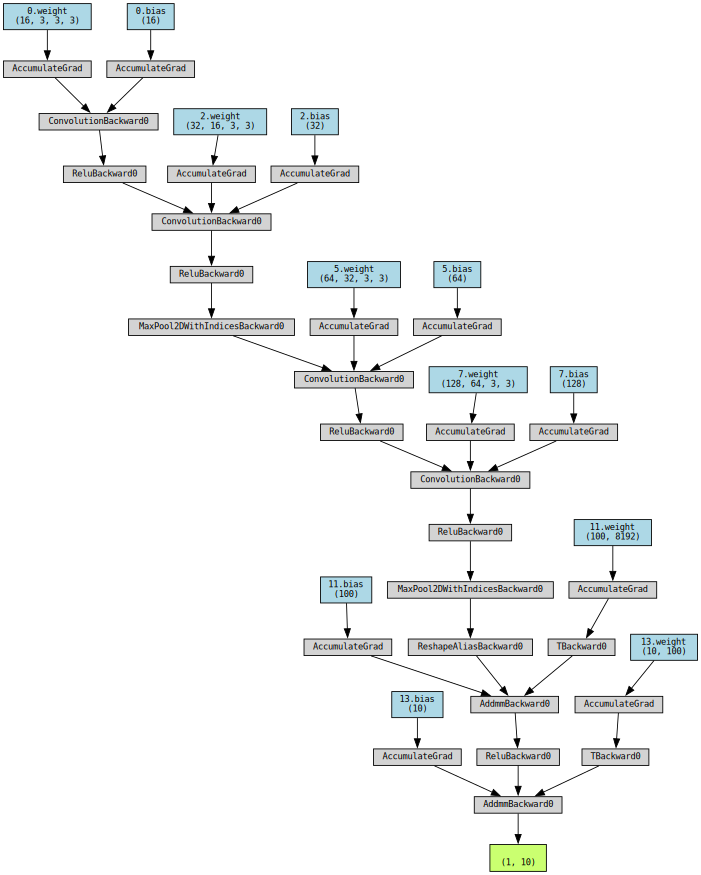

In [36]:
from torchviz import make_dot
from torch import nn

net = nn.Sequential(
    nn.Conv2d(3, 16, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 32, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Conv2d(32, 64, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 128, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Flatten(),
    nn.Linear(8*8*128,100),
    nn.ReLU(),
    nn.Linear(100,10)
)
x = torch.randn(1, 3, 32, 32)
make_dot(net(x), params=dict(net.named_parameters()))



In [37]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(ImageClassificationBase):
    
    

    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)


    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

ResNet = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10)



In [38]:
import torch
import torch.nn as nn

class ResNeXtBottleneck(ImageClassificationBase):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, cardinality=32, downsample=None):
        super(ResNeXtBottleneck, self).__init__()

        self.cardinality = cardinality
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, groups=cardinality, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn
    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNeXt(nn.Module):
    def __init__(self, block, layers, num_classes=10, cardinality=32):
        super(ResNeXt, self).__init__()
        self.cardinality = cardinality
        self.in_channels = 64
        self.conv = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels * block.expansion):
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, self.cardinality, downsample))
        self.in_channels = out_channels * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_channels, out_channels, cardinality=self.cardinality))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

ResNext = ResNeXt(ResNeXtBottleneck, [3, 4, 6, 3], num_classes=10, cardinality=32)



In [44]:
import torch
import torch.nn as nn

class DenseNet(ImageClassificationBase):
    def __init__(self, in_channels, growth_rate, num_layers, num_classes):
        super(DenseNet, self).__init__()
        self.conv = nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1, bias=True)
        self.bn = nn.BatchNorm2d(growth_rate)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2, 2)
        self.dense_blocks = nn.ModuleList()
        self.transition_layers = nn.ModuleList()
        in_channels = growth_rate
        for i in range(len(num_layers)):
            self.dense_blocks.append(DenseBlock(in_channels, growth_rate, num_layers[i]))
            in_channels += growth_rate * num_layers[i]
            if i != len(num_layers) - 1:
                out_channels = int(in_channels * 0.5)
                self.transition_layers.append(Transition(in_channels, out_channels))
                in_channels = out_channels
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.maxpool(x)

        for i, dense_block in enumerate(self.dense_blocks):
            x = dense_block(x)
            if i != len(self.dense_blocks) - 1:
                x = self.transition_layers[i](x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

class Transition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Transition, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.pool(x)
        return x

    
# Create DenseNet model
DenseNet = DenseNet(in_channels=3, growth_rate=32, num_layers=[6, 12, 24, 16], num_classes=10)
